In [1]:
import re
import time
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import hanlp
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
    
%matplotlib inline
mpl.rcParams['font.family'] = 'SimHei'

RANDOM_SEED = 666

np.random.seed(RANDOM_SEED)

In [2]:
df = pd.read_excel('./data/data_train.xlsx')
df.sample(10)

,情感,语句,来源
100699,抱怨,想了半天还真没有什么吐槽的地方，车身高度不够，后排乘客身子长的会顶头，后备箱空间略小（还是那...,开源数据集
99496,抱怨,没有mkx的持钥匙走近亮灯,开源数据集
15042,投诉,一汽丰田皇冠仪表台老化反光影响视线,车质网
106097,表扬,我和媳妇都是两厢控，最满意的就是320的外观了，适合年轻人时尚又不失大气，白颜色非常靓丽配合...,开源数据集
115342,表扬,空间大，相对来说舒适性较好，性比价好些。,开源数据集
80088,抱怨,隔音不是很好，中控加装的十寸大屏有点斜，导致后排看屏幕有色彩不对。,开源数据集
18793,投诉,长安CS75 PLUS涡轮增压器漏油维修未解决,车质网
96265,抱怨,油耗偏高，噪音偏大,开源数据集
114096,表扬,外观好看，底盘扎实，内饰做工精细，乘坐空间和储物空间布局合理，特别后排中间凸起不高不影响中间...,开源数据集
69909,中性,看到最后一句快看哭了......(我慢慢变成了我喜欢的男孩子的样子......,COLDataset


In [3]:
print(f'样本数:{df.shape}')

样本数:(142834, 3)


类别：
抱怨    37153
表扬    35101
投诉    30508
中性    21881
辱骂    18191
Name: 情感, dtype: int64


Text(0.5, 1.0, '类别分布')

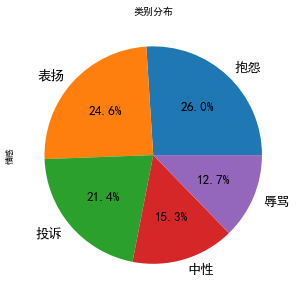

In [4]:
print(f"类别：\n{df['情感'].value_counts()}")

plt.figure(figsize = (6, 6), dpi = 60)
df['情感'].value_counts().plot.pie(autopct = '%1.1f%%', textprops = {'fontsize': 16}).set_title('类别分布')

In [5]:
print(f"缺失值分布：\n {df['语句'].isna().sum()}")

缺失值分布：
 3


In [6]:
df[df['语句'].isna()]

,情感,语句,来源
36723,中性,NaN,COLDataset
52766,辱骂,NaN,COLDataset
62669,辱骂,NaN,COLDataset


In [7]:
df = df.dropna()
print(f"缺失值分布：\n {df['语句'].isna().sum()}")
print(f'样本数:{df.shape}')

缺失值分布：
 0
样本数:(142831, 3)


In [8]:
# df['语句'].iloc[36723]
# # df['语句'][36723]

In [9]:
print(f"重复值：\n {df['语句'].duplicated().sum()}，比例：{np.round(100 * df['语句'].duplicated().sum() / len(df), 3)}%")

重复值：
 10743，比例：7.521%


In [10]:
df[df['语句'].duplicated()]['语句']  # 好奇怪？为啥会重复？

88                      价格要是能再低点就更好了！京东应该多搞特价活动!快递的服务态度不是很好
134          国产代工，电池部分设计不合理，装上电池后，与键盘平行的那一面有一点点高起来，有可能与屏接触。
194       我在买之前就看到很多人说装系统麻烦，果然不只一点点烦啊，一开始硬盘没找到。。。找了半天，不过...
262       六心电池装在后面突出一大块影响美观，速度慢机器有点卡，放歌一停顿一停顿，重量比一般的上网本重...
274       发热是普遍的，不过从07年我就开始使用的6515b的情况看，这个热是没有带来任何问题的，你不...
                                ...                        
142042                      动力稍稍有点不足，油耗有点小高，不知道是不是我不太会开的缘故。
142048    感觉北汽幻速车噪音还是有点的，不过慢慢习惯了就好了，特别是车子起步时候，踩上油门时候有明显感...
142056    最不满意的就是车子的动力还是有点不那么够用，一般家用的话应该是可以了，主要我是用来拉客偶尔也...
142179    虽然我是新手，但是油耗对于1.5l排量的车确实高，百公里差不多9个油，还有就是挂2档的时候，...
142552                                                 暂时没有
Name: 语句, Length: 10743, dtype: object

In [11]:
# 处理“6666”纯数字的文本
def handle_int(content):
    if type(content) == int:
        return str(content)
    return content

In [12]:
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', content)

In [13]:
df['语句'] = df['语句'].apply(lambda x: handle_int(x))
df['语句'] = df['语句'].apply(lambda x: remove_url(x))

In [14]:
labels = LabelEncoder().fit(df['情感'])
df['label'] = labels.transform(df['情感'])
df['label'].value_counts()

2    37153
3    35101
1    30508
0    21880
4    18189
Name: label, dtype: int64

In [15]:
hanlp.pretrained.tok.ALL

{'SIGHAN2005_PKU_CONVSEG': 'https://file.hankcs.com/hanlp/tok/sighan2005-pku-convseg_20200110_153722.zip',
 'SIGHAN2005_MSR_CONVSEG': 'https://file.hankcs.com/hanlp/tok/convseg-msr-nocrf-noembed_20200110_153524.zip',
 'CTB6_CONVSEG': 'https://file.hankcs.com/hanlp/tok/ctb6_convseg_nowe_nocrf_20200110_004046.zip',
 'PKU_NAME_MERGED_SIX_MONTHS_CONVSEG': 'https://file.hankcs.com/hanlp/tok/pku98_6m_conv_ngram_20200110_134736.zip',
 'LARGE_ALBERT_BASE': 'https://file.hankcs.com/hanlp/tok/large_corpus_cws_albert_base_20211228_160926.zip',
 'SIGHAN2005_PKU_BERT_BASE_ZH': 'https://file.hankcs.com/hanlp/tok/sighan2005_pku_bert_base_zh_20201231_141130.zip',
 'COARSE_ELECTRA_SMALL_ZH': 'https://file.hankcs.com/hanlp/tok/coarse_electra_small_20220616_012050.zip',
 'FINE_ELECTRA_SMALL_ZH': 'https://file.hankcs.com/hanlp/tok/fine_electra_small_20220615_231803.zip',
 'CTB9_TOK_ELECTRA_SMALL': 'https://file.hankcs.com/hanlp/tok/ctb9_electra_small_20220215_205427.zip',
 'CTB9_TOK_ELECTRA_BASE': 'http:/

In [16]:
tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)

In [27]:
def tokenize(content):
    seg_list = tok(content)
    return ' '.join(seg_list)

In [ ]:
# 注意：这里会运行很久
df['text_splited'] = df['语句'].apply(tokenize)

In [ ]:
df.sample(5)

In [70]:
tfidf = TfidfVectorizer()
text_tfidf = tfidf.fit_transform(df['text_splited'])

In [71]:
# tfidf.get_feature_names()

In [111]:
classifiers = {
    'LogisticRegression': LogisticRegression(random_state = RANDOM_SEED),
    'RidgeClassifier': RidgeClassifier(random_state = RANDOM_SEED)
}

lr_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
    'max_iter': [50, 100, 200]
}

rd_grid = {
    'alpha': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
    'max_iter': [50, 100, 200]
}

grid_search_paramters = {
    'LogisticRegression': lr_grid,
    'RidgeClassifier': rd_grid
}

In [112]:
X = text_tfidf
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)
X_train_grid, X_val_grid, y_train_grid, y_val_grid = train_test_split(X_train, y_train, test_size = 0.1)

In [113]:
# clf_test = LogisticRegression()
# clf_test.fit(X_test[:100], y_test[:100])
# clf_test.predict(X_test[100: 200])

In [114]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({'Classifier': classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time (mins):': np.zeros(len(classifiers))})

In [115]:
for key, classifier in classifiers.items():
    start = time.time()
    
    clf = GridSearchCV(estimator = classifier, param_grid = grid_search_paramters[key], n_jobs = -1, cv = None)
    clf.fit(X_train_grid, y_train_grid)
    valid_scores.iloc[i, 1] = clf.score(X_val_grid, y_val_grid)
    
    clf_best_params[key] = clf.best_params_
    
    stop = time.time()
    valid_scores.iloc[i, 2] = np.round((stop - start) / 60, 3)
    
    print(f'Model: {key}')
    print(f'Training time (mins): {valid_scores.iloc[i, 2]}')
    print('')
    
    i += 1

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.p

Model: LogisticRegression
Training time (mins): 5.79

Model: RidgeClassifier
Training time (mins): 0.968



In [119]:
valid_scores

,Classifier,Validation accuracy,Training time (mins):
0,LogisticRegression,0.911875,5.790
1,RidgeClassifier,0.908375,0.968


In [120]:
clf_best_params

{'LogisticRegression': {'C': 1.5, 'max_iter': 200, 'penalty': 'l2'},
 'RidgeClassifier': {'alpha': 1.5, 'max_iter': 50}}

In [121]:
best_classifiers = {
    'LogisticRegression': LogisticRegression(**clf_best_params['LogisticRegression'], random_state = RANDOM_SEED)
}

In [133]:
FOLDS = 10
# preds = np.zeros(len(X_test))
X_final = X_train
y_final = np.array(y_train)
for key, classifier in best_classifiers.items():
    start = time.time()
    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = RANDOM_SEED)
    score = 0
    for fold , (train_idx, val_idx) in enumerate(cv.split(X_final, y_final)):
        X_train_cv, X_valid_cv = X_final[train_idx], X_final[val_idx]
        y_train_cv, y_valid_cv = y_final[train_idx], y_final[val_idx]
        
        classifier.fit(X_train_cv, y_train_cv)
        score += classifier.score(X_valid_cv, y_valid_cv)
#         preds += classifier.predict_proba(X_test)[:, 1]
    
    score = score / FOLDS
    stop = time.time()
    
    print(f'Model: {key}')
    print(f'Average validation accuracy: {np.round(100 * score, 3)}%')
    print(f'Training time (mins): {np.round((stop - start) / 60, 3)}')

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Model: LogisticRegression
Average validation accuracy: 91.313%
Training time (mins): (3.0, 3)


D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### BERT

In [15]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

torch.manual_seed(RANDOM_SEED)

In [16]:
df.head()

,情感,语句,来源,label
0,抱怨,唯一感觉不足的是硬盘就分了两个驱，每个100多G，要是能分成3个或更多就好了，呵呵,总部,2
1,抱怨,六芯电池突出一块，影响美观；重量比一般上网本略重；触摸板反应不灵敏，左右键不太适应；没有配件...,总部,2
2,抱怨,XP的驱动不好找！我的17号提的货，现在就降价了100元，而且还送杀毒软件！,总部,2
3,抱怨,内存是2条，若升级，必须废除至少一条，有点浪费，该为用户着想一点。USB接口有点紧，内存藏盖...,总部,2
4,抱怨,摄像头不清楚，散热一般，说是商务型的，散热还是不怎么样！华硕屏的亮度都不好，声音小，音质比以...,总部,2


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['语句'], 
                                                    df['label'], 
                                                    stratify = df['label'], 
                                                    test_size = 0.2, 
                                                    random_state = RANDOM_SEED)

X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                stratify = y_test, 
                                                test_size = 0.5,
                                                random_state = RANDOM_SEED)

In [18]:
sentence_len_list = [len(x) for x in X_train]

# plt.title('句子长度分布')
# plt.ylabel('句子长度')
# plt.bar(range(len(X_train)), sentenct_len_list)

(array([6.0000e+00, 2.4980e+03, 2.8600e+03, 5.0180e+03, 5.2970e+03,
        5.2350e+03, 1.7601e+04, 1.4342e+04, 4.5890e+03, 4.8670e+03,
        4.1930e+03, 2.5800e+03, 3.6830e+03, 2.4100e+03, 3.2240e+03,
        3.0240e+03, 1.9110e+03, 2.6590e+03, 2.4390e+03, 1.4840e+03,
        2.0930e+03, 1.9350e+03, 1.2060e+03, 1.6890e+03, 1.0720e+03,
        1.5390e+03, 1.4630e+03, 9.4100e+02, 1.2970e+03, 1.2520e+03,
        6.9800e+02, 1.0940e+03, 1.0430e+03, 6.6000e+02, 9.1300e+02,
        9.2400e+02, 6.5400e+02, 9.6600e+02, 2.5400e+02, 4.3100e+02,
        3.7700e+02, 2.3600e+02, 3.4300e+02, 3.1900e+02, 2.0300e+02,
        2.6700e+02, 1.5300e+02, 9.8000e+01, 8.5000e+01, 6.0000e+00,
        1.1000e+01, 5.0000e+00, 6.0000e+00, 8.0000e+00, 4.0000e+00,
        2.0000e+00, 6.0000e+00, 1.0000e+01, 5.0000e+00, 2.2000e+01,
        1.2000e+01, 5.0000e+00, 7.0000e+00, 7.0000e+00, 5.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.00

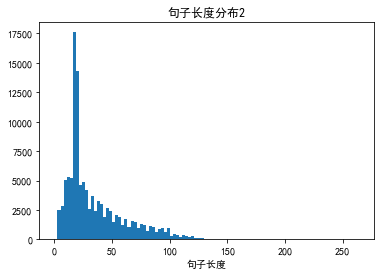

In [19]:
plt.title('句子长度分布2')
plt.xlabel('句子长度')
plt.hist(sentence_len_list, bins = 100)

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
train_encoding = tokenizer(list(X_train), truncation = True, padding = True, max_length = 100)
val_encoding = tokenizer(list(X_val), truncation = True, padding = True, max_length = 100)
test_encoding = tokenizer(list(X_test), truncation = True, padding = True, max_length = 100)

In [21]:
# test
tokenizer(X_train.iloc[10000])

{'input_ids': [101, 1290, 3247, 2140, 7716, 126, 5143, 6756, 3322, 5143, 5320, 1216, 5543, 680, 2146, 837, 679, 5016, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
class TextDataset(Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [23]:
BATCH_SIZE = 32

train_dataset = TextDataset(train_encoding, y_train)
val_dataset = TextDataset(val_encoding, y_val)
test_dataset = TextDataset(test_encoding, y_test)

train_data_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_data_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_data_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [24]:
# test
train_dataset[1]

{'input_ids': tensor([ 101, 1506, 2472, 6619, 1052, 6756, 6716, 4024, 7481, 7961, 1259, 6206,
         3724, 1322, 2157, 6237, 1104,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [25]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 5e-5
EPOCHS = 10

In [26]:
num_labels = len(df['label'].value_counts())
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels = num_labels)
model.to(DEVICE)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
loss_function = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, batch_size, epoch_idx):
    model = model.train()
    losses = []
    correct_predictions = 0
    n_examples = batch_size * len(data_loader)
    
    for idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).to(torch.int64)  # 要转为int64，不然报错
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        
#         print(outputs)
    
        loss = loss_fn(outputs.logits, labels)
#         print(f'loss: {outputs.loss}, {loss}')
        
        _, pred_idxs = torch.max(outputs.logits, dim = 1)
        correct_predictions += torch.sum(pred_idxs == labels)
        losses.append(loss.item())
        
        print(f'epoch: {epoch_idx} | {idx * batch_size} / {n_examples} | training loss: {loss}')
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)
        

In [29]:
def eval_epoch(model, data_loader, loss_fn, device, batch_size, epoch_idx):
    model = model.eval()
    losses = []
    correct_predictions = 0
    n_examples = batch_size * len(data_loader)
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).to(torch.int64)  # 要转为int64，不然报错
            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
            loss = loss_fn(outputs.logits, labels)
            _, pred_idxs = torch.max(outputs.logits, dim = 1)
            
            correct_predictions += torch.sum(pred_idxs == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)
        

In [30]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} / {EPOCHS}')
    print('-' * 66)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_function,
        optimizer,
        DEVICE,
        scheduler,
        BATCH_SIZE,
        epoch
    )
    
    print(f'Training epoch {epoch} done! Average loss: {train_loss}. Accuracy: {train_acc}')
    
    val_acc, val_loss = eval_epoch(
        model,
        val_data_loader,
        loss_function,
        DEVICE,
        BATCH_SIZE,
        epoch
    )
    
    print(f'Validation epoch {epoch} done! Average loss: {val_loss}. Accurage: {val_acc}')
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), './output/cu_best_model_sentiment_analysis.bin')
        best_accuracy = val_acc

Epoch 1 / 10
------------------------------------------------------------------
epoch: 0 | 0 / 114272 | training loss: 1.5561431646347046
epoch: 0 | 32 / 114272 | training loss: 1.4505271911621094
epoch: 0 | 64 / 114272 | training loss: 1.4607775211334229
epoch: 0 | 96 / 114272 | training loss: 1.2168679237365723
epoch: 0 | 128 / 114272 | training loss: 1.228115439414978
epoch: 0 | 160 / 114272 | training loss: 1.0814472436904907
epoch: 0 | 192 / 114272 | training loss: 0.895542562007904
epoch: 0 | 224 / 114272 | training loss: 1.0388500690460205
epoch: 0 | 256 / 114272 | training loss: 1.0344936847686768
epoch: 0 | 288 / 114272 | training loss: 0.8923239707946777
epoch: 0 | 320 / 114272 | training loss: 0.8056987524032593
epoch: 0 | 352 / 114272 | training loss: 1.023438811302185
epoch: 0 | 384 / 114272 | training loss: 0.8719208240509033
epoch: 0 | 416 / 114272 | training loss: 0.8704617619514465
epoch: 0 | 448 / 114272 | training loss: 0.8060319423675537
epoch: 0 | 480 / 114272 | tr

epoch: 0 | 4256 / 114272 | training loss: 0.04267065227031708
epoch: 0 | 4288 / 114272 | training loss: 0.12842155992984772
epoch: 0 | 4320 / 114272 | training loss: 0.32888442277908325
epoch: 0 | 4352 / 114272 | training loss: 0.516974151134491
epoch: 0 | 4384 / 114272 | training loss: 0.2270207554101944
epoch: 0 | 4416 / 114272 | training loss: 0.20605988800525665
epoch: 0 | 4448 / 114272 | training loss: 0.4096188247203827
epoch: 0 | 4480 / 114272 | training loss: 0.22234629094600677
epoch: 0 | 4512 / 114272 | training loss: 0.1151776984333992
epoch: 0 | 4544 / 114272 | training loss: 0.1563706398010254
epoch: 0 | 4576 / 114272 | training loss: 0.07679738104343414
epoch: 0 | 4608 / 114272 | training loss: 0.26543208956718445
epoch: 0 | 4640 / 114272 | training loss: 0.7574506998062134
epoch: 0 | 4672 / 114272 | training loss: 0.13656292855739594
epoch: 0 | 4704 / 114272 | training loss: 0.242642343044281
epoch: 0 | 4736 / 114272 | training loss: 0.26994583010673523
epoch: 0 | 4768 /

epoch: 0 | 8544 / 114272 | training loss: 0.26445651054382324
epoch: 0 | 8576 / 114272 | training loss: 0.09239322692155838
epoch: 0 | 8608 / 114272 | training loss: 0.2497396171092987
epoch: 0 | 8640 / 114272 | training loss: 0.11092303693294525
epoch: 0 | 8672 / 114272 | training loss: 0.17842723429203033
epoch: 0 | 8704 / 114272 | training loss: 0.03436705097556114
epoch: 0 | 8736 / 114272 | training loss: 0.5036190152168274
epoch: 0 | 8768 / 114272 | training loss: 0.3586677610874176
epoch: 0 | 8800 / 114272 | training loss: 0.2697771191596985
epoch: 0 | 8832 / 114272 | training loss: 0.14258591830730438
epoch: 0 | 8864 / 114272 | training loss: 0.05544507876038551
epoch: 0 | 8896 / 114272 | training loss: 0.13139231503009796
epoch: 0 | 8928 / 114272 | training loss: 0.09750055521726608
epoch: 0 | 8960 / 114272 | training loss: 0.28331440687179565
epoch: 0 | 8992 / 114272 | training loss: 0.19838294386863708
epoch: 0 | 9024 / 114272 | training loss: 0.08339394629001617
epoch: 0 | 9

epoch: 0 | 12768 / 114272 | training loss: 0.37068668007850647
epoch: 0 | 12800 / 114272 | training loss: 0.26181796193122864
epoch: 0 | 12832 / 114272 | training loss: 0.05912419408559799
epoch: 0 | 12864 / 114272 | training loss: 0.1212489902973175
epoch: 0 | 12896 / 114272 | training loss: 0.06074461340904236
epoch: 0 | 12928 / 114272 | training loss: 0.30498006939888
epoch: 0 | 12960 / 114272 | training loss: 0.17435859143733978
epoch: 0 | 12992 / 114272 | training loss: 0.05886908248066902
epoch: 0 | 13024 / 114272 | training loss: 0.3908451795578003
epoch: 0 | 13056 / 114272 | training loss: 0.26371046900749207
epoch: 0 | 13088 / 114272 | training loss: 0.5762686729431152
epoch: 0 | 13120 / 114272 | training loss: 0.21261677145957947
epoch: 0 | 13152 / 114272 | training loss: 0.1911945939064026
epoch: 0 | 13184 / 114272 | training loss: 0.044801805168390274
epoch: 0 | 13216 / 114272 | training loss: 0.2305530309677124
epoch: 0 | 13248 / 114272 | training loss: 0.40734851360321045

epoch: 0 | 16960 / 114272 | training loss: 0.21688397228717804
epoch: 0 | 16992 / 114272 | training loss: 0.2980193495750427
epoch: 0 | 17024 / 114272 | training loss: 0.06663262844085693
epoch: 0 | 17056 / 114272 | training loss: 0.10445386916399002
epoch: 0 | 17088 / 114272 | training loss: 0.1289837807416916
epoch: 0 | 17120 / 114272 | training loss: 0.1386079639196396
epoch: 0 | 17152 / 114272 | training loss: 0.2799355685710907
epoch: 0 | 17184 / 114272 | training loss: 0.22770912945270538
epoch: 0 | 17216 / 114272 | training loss: 0.40306082367897034
epoch: 0 | 17248 / 114272 | training loss: 0.1703464686870575
epoch: 0 | 17280 / 114272 | training loss: 0.13734102249145508
epoch: 0 | 17312 / 114272 | training loss: 0.15192285180091858
epoch: 0 | 17344 / 114272 | training loss: 0.14281825721263885
epoch: 0 | 17376 / 114272 | training loss: 0.060792721807956696
epoch: 0 | 17408 / 114272 | training loss: 0.27206721901893616
epoch: 0 | 17440 / 114272 | training loss: 0.27075615525245

epoch: 0 | 21152 / 114272 | training loss: 0.17575539648532867
epoch: 0 | 21184 / 114272 | training loss: 0.15120093524456024
epoch: 0 | 21216 / 114272 | training loss: 0.1498817801475525
epoch: 0 | 21248 / 114272 | training loss: 0.35105443000793457
epoch: 0 | 21280 / 114272 | training loss: 0.10606196522712708
epoch: 0 | 21312 / 114272 | training loss: 0.04049985110759735
epoch: 0 | 21344 / 114272 | training loss: 0.06469959020614624
epoch: 0 | 21376 / 114272 | training loss: 0.17029279470443726
epoch: 0 | 21408 / 114272 | training loss: 0.198335662484169
epoch: 0 | 21440 / 114272 | training loss: 0.1838924139738083
epoch: 0 | 21472 / 114272 | training loss: 0.1500725895166397
epoch: 0 | 21504 / 114272 | training loss: 0.21906079351902008
epoch: 0 | 21536 / 114272 | training loss: 0.1732594072818756
epoch: 0 | 21568 / 114272 | training loss: 0.10206479579210281
epoch: 0 | 21600 / 114272 | training loss: 0.22506336867809296
epoch: 0 | 21632 / 114272 | training loss: 0.2956188619136810

epoch: 0 | 25344 / 114272 | training loss: 0.05215661972761154
epoch: 0 | 25376 / 114272 | training loss: 0.015967611223459244
epoch: 0 | 25408 / 114272 | training loss: 0.14701025187969208
epoch: 0 | 25440 / 114272 | training loss: 0.20614756643772125
epoch: 0 | 25472 / 114272 | training loss: 0.2502681612968445
epoch: 0 | 25504 / 114272 | training loss: 0.020176297053694725
epoch: 0 | 25536 / 114272 | training loss: 0.1905515342950821
epoch: 0 | 25568 / 114272 | training loss: 0.1253126859664917
epoch: 0 | 25600 / 114272 | training loss: 0.2739475965499878
epoch: 0 | 25632 / 114272 | training loss: 0.6287651658058167
epoch: 0 | 25664 / 114272 | training loss: 0.4057594835758209
epoch: 0 | 25696 / 114272 | training loss: 0.29243114590644836
epoch: 0 | 25728 / 114272 | training loss: 0.3843831419944763
epoch: 0 | 25760 / 114272 | training loss: 0.5759756565093994
epoch: 0 | 25792 / 114272 | training loss: 0.22193360328674316
epoch: 0 | 25824 / 114272 | training loss: 0.2001060843467712

epoch: 0 | 29536 / 114272 | training loss: 0.2906245291233063
epoch: 0 | 29568 / 114272 | training loss: 0.05492512136697769
epoch: 0 | 29600 / 114272 | training loss: 0.04341956973075867
epoch: 0 | 29632 / 114272 | training loss: 0.08813440799713135
epoch: 0 | 29664 / 114272 | training loss: 0.5737851858139038
epoch: 0 | 29696 / 114272 | training loss: 0.053578272461891174
epoch: 0 | 29728 / 114272 | training loss: 0.06314364075660706
epoch: 0 | 29760 / 114272 | training loss: 0.16994313895702362
epoch: 0 | 29792 / 114272 | training loss: 0.14521805942058563
epoch: 0 | 29824 / 114272 | training loss: 0.417492151260376
epoch: 0 | 29856 / 114272 | training loss: 0.5626689791679382
epoch: 0 | 29888 / 114272 | training loss: 0.1718904674053192
epoch: 0 | 29920 / 114272 | training loss: 0.09314148873090744
epoch: 0 | 29952 / 114272 | training loss: 0.1907242089509964
epoch: 0 | 29984 / 114272 | training loss: 0.05757495015859604
epoch: 0 | 30016 / 114272 | training loss: 0.2037055939435959

epoch: 0 | 33728 / 114272 | training loss: 0.18807905912399292
epoch: 0 | 33760 / 114272 | training loss: 0.17031395435333252
epoch: 0 | 33792 / 114272 | training loss: 0.17192506790161133
epoch: 0 | 33824 / 114272 | training loss: 0.09873558580875397
epoch: 0 | 33856 / 114272 | training loss: 0.15337081253528595
epoch: 0 | 33888 / 114272 | training loss: 0.2855170667171478
epoch: 0 | 33920 / 114272 | training loss: 0.18365153670310974
epoch: 0 | 33952 / 114272 | training loss: 0.1564277708530426
epoch: 0 | 33984 / 114272 | training loss: 0.1714698225259781
epoch: 0 | 34016 / 114272 | training loss: 0.09804724901914597
epoch: 0 | 34048 / 114272 | training loss: 0.157558411359787
epoch: 0 | 34080 / 114272 | training loss: 0.09023541957139969
epoch: 0 | 34112 / 114272 | training loss: 0.05887511372566223
epoch: 0 | 34144 / 114272 | training loss: 0.040492232888936996
epoch: 0 | 34176 / 114272 | training loss: 0.13770410418510437
epoch: 0 | 34208 / 114272 | training loss: 0.48387730121612

epoch: 0 | 37920 / 114272 | training loss: 0.49862080812454224
epoch: 0 | 37952 / 114272 | training loss: 0.04120991379022598
epoch: 0 | 37984 / 114272 | training loss: 0.19522689282894135
epoch: 0 | 38016 / 114272 | training loss: 0.12552298605442047
epoch: 0 | 38048 / 114272 | training loss: 0.050132207572460175
epoch: 0 | 38080 / 114272 | training loss: 0.26461219787597656
epoch: 0 | 38112 / 114272 | training loss: 0.09787683188915253
epoch: 0 | 38144 / 114272 | training loss: 0.10528711974620819
epoch: 0 | 38176 / 114272 | training loss: 0.09911704808473587
epoch: 0 | 38208 / 114272 | training loss: 0.4321047365665436
epoch: 0 | 38240 / 114272 | training loss: 0.24068154394626617
epoch: 0 | 38272 / 114272 | training loss: 0.25596341490745544
epoch: 0 | 38304 / 114272 | training loss: 0.14566804468631744
epoch: 0 | 38336 / 114272 | training loss: 0.1284569799900055
epoch: 0 | 38368 / 114272 | training loss: 0.056246355175971985
epoch: 0 | 38400 / 114272 | training loss: 0.0482652112

epoch: 0 | 42112 / 114272 | training loss: 0.131110280752182
epoch: 0 | 42144 / 114272 | training loss: 0.039936505258083344
epoch: 0 | 42176 / 114272 | training loss: 0.3867571949958801
epoch: 0 | 42208 / 114272 | training loss: 0.03467332199215889
epoch: 0 | 42240 / 114272 | training loss: 0.05557345971465111
epoch: 0 | 42272 / 114272 | training loss: 0.2239864021539688
epoch: 0 | 42304 / 114272 | training loss: 0.03867567330598831
epoch: 0 | 42336 / 114272 | training loss: 0.16790558397769928
epoch: 0 | 42368 / 114272 | training loss: 0.11945907026529312
epoch: 0 | 42400 / 114272 | training loss: 0.11483226716518402
epoch: 0 | 42432 / 114272 | training loss: 0.07158050686120987
epoch: 0 | 42464 / 114272 | training loss: 0.23133210837841034
epoch: 0 | 42496 / 114272 | training loss: 0.10345485806465149
epoch: 0 | 42528 / 114272 | training loss: 0.027356473729014397
epoch: 0 | 42560 / 114272 | training loss: 0.2035059779882431
epoch: 0 | 42592 / 114272 | training loss: 0.2726775109767

epoch: 0 | 46304 / 114272 | training loss: 0.29360151290893555
epoch: 0 | 46336 / 114272 | training loss: 0.158205047249794
epoch: 0 | 46368 / 114272 | training loss: 0.2425844371318817
epoch: 0 | 46400 / 114272 | training loss: 0.042432572692632675
epoch: 0 | 46432 / 114272 | training loss: 0.08103042840957642
epoch: 0 | 46464 / 114272 | training loss: 0.07289879024028778
epoch: 0 | 46496 / 114272 | training loss: 0.20419159531593323
epoch: 0 | 46528 / 114272 | training loss: 0.24561807513237
epoch: 0 | 46560 / 114272 | training loss: 0.12895463407039642
epoch: 0 | 46592 / 114272 | training loss: 0.06847468763589859
epoch: 0 | 46624 / 114272 | training loss: 0.17101360857486725
epoch: 0 | 46656 / 114272 | training loss: 0.23244409263134003
epoch: 0 | 46688 / 114272 | training loss: 0.43714869022369385
epoch: 0 | 46720 / 114272 | training loss: 0.06671334058046341
epoch: 0 | 46752 / 114272 | training loss: 0.4373345971107483
epoch: 0 | 46784 / 114272 | training loss: 0.1960971504449844

epoch: 0 | 50496 / 114272 | training loss: 0.08183177560567856
epoch: 0 | 50528 / 114272 | training loss: 0.15364325046539307
epoch: 0 | 50560 / 114272 | training loss: 0.20937153697013855
epoch: 0 | 50592 / 114272 | training loss: 0.11803620308637619
epoch: 0 | 50624 / 114272 | training loss: 0.10747815668582916
epoch: 0 | 50656 / 114272 | training loss: 0.060002733021974564
epoch: 0 | 50688 / 114272 | training loss: 0.21250180900096893
epoch: 0 | 50720 / 114272 | training loss: 0.19728697836399078
epoch: 0 | 50752 / 114272 | training loss: 0.03670179098844528
epoch: 0 | 50784 / 114272 | training loss: 0.12889501452445984
epoch: 0 | 50816 / 114272 | training loss: 0.17866559326648712
epoch: 0 | 50848 / 114272 | training loss: 0.08470454812049866
epoch: 0 | 50880 / 114272 | training loss: 0.22855506837368011
epoch: 0 | 50912 / 114272 | training loss: 0.12447924166917801
epoch: 0 | 50944 / 114272 | training loss: 0.15254680812358856
epoch: 0 | 50976 / 114272 | training loss: 0.131325453

epoch: 0 | 54688 / 114272 | training loss: 0.14083248376846313
epoch: 0 | 54720 / 114272 | training loss: 0.3437820374965668
epoch: 0 | 54752 / 114272 | training loss: 0.12492237985134125
epoch: 0 | 54784 / 114272 | training loss: 0.06165922060608864
epoch: 0 | 54816 / 114272 | training loss: 0.2548496425151825
epoch: 0 | 54848 / 114272 | training loss: 0.3209418058395386
epoch: 0 | 54880 / 114272 | training loss: 0.052280325442552567
epoch: 0 | 54912 / 114272 | training loss: 0.12257584184408188
epoch: 0 | 54944 / 114272 | training loss: 0.09914392232894897
epoch: 0 | 54976 / 114272 | training loss: 0.20842114090919495
epoch: 0 | 55008 / 114272 | training loss: 0.09456513822078705
epoch: 0 | 55040 / 114272 | training loss: 0.08671540766954422
epoch: 0 | 55072 / 114272 | training loss: 0.04301784560084343
epoch: 0 | 55104 / 114272 | training loss: 0.03419991210103035
epoch: 0 | 55136 / 114272 | training loss: 0.04004867002367973
epoch: 0 | 55168 / 114272 | training loss: 0.156690329313

epoch: 0 | 58880 / 114272 | training loss: 0.2677321434020996
epoch: 0 | 58912 / 114272 | training loss: 0.13059918582439423
epoch: 0 | 58944 / 114272 | training loss: 0.23689639568328857
epoch: 0 | 58976 / 114272 | training loss: 0.3758169114589691
epoch: 0 | 59008 / 114272 | training loss: 0.01607748307287693
epoch: 0 | 59040 / 114272 | training loss: 0.029170462861657143
epoch: 0 | 59072 / 114272 | training loss: 0.3179752826690674
epoch: 0 | 59104 / 114272 | training loss: 0.19291605055332184
epoch: 0 | 59136 / 114272 | training loss: 0.07133567333221436
epoch: 0 | 59168 / 114272 | training loss: 0.0361807644367218
epoch: 0 | 59200 / 114272 | training loss: 0.045922622084617615
epoch: 0 | 59232 / 114272 | training loss: 0.21327732503414154
epoch: 0 | 59264 / 114272 | training loss: 0.07321301102638245
epoch: 0 | 59296 / 114272 | training loss: 0.03178173676133156
epoch: 0 | 59328 / 114272 | training loss: 0.13523605465888977
epoch: 0 | 59360 / 114272 | training loss: 0.125000968575

epoch: 0 | 63072 / 114272 | training loss: 0.29713669419288635
epoch: 0 | 63104 / 114272 | training loss: 0.22906789183616638
epoch: 0 | 63136 / 114272 | training loss: 0.09487367421388626
epoch: 0 | 63168 / 114272 | training loss: 0.12022292613983154
epoch: 0 | 63200 / 114272 | training loss: 0.1412220597267151
epoch: 0 | 63232 / 114272 | training loss: 0.16193997859954834
epoch: 0 | 63264 / 114272 | training loss: 0.25626641511917114
epoch: 0 | 63296 / 114272 | training loss: 0.09227227419614792
epoch: 0 | 63328 / 114272 | training loss: 0.05513482168316841
epoch: 0 | 63360 / 114272 | training loss: 0.24870499968528748
epoch: 0 | 63392 / 114272 | training loss: 0.3639829456806183
epoch: 0 | 63424 / 114272 | training loss: 0.04765366390347481
epoch: 0 | 63456 / 114272 | training loss: 0.19435109198093414
epoch: 0 | 63488 / 114272 | training loss: 0.17653152346611023
epoch: 0 | 63520 / 114272 | training loss: 0.1877496987581253
epoch: 0 | 63552 / 114272 | training loss: 0.0231781098991

epoch: 0 | 67264 / 114272 | training loss: 0.22726888954639435
epoch: 0 | 67296 / 114272 | training loss: 0.21889564394950867
epoch: 0 | 67328 / 114272 | training loss: 0.03351788595318794
epoch: 0 | 67360 / 114272 | training loss: 0.18897758424282074
epoch: 0 | 67392 / 114272 | training loss: 0.12394842505455017
epoch: 0 | 67424 / 114272 | training loss: 0.1455589234828949
epoch: 0 | 67456 / 114272 | training loss: 0.33023378252983093
epoch: 0 | 67488 / 114272 | training loss: 0.08982831984758377
epoch: 0 | 67520 / 114272 | training loss: 0.032559365034103394
epoch: 0 | 67552 / 114272 | training loss: 0.09910781681537628
epoch: 0 | 67584 / 114272 | training loss: 0.13647079467773438
epoch: 0 | 67616 / 114272 | training loss: 0.14020943641662598
epoch: 0 | 67648 / 114272 | training loss: 0.1616402268409729
epoch: 0 | 67680 / 114272 | training loss: 0.13356848061084747
epoch: 0 | 67712 / 114272 | training loss: 0.4138515591621399
epoch: 0 | 67744 / 114272 | training loss: 0.271197944879

epoch: 0 | 71456 / 114272 | training loss: 0.29449713230133057
epoch: 0 | 71488 / 114272 | training loss: 0.06767300516366959
epoch: 0 | 71520 / 114272 | training loss: 0.0785754844546318
epoch: 0 | 71552 / 114272 | training loss: 0.2582961320877075
epoch: 0 | 71584 / 114272 | training loss: 0.04059615358710289
epoch: 0 | 71616 / 114272 | training loss: 0.023785000666975975
epoch: 0 | 71648 / 114272 | training loss: 0.04087098315358162
epoch: 0 | 71680 / 114272 | training loss: 0.03276699036359787
epoch: 0 | 71712 / 114272 | training loss: 0.0065955957397818565
epoch: 0 | 71744 / 114272 | training loss: 0.06418278813362122
epoch: 0 | 71776 / 114272 | training loss: 0.32946163415908813
epoch: 0 | 71808 / 114272 | training loss: 0.2389618307352066
epoch: 0 | 71840 / 114272 | training loss: 0.28215157985687256
epoch: 0 | 71872 / 114272 | training loss: 0.03868958726525307
epoch: 0 | 71904 / 114272 | training loss: 0.04411115124821663
epoch: 0 | 71936 / 114272 | training loss: 0.0110079245

epoch: 0 | 75648 / 114272 | training loss: 0.0324985608458519
epoch: 0 | 75680 / 114272 | training loss: 0.032959550619125366
epoch: 0 | 75712 / 114272 | training loss: 0.23070131242275238
epoch: 0 | 75744 / 114272 | training loss: 0.03371112421154976
epoch: 0 | 75776 / 114272 | training loss: 0.1289762407541275
epoch: 0 | 75808 / 114272 | training loss: 0.20152470469474792
epoch: 0 | 75840 / 114272 | training loss: 0.03555513545870781
epoch: 0 | 75872 / 114272 | training loss: 0.039070259779691696
epoch: 0 | 75904 / 114272 | training loss: 0.07538322359323502
epoch: 0 | 75936 / 114272 | training loss: 0.04381801560521126
epoch: 0 | 75968 / 114272 | training loss: 0.08062101155519485
epoch: 0 | 76000 / 114272 | training loss: 0.2252032607793808
epoch: 0 | 76032 / 114272 | training loss: 0.03888833150267601
epoch: 0 | 76064 / 114272 | training loss: 0.21243330836296082
epoch: 0 | 76096 / 114272 | training loss: 0.2915040850639343
epoch: 0 | 76128 / 114272 | training loss: 0.338084459304

epoch: 0 | 79840 / 114272 | training loss: 0.24386852979660034
epoch: 0 | 79872 / 114272 | training loss: 0.0197976715862751
epoch: 0 | 79904 / 114272 | training loss: 0.11731568723917007
epoch: 0 | 79936 / 114272 | training loss: 0.13585662841796875
epoch: 0 | 79968 / 114272 | training loss: 0.022107001394033432
epoch: 0 | 80000 / 114272 | training loss: 0.1526937335729599
epoch: 0 | 80032 / 114272 | training loss: 0.2395685762166977
epoch: 0 | 80064 / 114272 | training loss: 0.044617537409067154
epoch: 0 | 80096 / 114272 | training loss: 0.17132847011089325
epoch: 0 | 80128 / 114272 | training loss: 0.285503625869751
epoch: 0 | 80160 / 114272 | training loss: 0.19851574301719666
epoch: 0 | 80192 / 114272 | training loss: 0.07254143059253693
epoch: 0 | 80224 / 114272 | training loss: 0.08484715968370438
epoch: 0 | 80256 / 114272 | training loss: 0.029804686084389687
epoch: 0 | 80288 / 114272 | training loss: 0.16655150055885315
epoch: 0 | 80320 / 114272 | training loss: 0.215213254094

epoch: 0 | 84032 / 114272 | training loss: 0.28505218029022217
epoch: 0 | 84064 / 114272 | training loss: 0.10513216257095337
epoch: 0 | 84096 / 114272 | training loss: 0.11245741695165634
epoch: 0 | 84128 / 114272 | training loss: 0.1625916212797165
epoch: 0 | 84160 / 114272 | training loss: 0.07446283847093582
epoch: 0 | 84192 / 114272 | training loss: 0.09797213226556778
epoch: 0 | 84224 / 114272 | training loss: 0.4307298958301544
epoch: 0 | 84256 / 114272 | training loss: 0.18047145009040833
epoch: 0 | 84288 / 114272 | training loss: 0.12442561984062195
epoch: 0 | 84320 / 114272 | training loss: 0.16054105758666992
epoch: 0 | 84352 / 114272 | training loss: 0.07898129522800446
epoch: 0 | 84384 / 114272 | training loss: 0.08325499296188354
epoch: 0 | 84416 / 114272 | training loss: 0.2013043612241745
epoch: 0 | 84448 / 114272 | training loss: 0.21665596961975098
epoch: 0 | 84480 / 114272 | training loss: 0.15915891528129578
epoch: 0 | 84512 / 114272 | training loss: 0.0424458868801

epoch: 0 | 88224 / 114272 | training loss: 0.0660480409860611
epoch: 0 | 88256 / 114272 | training loss: 0.12478700280189514
epoch: 0 | 88288 / 114272 | training loss: 0.028096221387386322
epoch: 0 | 88320 / 114272 | training loss: 0.03191959485411644
epoch: 0 | 88352 / 114272 | training loss: 0.10397297888994217
epoch: 0 | 88384 / 114272 | training loss: 0.2726746201515198
epoch: 0 | 88416 / 114272 | training loss: 0.16375979781150818
epoch: 0 | 88448 / 114272 | training loss: 0.29239484667778015
epoch: 0 | 88480 / 114272 | training loss: 0.042607177048921585
epoch: 0 | 88512 / 114272 | training loss: 0.02745245397090912
epoch: 0 | 88544 / 114272 | training loss: 0.026431841775774956
epoch: 0 | 88576 / 114272 | training loss: 0.1230425164103508
epoch: 0 | 88608 / 114272 | training loss: 0.06350894272327423
epoch: 0 | 88640 / 114272 | training loss: 0.18286164104938507
epoch: 0 | 88672 / 114272 | training loss: 0.14889825880527496
epoch: 0 | 88704 / 114272 | training loss: 0.1418483406

epoch: 0 | 92416 / 114272 | training loss: 0.05779188871383667
epoch: 0 | 92448 / 114272 | training loss: 0.07417687028646469
epoch: 0 | 92480 / 114272 | training loss: 0.2607337236404419
epoch: 0 | 92512 / 114272 | training loss: 0.059637293219566345
epoch: 0 | 92544 / 114272 | training loss: 0.06270003318786621
epoch: 0 | 92576 / 114272 | training loss: 0.40426602959632874
epoch: 0 | 92608 / 114272 | training loss: 0.0690624937415123
epoch: 0 | 92640 / 114272 | training loss: 0.036872684955596924
epoch: 0 | 92672 / 114272 | training loss: 0.0532749742269516
epoch: 0 | 92704 / 114272 | training loss: 0.01187248807400465
epoch: 0 | 92736 / 114272 | training loss: 0.02548130601644516
epoch: 0 | 92768 / 114272 | training loss: 0.40362784266471863
epoch: 0 | 92800 / 114272 | training loss: 0.1466086357831955
epoch: 0 | 92832 / 114272 | training loss: 0.11422283202409744
epoch: 0 | 92864 / 114272 | training loss: 0.07676830887794495
epoch: 0 | 92896 / 114272 | training loss: 0.155291378498

epoch: 0 | 96608 / 114272 | training loss: 0.012110707350075245
epoch: 0 | 96640 / 114272 | training loss: 0.015481805428862572
epoch: 0 | 96672 / 114272 | training loss: 0.13184738159179688
epoch: 0 | 96704 / 114272 | training loss: 0.11839623004198074
epoch: 0 | 96736 / 114272 | training loss: 0.0970141664147377
epoch: 0 | 96768 / 114272 | training loss: 0.3662945628166199
epoch: 0 | 96800 / 114272 | training loss: 0.019819192588329315
epoch: 0 | 96832 / 114272 | training loss: 0.311050683259964
epoch: 0 | 96864 / 114272 | training loss: 0.3293427526950836
epoch: 0 | 96896 / 114272 | training loss: 0.2571171820163727
epoch: 0 | 96928 / 114272 | training loss: 0.3594616949558258
epoch: 0 | 96960 / 114272 | training loss: 0.19031420350074768
epoch: 0 | 96992 / 114272 | training loss: 0.18934676051139832
epoch: 0 | 97024 / 114272 | training loss: 0.1824565976858139
epoch: 0 | 97056 / 114272 | training loss: 0.20720316469669342
epoch: 0 | 97088 / 114272 | training loss: 0.137759461998939

epoch: 0 | 100800 / 114272 | training loss: 0.06127437204122543
epoch: 0 | 100832 / 114272 | training loss: 0.17753008008003235
epoch: 0 | 100864 / 114272 | training loss: 0.09069269150495529
epoch: 0 | 100896 / 114272 | training loss: 0.15342162549495697
epoch: 0 | 100928 / 114272 | training loss: 0.04168189316987991
epoch: 0 | 100960 / 114272 | training loss: 0.2677314281463623
epoch: 0 | 100992 / 114272 | training loss: 0.08354972302913666
epoch: 0 | 101024 / 114272 | training loss: 0.08010612428188324
epoch: 0 | 101056 / 114272 | training loss: 0.19919803738594055
epoch: 0 | 101088 / 114272 | training loss: 0.020038390532135963
epoch: 0 | 101120 / 114272 | training loss: 0.2701543867588043
epoch: 0 | 101152 / 114272 | training loss: 0.24843424558639526
epoch: 0 | 101184 / 114272 | training loss: 0.30198511481285095
epoch: 0 | 101216 / 114272 | training loss: 0.05956873297691345
epoch: 0 | 101248 / 114272 | training loss: 0.11325691640377045
epoch: 0 | 101280 / 114272 | training los

epoch: 0 | 104928 / 114272 | training loss: 0.1321038007736206
epoch: 0 | 104960 / 114272 | training loss: 0.1345871388912201
epoch: 0 | 104992 / 114272 | training loss: 0.1875530183315277
epoch: 0 | 105024 / 114272 | training loss: 0.13055430352687836
epoch: 0 | 105056 / 114272 | training loss: 0.2651478946208954
epoch: 0 | 105088 / 114272 | training loss: 0.04815662279725075
epoch: 0 | 105120 / 114272 | training loss: 0.26688075065612793
epoch: 0 | 105152 / 114272 | training loss: 0.200486958026886
epoch: 0 | 105184 / 114272 | training loss: 0.024510573595762253
epoch: 0 | 105216 / 114272 | training loss: 0.0782942846417427
epoch: 0 | 105248 / 114272 | training loss: 0.03478636592626572
epoch: 0 | 105280 / 114272 | training loss: 0.20294144749641418
epoch: 0 | 105312 / 114272 | training loss: 0.022222712635993958
epoch: 0 | 105344 / 114272 | training loss: 0.13396382331848145
epoch: 0 | 105376 / 114272 | training loss: 0.07398975640535355
epoch: 0 | 105408 / 114272 | training loss: 0

epoch: 0 | 109056 / 114272 | training loss: 0.01053551398217678
epoch: 0 | 109088 / 114272 | training loss: 0.45279937982559204
epoch: 0 | 109120 / 114272 | training loss: 0.06987351924180984
epoch: 0 | 109152 / 114272 | training loss: 0.17408467829227448
epoch: 0 | 109184 / 114272 | training loss: 0.144391268491745
epoch: 0 | 109216 / 114272 | training loss: 0.07241357862949371
epoch: 0 | 109248 / 114272 | training loss: 0.007782062515616417
epoch: 0 | 109280 / 114272 | training loss: 0.014726368710398674
epoch: 0 | 109312 / 114272 | training loss: 0.26584774255752563
epoch: 0 | 109344 / 114272 | training loss: 0.10425152629613876
epoch: 0 | 109376 / 114272 | training loss: 0.0891481339931488
epoch: 0 | 109408 / 114272 | training loss: 0.07652924209833145
epoch: 0 | 109440 / 114272 | training loss: 0.4512573182582855
epoch: 0 | 109472 / 114272 | training loss: 0.1514357626438141
epoch: 0 | 109504 / 114272 | training loss: 0.057828329503536224
epoch: 0 | 109536 / 114272 | training loss

epoch: 0 | 113184 / 114272 | training loss: 0.34806206822395325
epoch: 0 | 113216 / 114272 | training loss: 0.09305056929588318
epoch: 0 | 113248 / 114272 | training loss: 0.07456352561712265
epoch: 0 | 113280 / 114272 | training loss: 0.1278204619884491
epoch: 0 | 113312 / 114272 | training loss: 0.1535632461309433
epoch: 0 | 113344 / 114272 | training loss: 0.06908245384693146
epoch: 0 | 113376 / 114272 | training loss: 0.24564394354820251
epoch: 0 | 113408 / 114272 | training loss: 0.07905955612659454
epoch: 0 | 113440 / 114272 | training loss: 0.03807804733514786
epoch: 0 | 113472 / 114272 | training loss: 0.07419431209564209
epoch: 0 | 113504 / 114272 | training loss: 0.0723225325345993
epoch: 0 | 113536 / 114272 | training loss: 0.27781522274017334
epoch: 0 | 113568 / 114272 | training loss: 0.1302415430545807
epoch: 0 | 113600 / 114272 | training loss: 0.10937529057264328
epoch: 0 | 113632 / 114272 | training loss: 0.09236788004636765
epoch: 0 | 113664 / 114272 | training loss: 

epoch: 1 | 3008 / 114272 | training loss: 0.01034480519592762
epoch: 1 | 3040 / 114272 | training loss: 0.34061285853385925
epoch: 1 | 3072 / 114272 | training loss: 0.1834719032049179
epoch: 1 | 3104 / 114272 | training loss: 0.17961865663528442
epoch: 1 | 3136 / 114272 | training loss: 0.017480269074440002
epoch: 1 | 3168 / 114272 | training loss: 0.13460326194763184
epoch: 1 | 3200 / 114272 | training loss: 0.015968596562743187
epoch: 1 | 3232 / 114272 | training loss: 0.012608258984982967
epoch: 1 | 3264 / 114272 | training loss: 0.18702971935272217
epoch: 1 | 3296 / 114272 | training loss: 0.02105790562927723
epoch: 1 | 3328 / 114272 | training loss: 0.11007644236087799
epoch: 1 | 3360 / 114272 | training loss: 0.07806462794542313
epoch: 1 | 3392 / 114272 | training loss: 0.13879729807376862
epoch: 1 | 3424 / 114272 | training loss: 0.20100639760494232
epoch: 1 | 3456 / 114272 | training loss: 0.31242379546165466
epoch: 1 | 3488 / 114272 | training loss: 0.016604896634817123
epoch

epoch: 1 | 7264 / 114272 | training loss: 0.3754611015319824
epoch: 1 | 7296 / 114272 | training loss: 0.0369056798517704
epoch: 1 | 7328 / 114272 | training loss: 0.2251330316066742
epoch: 1 | 7360 / 114272 | training loss: 0.1074279397726059
epoch: 1 | 7392 / 114272 | training loss: 0.249886617064476
epoch: 1 | 7424 / 114272 | training loss: 0.051241979002952576
epoch: 1 | 7456 / 114272 | training loss: 0.0501713901758194
epoch: 1 | 7488 / 114272 | training loss: 0.2504437565803528
epoch: 1 | 7520 / 114272 | training loss: 0.05376656726002693
epoch: 1 | 7552 / 114272 | training loss: 0.16720888018608093
epoch: 1 | 7584 / 114272 | training loss: 0.07981041073799133
epoch: 1 | 7616 / 114272 | training loss: 0.019762586802244186
epoch: 1 | 7648 / 114272 | training loss: 0.002075701951980591
epoch: 1 | 7680 / 114272 | training loss: 0.22625017166137695
epoch: 1 | 7712 / 114272 | training loss: 0.06220003962516785
epoch: 1 | 7744 / 114272 | training loss: 0.015482449904084206
epoch: 1 | 7

epoch: 1 | 11488 / 114272 | training loss: 0.009107498452067375
epoch: 1 | 11520 / 114272 | training loss: 0.07542330026626587
epoch: 1 | 11552 / 114272 | training loss: 0.11689013242721558
epoch: 1 | 11584 / 114272 | training loss: 0.00639587314799428
epoch: 1 | 11616 / 114272 | training loss: 0.09979456663131714
epoch: 1 | 11648 / 114272 | training loss: 0.07118343561887741
epoch: 1 | 11680 / 114272 | training loss: 0.055921971797943115
epoch: 1 | 11712 / 114272 | training loss: 0.010589922778308392
epoch: 1 | 11744 / 114272 | training loss: 0.09017714858055115
epoch: 1 | 11776 / 114272 | training loss: 0.041411999613046646
epoch: 1 | 11808 / 114272 | training loss: 0.17230303585529327
epoch: 1 | 11840 / 114272 | training loss: 0.11677801609039307
epoch: 1 | 11872 / 114272 | training loss: 0.03241125866770744
epoch: 1 | 11904 / 114272 | training loss: 0.04823385179042816
epoch: 1 | 11936 / 114272 | training loss: 0.11072345077991486
epoch: 1 | 11968 / 114272 | training loss: 0.074918

epoch: 1 | 15648 / 114272 | training loss: 0.035771965980529785
epoch: 1 | 15680 / 114272 | training loss: 0.23529332876205444
epoch: 1 | 15712 / 114272 | training loss: 0.07310401648283005
epoch: 1 | 15744 / 114272 | training loss: 0.09904446452856064
epoch: 1 | 15776 / 114272 | training loss: 0.04486716166138649
epoch: 1 | 15808 / 114272 | training loss: 0.012813687324523926
epoch: 1 | 15840 / 114272 | training loss: 0.13556762039661407
epoch: 1 | 15872 / 114272 | training loss: 0.009124035947024822
epoch: 1 | 15904 / 114272 | training loss: 0.08759485930204391
epoch: 1 | 15936 / 114272 | training loss: 0.008316691033542156
epoch: 1 | 15968 / 114272 | training loss: 0.07659661769866943
epoch: 1 | 16000 / 114272 | training loss: 0.27834150195121765
epoch: 1 | 16032 / 114272 | training loss: 0.13490355014801025
epoch: 1 | 16064 / 114272 | training loss: 0.36341720819473267
epoch: 1 | 16096 / 114272 | training loss: 0.21410466730594635
epoch: 1 | 16128 / 114272 | training loss: 0.214116

epoch: 1 | 19808 / 114272 | training loss: 0.21075615286827087
epoch: 1 | 19840 / 114272 | training loss: 0.04780340567231178
epoch: 1 | 19872 / 114272 | training loss: 0.11284644156694412
epoch: 1 | 19904 / 114272 | training loss: 0.1839960366487503
epoch: 1 | 19936 / 114272 | training loss: 0.007796538528054953
epoch: 1 | 19968 / 114272 | training loss: 0.18729175627231598
epoch: 1 | 20000 / 114272 | training loss: 0.08696359395980835
epoch: 1 | 20032 / 114272 | training loss: 0.07884855568408966
epoch: 1 | 20064 / 114272 | training loss: 0.11663683503866196
epoch: 1 | 20096 / 114272 | training loss: 0.21212071180343628
epoch: 1 | 20128 / 114272 | training loss: 0.10841242969036102
epoch: 1 | 20160 / 114272 | training loss: 0.1653045266866684
epoch: 1 | 20192 / 114272 | training loss: 0.0935959666967392
epoch: 1 | 20224 / 114272 | training loss: 0.04999513179063797
epoch: 1 | 20256 / 114272 | training loss: 0.17062272131443024
epoch: 1 | 20288 / 114272 | training loss: 0.041532624512

epoch: 1 | 24000 / 114272 | training loss: 0.1064096987247467
epoch: 1 | 24032 / 114272 | training loss: 0.2328624129295349
epoch: 1 | 24064 / 114272 | training loss: 0.00958568137139082
epoch: 1 | 24096 / 114272 | training loss: 0.18037165701389313
epoch: 1 | 24128 / 114272 | training loss: 0.18276822566986084
epoch: 1 | 24160 / 114272 | training loss: 0.17197629809379578
epoch: 1 | 24192 / 114272 | training loss: 0.3849720060825348
epoch: 1 | 24224 / 114272 | training loss: 0.012894021347165108
epoch: 1 | 24256 / 114272 | training loss: 0.12898215651512146
epoch: 1 | 24288 / 114272 | training loss: 0.07061690837144852
epoch: 1 | 24320 / 114272 | training loss: 0.09305330365896225
epoch: 1 | 24352 / 114272 | training loss: 0.1320493519306183
epoch: 1 | 24384 / 114272 | training loss: 0.21242184937000275
epoch: 1 | 24416 / 114272 | training loss: 0.13711467385292053
epoch: 1 | 24448 / 114272 | training loss: 0.01761036552488804
epoch: 1 | 24480 / 114272 | training loss: 0.1461093425750

epoch: 1 | 28192 / 114272 | training loss: 0.18329687416553497
epoch: 1 | 28224 / 114272 | training loss: 0.20336274802684784
epoch: 1 | 28256 / 114272 | training loss: 0.04501502588391304
epoch: 1 | 28288 / 114272 | training loss: 0.15958501398563385
epoch: 1 | 28320 / 114272 | training loss: 0.0710768923163414
epoch: 1 | 28352 / 114272 | training loss: 0.05814456567168236
epoch: 1 | 28384 / 114272 | training loss: 0.12709461152553558
epoch: 1 | 28416 / 114272 | training loss: 0.046871937811374664
epoch: 1 | 28448 / 114272 | training loss: 0.16935206949710846
epoch: 1 | 28480 / 114272 | training loss: 0.2734348177909851
epoch: 1 | 28512 / 114272 | training loss: 0.07409858703613281
epoch: 1 | 28544 / 114272 | training loss: 0.052874330431222916
epoch: 1 | 28576 / 114272 | training loss: 0.058228932321071625
epoch: 1 | 28608 / 114272 | training loss: 0.07094446569681168
epoch: 1 | 28640 / 114272 | training loss: 0.08980697393417358
epoch: 1 | 28672 / 114272 | training loss: 0.129965946

epoch: 1 | 32384 / 114272 | training loss: 0.11379683017730713
epoch: 1 | 32416 / 114272 | training loss: 0.011424279771745205
epoch: 1 | 32448 / 114272 | training loss: 0.045663438737392426
epoch: 1 | 32480 / 114272 | training loss: 0.13796529173851013
epoch: 1 | 32512 / 114272 | training loss: 0.10766182094812393
epoch: 1 | 32544 / 114272 | training loss: 0.19806554913520813
epoch: 1 | 32576 / 114272 | training loss: 0.085065096616745
epoch: 1 | 32608 / 114272 | training loss: 0.0826205164194107
epoch: 1 | 32640 / 114272 | training loss: 0.17403537034988403
epoch: 1 | 32672 / 114272 | training loss: 0.20399509370326996
epoch: 1 | 32704 / 114272 | training loss: 0.09387493878602982
epoch: 1 | 32736 / 114272 | training loss: 0.2515496611595154
epoch: 1 | 32768 / 114272 | training loss: 0.1464860886335373
epoch: 1 | 32800 / 114272 | training loss: 0.024946467950940132
epoch: 1 | 32832 / 114272 | training loss: 0.16241958737373352
epoch: 1 | 32864 / 114272 | training loss: 0.190391615033

epoch: 1 | 36576 / 114272 | training loss: 0.10369046032428741
epoch: 1 | 36608 / 114272 | training loss: 0.027568146586418152
epoch: 1 | 36640 / 114272 | training loss: 0.06403066962957382
epoch: 1 | 36672 / 114272 | training loss: 0.036675408482551575
epoch: 1 | 36704 / 114272 | training loss: 0.047422993928194046
epoch: 1 | 36736 / 114272 | training loss: 0.019322451204061508
epoch: 1 | 36768 / 114272 | training loss: 0.08935215324163437
epoch: 1 | 36800 / 114272 | training loss: 0.021038569509983063
epoch: 1 | 36832 / 114272 | training loss: 0.04708541929721832
epoch: 1 | 36864 / 114272 | training loss: 0.010540375486016273
epoch: 1 | 36896 / 114272 | training loss: 0.11039980500936508
epoch: 1 | 36928 / 114272 | training loss: 0.3145383298397064
epoch: 1 | 36960 / 114272 | training loss: 0.0056334189139306545
epoch: 1 | 36992 / 114272 | training loss: 0.04262019321322441
epoch: 1 | 37024 / 114272 | training loss: 0.10896331816911697
epoch: 1 | 37056 / 114272 | training loss: 0.077

epoch: 1 | 40736 / 114272 | training loss: 0.5947095155715942
epoch: 1 | 40768 / 114272 | training loss: 0.21410024166107178
epoch: 1 | 40800 / 114272 | training loss: 0.01505285780876875
epoch: 1 | 40832 / 114272 | training loss: 0.7444748282432556
epoch: 1 | 40864 / 114272 | training loss: 0.04373907297849655
epoch: 1 | 40896 / 114272 | training loss: 0.14355763792991638
epoch: 1 | 40928 / 114272 | training loss: 0.032447315752506256
epoch: 1 | 40960 / 114272 | training loss: 0.09679970890283585
epoch: 1 | 40992 / 114272 | training loss: 0.21924874186515808
epoch: 1 | 41024 / 114272 | training loss: 0.14904889464378357
epoch: 1 | 41056 / 114272 | training loss: 0.016137752681970596
epoch: 1 | 41088 / 114272 | training loss: 0.35119351744651794
epoch: 1 | 41120 / 114272 | training loss: 0.14625202119350433
epoch: 1 | 41152 / 114272 | training loss: 0.2264859974384308
epoch: 1 | 41184 / 114272 | training loss: 0.23933596909046173
epoch: 1 | 41216 / 114272 | training loss: 0.23498034477

epoch: 1 | 44896 / 114272 | training loss: 0.05084418132901192
epoch: 1 | 44928 / 114272 | training loss: 0.08734631538391113
epoch: 1 | 44960 / 114272 | training loss: 0.13888905942440033
epoch: 1 | 44992 / 114272 | training loss: 0.03343351185321808
epoch: 1 | 45024 / 114272 | training loss: 0.1802123636007309
epoch: 1 | 45056 / 114272 | training loss: 0.23780351877212524
epoch: 1 | 45088 / 114272 | training loss: 0.05922449752688408
epoch: 1 | 45120 / 114272 | training loss: 0.022166524082422256
epoch: 1 | 45152 / 114272 | training loss: 0.35179856419563293
epoch: 1 | 45184 / 114272 | training loss: 0.1634211540222168
epoch: 1 | 45216 / 114272 | training loss: 0.282048761844635
epoch: 1 | 45248 / 114272 | training loss: 0.08403166383504868
epoch: 1 | 45280 / 114272 | training loss: 0.10801655799150467
epoch: 1 | 45312 / 114272 | training loss: 0.011331159621477127
epoch: 1 | 45344 / 114272 | training loss: 0.11228819191455841
epoch: 1 | 45376 / 114272 | training loss: 0.336823582649

epoch: 1 | 49056 / 114272 | training loss: 0.11518502235412598
epoch: 1 | 49088 / 114272 | training loss: 0.008147263899445534
epoch: 1 | 49120 / 114272 | training loss: 0.14062006771564484
epoch: 1 | 49152 / 114272 | training loss: 0.04740152880549431
epoch: 1 | 49184 / 114272 | training loss: 0.2394733875989914
epoch: 1 | 49216 / 114272 | training loss: 0.10996383428573608
epoch: 1 | 49248 / 114272 | training loss: 0.07460974156856537
epoch: 1 | 49280 / 114272 | training loss: 0.17290261387825012
epoch: 1 | 49312 / 114272 | training loss: 0.09903769195079803
epoch: 1 | 49344 / 114272 | training loss: 0.012201896868646145
epoch: 1 | 49376 / 114272 | training loss: 0.034977223724126816
epoch: 1 | 49408 / 114272 | training loss: 0.2727213501930237
epoch: 1 | 49440 / 114272 | training loss: 0.34336844086647034
epoch: 1 | 49472 / 114272 | training loss: 0.0809493437409401
epoch: 1 | 49504 / 114272 | training loss: 0.11065725982189178
epoch: 1 | 49536 / 114272 | training loss: 0.0269075967

epoch: 1 | 53216 / 114272 | training loss: 0.06862130761146545
epoch: 1 | 53248 / 114272 | training loss: 0.03989182785153389
epoch: 1 | 53280 / 114272 | training loss: 0.010010025463998318
epoch: 1 | 53312 / 114272 | training loss: 0.19572092592716217
epoch: 1 | 53344 / 114272 | training loss: 0.008679129183292389
epoch: 1 | 53376 / 114272 | training loss: 0.14824005961418152
epoch: 1 | 53408 / 114272 | training loss: 0.06219155341386795
epoch: 1 | 53440 / 114272 | training loss: 0.18994200229644775
epoch: 1 | 53472 / 114272 | training loss: 0.24543428421020508
epoch: 1 | 53504 / 114272 | training loss: 0.00941911619156599
epoch: 1 | 53536 / 114272 | training loss: 0.05974668636918068
epoch: 1 | 53568 / 114272 | training loss: 0.14608871936798096
epoch: 1 | 53600 / 114272 | training loss: 0.02063264511525631
epoch: 1 | 53632 / 114272 | training loss: 0.15878073871135712
epoch: 1 | 53664 / 114272 | training loss: 0.27943965792655945
epoch: 1 | 53696 / 114272 | training loss: 0.02190761

epoch: 1 | 57408 / 114272 | training loss: 0.039614152163267136
epoch: 1 | 57440 / 114272 | training loss: 0.03547050431370735
epoch: 1 | 57472 / 114272 | training loss: 0.10515060275793076
epoch: 1 | 57504 / 114272 | training loss: 0.024060899391770363
epoch: 1 | 57536 / 114272 | training loss: 0.24733981490135193
epoch: 1 | 57568 / 114272 | training loss: 0.37391310930252075
epoch: 1 | 57600 / 114272 | training loss: 0.013930010609328747
epoch: 1 | 57632 / 114272 | training loss: 0.019737698137760162
epoch: 1 | 57664 / 114272 | training loss: 0.1901155412197113
epoch: 1 | 57696 / 114272 | training loss: 0.06223294511437416
epoch: 1 | 57728 / 114272 | training loss: 0.030268244445323944
epoch: 1 | 57760 / 114272 | training loss: 0.22851672768592834
epoch: 1 | 57792 / 114272 | training loss: 0.020221030339598656
epoch: 1 | 57824 / 114272 | training loss: 0.2265695482492447
epoch: 1 | 57856 / 114272 | training loss: 0.03052251785993576
epoch: 1 | 57888 / 114272 | training loss: 0.025527

epoch: 1 | 61600 / 114272 | training loss: 0.04425328969955444
epoch: 1 | 61632 / 114272 | training loss: 0.18476954102516174
epoch: 1 | 61664 / 114272 | training loss: 0.19269761443138123
epoch: 1 | 61696 / 114272 | training loss: 0.06668321788311005
epoch: 1 | 61728 / 114272 | training loss: 0.05289721488952637
epoch: 1 | 61760 / 114272 | training loss: 0.3532409071922302
epoch: 1 | 61792 / 114272 | training loss: 0.3523064851760864
epoch: 1 | 61824 / 114272 | training loss: 0.018014252185821533
epoch: 1 | 61856 / 114272 | training loss: 0.08438350260257721
epoch: 1 | 61888 / 114272 | training loss: 0.04827624931931496
epoch: 1 | 61920 / 114272 | training loss: 0.2007189244031906
epoch: 1 | 61952 / 114272 | training loss: 0.22980158030986786
epoch: 1 | 61984 / 114272 | training loss: 0.02595801092684269
epoch: 1 | 62016 / 114272 | training loss: 0.004583070054650307
epoch: 1 | 62048 / 114272 | training loss: 0.17670609056949615
epoch: 1 | 62080 / 114272 | training loss: 0.10951033234

epoch: 1 | 65792 / 114272 | training loss: 0.010880565270781517
epoch: 1 | 65824 / 114272 | training loss: 0.032922834157943726
epoch: 1 | 65856 / 114272 | training loss: 0.21978406608104706
epoch: 1 | 65888 / 114272 | training loss: 0.014501859433948994
epoch: 1 | 65920 / 114272 | training loss: 0.046864189207553864
epoch: 1 | 65952 / 114272 | training loss: 0.08484045416116714
epoch: 1 | 65984 / 114272 | training loss: 0.3740149736404419
epoch: 1 | 66016 / 114272 | training loss: 0.08458178490400314
epoch: 1 | 66048 / 114272 | training loss: 0.10988058149814606
epoch: 1 | 66080 / 114272 | training loss: 0.013519207946956158
epoch: 1 | 66112 / 114272 | training loss: 0.19517582654953003
epoch: 1 | 66144 / 114272 | training loss: 0.4352811574935913
epoch: 1 | 66176 / 114272 | training loss: 0.018393533304333687
epoch: 1 | 66208 / 114272 | training loss: 0.24020396173000336
epoch: 1 | 66240 / 114272 | training loss: 0.023018693551421165
epoch: 1 | 66272 / 114272 | training loss: 0.00713

epoch: 1 | 69952 / 114272 | training loss: 0.03567367419600487
epoch: 1 | 69984 / 114272 | training loss: 0.021876905113458633
epoch: 1 | 70016 / 114272 | training loss: 0.23524653911590576
epoch: 1 | 70048 / 114272 | training loss: 0.13490897417068481
epoch: 1 | 70080 / 114272 | training loss: 0.011623525060713291
epoch: 1 | 70112 / 114272 | training loss: 0.029840774834156036
epoch: 1 | 70144 / 114272 | training loss: 0.0988311618566513
epoch: 1 | 70176 / 114272 | training loss: 0.06749705970287323
epoch: 1 | 70208 / 114272 | training loss: 0.30471253395080566
epoch: 1 | 70240 / 114272 | training loss: 0.14318060874938965
epoch: 1 | 70272 / 114272 | training loss: 0.01039513386785984
epoch: 1 | 70304 / 114272 | training loss: 0.012574859894812107
epoch: 1 | 70336 / 114272 | training loss: 0.05061560124158859
epoch: 1 | 70368 / 114272 | training loss: 0.009311498142778873
epoch: 1 | 70400 / 114272 | training loss: 0.08258583396673203
epoch: 1 | 70432 / 114272 | training loss: 0.012638

epoch: 1 | 74112 / 114272 | training loss: 0.09591430425643921
epoch: 1 | 74144 / 114272 | training loss: 0.36451277136802673
epoch: 1 | 74176 / 114272 | training loss: 0.29818832874298096
epoch: 1 | 74208 / 114272 | training loss: 0.10693693906068802
epoch: 1 | 74240 / 114272 | training loss: 0.29141902923583984
epoch: 1 | 74272 / 114272 | training loss: 0.0416112095117569
epoch: 1 | 74304 / 114272 | training loss: 0.006904202979058027
epoch: 1 | 74336 / 114272 | training loss: 0.16011227667331696
epoch: 1 | 74368 / 114272 | training loss: 0.013515584170818329
epoch: 1 | 74400 / 114272 | training loss: 0.08459560573101044
epoch: 1 | 74432 / 114272 | training loss: 0.2102658897638321
epoch: 1 | 74464 / 114272 | training loss: 0.243601456284523
epoch: 1 | 74496 / 114272 | training loss: 0.01260626781731844
epoch: 1 | 74528 / 114272 | training loss: 0.13195039331912994
epoch: 1 | 74560 / 114272 | training loss: 0.0930437445640564
epoch: 1 | 74592 / 114272 | training loss: 0.3315984010696

epoch: 1 | 78272 / 114272 | training loss: 0.3837432861328125
epoch: 1 | 78304 / 114272 | training loss: 0.3218289613723755
epoch: 1 | 78336 / 114272 | training loss: 0.05385111644864082
epoch: 1 | 78368 / 114272 | training loss: 0.011207520961761475
epoch: 1 | 78400 / 114272 | training loss: 0.006614715792238712
epoch: 1 | 78432 / 114272 | training loss: 0.10559149831533432
epoch: 1 | 78464 / 114272 | training loss: 0.23937393724918365
epoch: 1 | 78496 / 114272 | training loss: 0.029073653742671013
epoch: 1 | 78528 / 114272 | training loss: 0.09816315025091171
epoch: 1 | 78560 / 114272 | training loss: 0.12579764425754547
epoch: 1 | 78592 / 114272 | training loss: 0.1016947478055954
epoch: 1 | 78624 / 114272 | training loss: 0.16008232533931732
epoch: 1 | 78656 / 114272 | training loss: 0.0191044844686985
epoch: 1 | 78688 / 114272 | training loss: 0.19320809841156006
epoch: 1 | 78720 / 114272 | training loss: 0.11354715377092361
epoch: 1 | 78752 / 114272 | training loss: 0.02109433151

epoch: 1 | 82464 / 114272 | training loss: 0.19193105399608612
epoch: 1 | 82496 / 114272 | training loss: 0.2933160960674286
epoch: 1 | 82528 / 114272 | training loss: 0.02129775658249855
epoch: 1 | 82560 / 114272 | training loss: 0.029661674052476883
epoch: 1 | 82592 / 114272 | training loss: 0.08572763949632645
epoch: 1 | 82624 / 114272 | training loss: 0.05131068825721741
epoch: 1 | 82656 / 114272 | training loss: 0.18834471702575684
epoch: 1 | 82688 / 114272 | training loss: 0.13338682055473328
epoch: 1 | 82720 / 114272 | training loss: 0.06696814298629761
epoch: 1 | 82752 / 114272 | training loss: 0.013587921857833862
epoch: 1 | 82784 / 114272 | training loss: 0.05480574071407318
epoch: 1 | 82816 / 114272 | training loss: 0.06577764451503754
epoch: 1 | 82848 / 114272 | training loss: 0.06899650394916534
epoch: 1 | 82880 / 114272 | training loss: 0.19175074994564056
epoch: 1 | 82912 / 114272 | training loss: 0.21973595023155212
epoch: 1 | 82944 / 114272 | training loss: 0.007177410

epoch: 1 | 86656 / 114272 | training loss: 0.04854341968894005
epoch: 1 | 86688 / 114272 | training loss: 0.07058735936880112
epoch: 1 | 86720 / 114272 | training loss: 0.08215780556201935
epoch: 1 | 86752 / 114272 | training loss: 0.049072109162807465
epoch: 1 | 86784 / 114272 | training loss: 0.018963832408189774
epoch: 1 | 86816 / 114272 | training loss: 0.006840321235358715
epoch: 1 | 86848 / 114272 | training loss: 0.058707430958747864
epoch: 1 | 86880 / 114272 | training loss: 0.2103893756866455
epoch: 1 | 86912 / 114272 | training loss: 0.015008868649601936
epoch: 1 | 86944 / 114272 | training loss: 0.1822519749403
epoch: 1 | 86976 / 114272 | training loss: 0.28394970297813416
epoch: 1 | 87008 / 114272 | training loss: 0.23969176411628723
epoch: 1 | 87040 / 114272 | training loss: 0.21602791547775269
epoch: 1 | 87072 / 114272 | training loss: 0.14444054663181305
epoch: 1 | 87104 / 114272 | training loss: 0.10887986421585083
epoch: 1 | 87136 / 114272 | training loss: 0.3152384161

epoch: 1 | 90848 / 114272 | training loss: 0.10037065297365189
epoch: 1 | 90880 / 114272 | training loss: 0.21075662970542908
epoch: 1 | 90912 / 114272 | training loss: 0.06310499459505081
epoch: 1 | 90944 / 114272 | training loss: 0.03871593996882439
epoch: 1 | 90976 / 114272 | training loss: 0.02066757343709469
epoch: 1 | 91008 / 114272 | training loss: 0.21108891069889069
epoch: 1 | 91040 / 114272 | training loss: 0.23062175512313843
epoch: 1 | 91072 / 114272 | training loss: 0.05923193693161011
epoch: 1 | 91104 / 114272 | training loss: 0.0508890300989151
epoch: 1 | 91136 / 114272 | training loss: 0.10895026475191116
epoch: 1 | 91168 / 114272 | training loss: 0.012258726172149181
epoch: 1 | 91200 / 114272 | training loss: 0.2086440771818161
epoch: 1 | 91232 / 114272 | training loss: 0.07022365182638168
epoch: 1 | 91264 / 114272 | training loss: 0.04066235572099686
epoch: 1 | 91296 / 114272 | training loss: 0.3020336329936981
epoch: 1 | 91328 / 114272 | training loss: 0.019567253068

epoch: 1 | 95008 / 114272 | training loss: 0.05312895402312279
epoch: 1 | 95040 / 114272 | training loss: 0.02891567349433899
epoch: 1 | 95072 / 114272 | training loss: 0.11539167165756226
epoch: 1 | 95104 / 114272 | training loss: 0.00544558372348547
epoch: 1 | 95136 / 114272 | training loss: 0.11888080835342407
epoch: 1 | 95168 / 114272 | training loss: 0.011234857141971588
epoch: 1 | 95200 / 114272 | training loss: 0.15222404897212982
epoch: 1 | 95232 / 114272 | training loss: 0.1523749977350235
epoch: 1 | 95264 / 114272 | training loss: 0.05589644983410835
epoch: 1 | 95296 / 114272 | training loss: 0.0941649079322815
epoch: 1 | 95328 / 114272 | training loss: 0.04834449291229248
epoch: 1 | 95360 / 114272 | training loss: 0.0675029531121254
epoch: 1 | 95392 / 114272 | training loss: 0.09070805460214615
epoch: 1 | 95424 / 114272 | training loss: 0.009499209932982922
epoch: 1 | 95456 / 114272 | training loss: 0.11271626502275467
epoch: 1 | 95488 / 114272 | training loss: 0.07084055244

epoch: 1 | 99200 / 114272 | training loss: 0.06768165528774261
epoch: 1 | 99232 / 114272 | training loss: 0.06554820388555527
epoch: 1 | 99264 / 114272 | training loss: 0.31577029824256897
epoch: 1 | 99296 / 114272 | training loss: 0.30984988808631897
epoch: 1 | 99328 / 114272 | training loss: 0.08902455866336823
epoch: 1 | 99360 / 114272 | training loss: 0.11410421133041382
epoch: 1 | 99392 / 114272 | training loss: 0.11501684039831161
epoch: 1 | 99424 / 114272 | training loss: 0.2011885643005371
epoch: 1 | 99456 / 114272 | training loss: 0.3345327377319336
epoch: 1 | 99488 / 114272 | training loss: 0.027087947353720665
epoch: 1 | 99520 / 114272 | training loss: 0.0103323208168149
epoch: 1 | 99552 / 114272 | training loss: 0.0513652078807354
epoch: 1 | 99584 / 114272 | training loss: 0.03023705817759037
epoch: 1 | 99616 / 114272 | training loss: 0.34606531262397766
epoch: 1 | 99648 / 114272 | training loss: 0.024276308715343475
epoch: 1 | 99680 / 114272 | training loss: 0.196998193860

epoch: 1 | 103328 / 114272 | training loss: 0.22701771557331085
epoch: 1 | 103360 / 114272 | training loss: 0.46395039558410645
epoch: 1 | 103392 / 114272 | training loss: 0.051766447722911835
epoch: 1 | 103424 / 114272 | training loss: 0.24423643946647644
epoch: 1 | 103456 / 114272 | training loss: 0.11634255200624466
epoch: 1 | 103488 / 114272 | training loss: 0.012602496892213821
epoch: 1 | 103520 / 114272 | training loss: 0.10887779295444489
epoch: 1 | 103552 / 114272 | training loss: 0.17162133753299713
epoch: 1 | 103584 / 114272 | training loss: 0.1428215354681015
epoch: 1 | 103616 / 114272 | training loss: 0.07828102260828018
epoch: 1 | 103648 / 114272 | training loss: 0.007112445309758186
epoch: 1 | 103680 / 114272 | training loss: 0.2229541838169098
epoch: 1 | 103712 / 114272 | training loss: 0.1610042303800583
epoch: 1 | 103744 / 114272 | training loss: 0.07742650806903839
epoch: 1 | 103776 / 114272 | training loss: 0.20814235508441925
epoch: 1 | 103808 / 114272 | training lo

epoch: 1 | 107456 / 114272 | training loss: 0.16024717688560486
epoch: 1 | 107488 / 114272 | training loss: 0.01917058788239956
epoch: 1 | 107520 / 114272 | training loss: 0.09355680644512177
epoch: 1 | 107552 / 114272 | training loss: 0.011423797346651554
epoch: 1 | 107584 / 114272 | training loss: 0.2975907027721405
epoch: 1 | 107616 / 114272 | training loss: 0.2126515656709671
epoch: 1 | 107648 / 114272 | training loss: 0.3538604974746704
epoch: 1 | 107680 / 114272 | training loss: 0.0381467230618
epoch: 1 | 107712 / 114272 | training loss: 0.11271531879901886
epoch: 1 | 107744 / 114272 | training loss: 0.03120531141757965
epoch: 1 | 107776 / 114272 | training loss: 0.08196955174207687
epoch: 1 | 107808 / 114272 | training loss: 0.028640812262892723
epoch: 1 | 107840 / 114272 | training loss: 0.28523552417755127
epoch: 1 | 107872 / 114272 | training loss: 0.05106218904256821
epoch: 1 | 107904 / 114272 | training loss: 0.4283360242843628
epoch: 1 | 107936 / 114272 | training loss: 0.

epoch: 1 | 111552 / 114272 | training loss: 0.045932989567518234
epoch: 1 | 111584 / 114272 | training loss: 0.22501835227012634
epoch: 1 | 111616 / 114272 | training loss: 0.21101608872413635
epoch: 1 | 111648 / 114272 | training loss: 0.05832543596625328
epoch: 1 | 111680 / 114272 | training loss: 0.2735695242881775
epoch: 1 | 111712 / 114272 | training loss: 0.17644448578357697
epoch: 1 | 111744 / 114272 | training loss: 0.1060640960931778
epoch: 1 | 111776 / 114272 | training loss: 0.029904428869485855
epoch: 1 | 111808 / 114272 | training loss: 0.2901190221309662
epoch: 1 | 111840 / 114272 | training loss: 0.2388782501220703
epoch: 1 | 111872 / 114272 | training loss: 0.008218835107982159
epoch: 1 | 111904 / 114272 | training loss: 0.21223676204681396
epoch: 1 | 111936 / 114272 | training loss: 0.0757441371679306
epoch: 1 | 111968 / 114272 | training loss: 0.01803627610206604
epoch: 1 | 112000 / 114272 | training loss: 0.11763551831245422
epoch: 1 | 112032 / 114272 | training loss

epoch: 2 | 1312 / 114272 | training loss: 0.005377381108701229
epoch: 2 | 1344 / 114272 | training loss: 0.24126730859279633
epoch: 2 | 1376 / 114272 | training loss: 0.021853378042578697
epoch: 2 | 1408 / 114272 | training loss: 0.1298956573009491
epoch: 2 | 1440 / 114272 | training loss: 0.019454678520560265
epoch: 2 | 1472 / 114272 | training loss: 0.005144437309354544
epoch: 2 | 1504 / 114272 | training loss: 0.036705926060676575
epoch: 2 | 1536 / 114272 | training loss: 0.23768387734889984
epoch: 2 | 1568 / 114272 | training loss: 0.05735538899898529
epoch: 2 | 1600 / 114272 | training loss: 0.10462579131126404
epoch: 2 | 1632 / 114272 | training loss: 0.010648849420249462
epoch: 2 | 1664 / 114272 | training loss: 0.2204391211271286
epoch: 2 | 1696 / 114272 | training loss: 0.12284430861473083
epoch: 2 | 1728 / 114272 | training loss: 0.005535766948014498
epoch: 2 | 1760 / 114272 | training loss: 0.036691874265670776
epoch: 2 | 1792 / 114272 | training loss: 0.12753745913505554
ep

epoch: 2 | 5536 / 114272 | training loss: 0.0591367743909359
epoch: 2 | 5568 / 114272 | training loss: 0.09838148206472397
epoch: 2 | 5600 / 114272 | training loss: 0.10593872517347336
epoch: 2 | 5632 / 114272 | training loss: 0.010002861730754375
epoch: 2 | 5664 / 114272 | training loss: 0.2135138213634491
epoch: 2 | 5696 / 114272 | training loss: 0.0035976681392639875
epoch: 2 | 5728 / 114272 | training loss: 0.1303275227546692
epoch: 2 | 5760 / 114272 | training loss: 0.011876476928591728
epoch: 2 | 5792 / 114272 | training loss: 0.04157804697751999
epoch: 2 | 5824 / 114272 | training loss: 0.029202954843640327
epoch: 2 | 5856 / 114272 | training loss: 0.18525764346122742
epoch: 2 | 5888 / 114272 | training loss: 0.007951942272484303
epoch: 2 | 5920 / 114272 | training loss: 0.0983889102935791
epoch: 2 | 5952 / 114272 | training loss: 0.20379580557346344
epoch: 2 | 5984 / 114272 | training loss: 0.15440791845321655
epoch: 2 | 6016 / 114272 | training loss: 0.005031456705182791
epoch

epoch: 2 | 9760 / 114272 | training loss: 0.006647791713476181
epoch: 2 | 9792 / 114272 | training loss: 0.06615831702947617
epoch: 2 | 9824 / 114272 | training loss: 0.011413303203880787
epoch: 2 | 9856 / 114272 | training loss: 0.06925283372402191
epoch: 2 | 9888 / 114272 | training loss: 0.11951620131731033
epoch: 2 | 9920 / 114272 | training loss: 0.03404029831290245
epoch: 2 | 9952 / 114272 | training loss: 0.00734320655465126
epoch: 2 | 9984 / 114272 | training loss: 0.0034158453345298767
epoch: 2 | 10016 / 114272 | training loss: 0.003603593213483691
epoch: 2 | 10048 / 114272 | training loss: 0.014309238642454147
epoch: 2 | 10080 / 114272 | training loss: 0.008878634311258793
epoch: 2 | 10112 / 114272 | training loss: 0.009305007755756378
epoch: 2 | 10144 / 114272 | training loss: 0.05671287328004837
epoch: 2 | 10176 / 114272 | training loss: 0.16001497209072113
epoch: 2 | 10208 / 114272 | training loss: 0.2531120777130127
epoch: 2 | 10240 / 114272 | training loss: 0.04829167574

epoch: 2 | 13920 / 114272 | training loss: 0.20353911817073822
epoch: 2 | 13952 / 114272 | training loss: 0.03957627713680267
epoch: 2 | 13984 / 114272 | training loss: 0.007007950451225042
epoch: 2 | 14016 / 114272 | training loss: 0.26973244547843933
epoch: 2 | 14048 / 114272 | training loss: 0.07156549394130707
epoch: 2 | 14080 / 114272 | training loss: 0.00538810808211565
epoch: 2 | 14112 / 114272 | training loss: 0.007268359884619713
epoch: 2 | 14144 / 114272 | training loss: 0.06207631155848503
epoch: 2 | 14176 / 114272 | training loss: 0.05970393121242523
epoch: 2 | 14208 / 114272 | training loss: 0.005815566051751375
epoch: 2 | 14240 / 114272 | training loss: 0.009943928569555283
epoch: 2 | 14272 / 114272 | training loss: 0.25704818964004517
epoch: 2 | 14304 / 114272 | training loss: 0.011150235310196877
epoch: 2 | 14336 / 114272 | training loss: 0.004652874544262886
epoch: 2 | 14368 / 114272 | training loss: 0.12640801072120667
epoch: 2 | 14400 / 114272 | training loss: 0.1608

epoch: 2 | 18080 / 114272 | training loss: 0.011448375880718231
epoch: 2 | 18112 / 114272 | training loss: 0.022279147058725357
epoch: 2 | 18144 / 114272 | training loss: 0.202779620885849
epoch: 2 | 18176 / 114272 | training loss: 0.14219072461128235
epoch: 2 | 18208 / 114272 | training loss: 0.013147106394171715
epoch: 2 | 18240 / 114272 | training loss: 0.08950424939393997
epoch: 2 | 18272 / 114272 | training loss: 0.01284774485975504
epoch: 2 | 18304 / 114272 | training loss: 0.019835611805319786
epoch: 2 | 18336 / 114272 | training loss: 0.023283781483769417
epoch: 2 | 18368 / 114272 | training loss: 0.09585627913475037
epoch: 2 | 18400 / 114272 | training loss: 0.2032822072505951
epoch: 2 | 18432 / 114272 | training loss: 0.020631834864616394
epoch: 2 | 18464 / 114272 | training loss: 0.05825500190258026
epoch: 2 | 18496 / 114272 | training loss: 0.18267939984798431
epoch: 2 | 18528 / 114272 | training loss: 0.03451795503497124
epoch: 2 | 18560 / 114272 | training loss: 0.0251544

epoch: 2 | 22240 / 114272 | training loss: 0.03210217505693436
epoch: 2 | 22272 / 114272 | training loss: 0.03471149131655693
epoch: 2 | 22304 / 114272 | training loss: 0.0068686907179653645
epoch: 2 | 22336 / 114272 | training loss: 0.11477167159318924
epoch: 2 | 22368 / 114272 | training loss: 0.041775889694690704
epoch: 2 | 22400 / 114272 | training loss: 0.04451083391904831
epoch: 2 | 22432 / 114272 | training loss: 0.01120511069893837
epoch: 2 | 22464 / 114272 | training loss: 0.00935429334640503
epoch: 2 | 22496 / 114272 | training loss: 0.06392811983823776
epoch: 2 | 22528 / 114272 | training loss: 0.19038034975528717
epoch: 2 | 22560 / 114272 | training loss: 0.006654169410467148
epoch: 2 | 22592 / 114272 | training loss: 0.006358928978443146
epoch: 2 | 22624 / 114272 | training loss: 0.03432275354862213
epoch: 2 | 22656 / 114272 | training loss: 0.05700845271348953
epoch: 2 | 22688 / 114272 | training loss: 0.23484529554843903
epoch: 2 | 22720 / 114272 | training loss: 0.17335

epoch: 2 | 26400 / 114272 | training loss: 0.2297501564025879
epoch: 2 | 26432 / 114272 | training loss: 0.009093202650547028
epoch: 2 | 26464 / 114272 | training loss: 0.19570215046405792
epoch: 2 | 26496 / 114272 | training loss: 0.07726091146469116
epoch: 2 | 26528 / 114272 | training loss: 0.012864316813647747
epoch: 2 | 26560 / 114272 | training loss: 0.04236876964569092
epoch: 2 | 26592 / 114272 | training loss: 0.09393566846847534
epoch: 2 | 26624 / 114272 | training loss: 0.14305351674556732
epoch: 2 | 26656 / 114272 | training loss: 0.12170813977718353
epoch: 2 | 26688 / 114272 | training loss: 0.11812550574541092
epoch: 2 | 26720 / 114272 | training loss: 0.21096539497375488
epoch: 2 | 26752 / 114272 | training loss: 0.006451303604990244
epoch: 2 | 26784 / 114272 | training loss: 0.060349155217409134
epoch: 2 | 26816 / 114272 | training loss: 0.04612568020820618
epoch: 2 | 26848 / 114272 | training loss: 0.014330067671835423
epoch: 2 | 26880 / 114272 | training loss: 0.049621

epoch: 2 | 30560 / 114272 | training loss: 0.0075840456411242485
epoch: 2 | 30592 / 114272 | training loss: 0.22790037095546722
epoch: 2 | 30624 / 114272 | training loss: 0.02149936929345131
epoch: 2 | 30656 / 114272 | training loss: 0.31191134452819824
epoch: 2 | 30688 / 114272 | training loss: 0.09764620661735535
epoch: 2 | 30720 / 114272 | training loss: 0.17026224732398987
epoch: 2 | 30752 / 114272 | training loss: 0.15952250361442566
epoch: 2 | 30784 / 114272 | training loss: 0.06786325573921204
epoch: 2 | 30816 / 114272 | training loss: 0.0062872483395040035
epoch: 2 | 30848 / 114272 | training loss: 0.05376911163330078
epoch: 2 | 30880 / 114272 | training loss: 0.006531239952892065
epoch: 2 | 30912 / 114272 | training loss: 0.1011732667684555
epoch: 2 | 30944 / 114272 | training loss: 0.020514117553830147
epoch: 2 | 30976 / 114272 | training loss: 0.12553924322128296
epoch: 2 | 31008 / 114272 | training loss: 0.19025343656539917
epoch: 2 | 31040 / 114272 | training loss: 0.14923

epoch: 2 | 34720 / 114272 | training loss: 0.010902592912316322
epoch: 2 | 34752 / 114272 | training loss: 0.13203729689121246
epoch: 2 | 34784 / 114272 | training loss: 0.17083942890167236
epoch: 2 | 34816 / 114272 | training loss: 0.1451738029718399
epoch: 2 | 34848 / 114272 | training loss: 0.05966832861304283
epoch: 2 | 34880 / 114272 | training loss: 0.3889411985874176
epoch: 2 | 34912 / 114272 | training loss: 0.06055532768368721
epoch: 2 | 34944 / 114272 | training loss: 0.0672655999660492
epoch: 2 | 34976 / 114272 | training loss: 0.15284766256809235
epoch: 2 | 35008 / 114272 | training loss: 0.006141590885818005
epoch: 2 | 35040 / 114272 | training loss: 0.22913192212581635
epoch: 2 | 35072 / 114272 | training loss: 0.11666417866945267
epoch: 2 | 35104 / 114272 | training loss: 0.01373668760061264
epoch: 2 | 35136 / 114272 | training loss: 0.02156621217727661
epoch: 2 | 35168 / 114272 | training loss: 0.26187026500701904
epoch: 2 | 35200 / 114272 | training loss: 0.01214305032

epoch: 2 | 38880 / 114272 | training loss: 0.012489679269492626
epoch: 2 | 38912 / 114272 | training loss: 0.0866524800658226
epoch: 2 | 38944 / 114272 | training loss: 0.013267382979393005
epoch: 2 | 38976 / 114272 | training loss: 0.04924948513507843
epoch: 2 | 39008 / 114272 | training loss: 0.017118753865361214
epoch: 2 | 39040 / 114272 | training loss: 0.10365410894155502
epoch: 2 | 39072 / 114272 | training loss: 0.03162437304854393
epoch: 2 | 39104 / 114272 | training loss: 0.07731832563877106
epoch: 2 | 39136 / 114272 | training loss: 0.050229430198669434
epoch: 2 | 39168 / 114272 | training loss: 0.14572103321552277
epoch: 2 | 39200 / 114272 | training loss: 0.22715668380260468
epoch: 2 | 39232 / 114272 | training loss: 0.238664910197258
epoch: 2 | 39264 / 114272 | training loss: 0.004632021300494671
epoch: 2 | 39296 / 114272 | training loss: 0.26524803042411804
epoch: 2 | 39328 / 114272 | training loss: 0.05801744386553764
epoch: 2 | 39360 / 114272 | training loss: 0.00663738

epoch: 2 | 43040 / 114272 | training loss: 0.005113854538649321
epoch: 2 | 43072 / 114272 | training loss: 0.1378718465566635
epoch: 2 | 43104 / 114272 | training loss: 0.008106818422675133
epoch: 2 | 43136 / 114272 | training loss: 0.008247923105955124
epoch: 2 | 43168 / 114272 | training loss: 0.2600489854812622
epoch: 2 | 43200 / 114272 | training loss: 0.07508506625890732
epoch: 2 | 43232 / 114272 | training loss: 0.029562117531895638
epoch: 2 | 43264 / 114272 | training loss: 0.03638280928134918
epoch: 2 | 43296 / 114272 | training loss: 0.13420258462429047
epoch: 2 | 43328 / 114272 | training loss: 0.07427307218313217
epoch: 2 | 43360 / 114272 | training loss: 0.020999902859330177
epoch: 2 | 43392 / 114272 | training loss: 0.215861976146698
epoch: 2 | 43424 / 114272 | training loss: 0.05280071124434471
epoch: 2 | 43456 / 114272 | training loss: 0.11486997455358505
epoch: 2 | 43488 / 114272 | training loss: 0.09297476708889008
epoch: 2 | 43520 / 114272 | training loss: 0.025563731

epoch: 2 | 47200 / 114272 | training loss: 0.006944065447896719
epoch: 2 | 47232 / 114272 | training loss: 0.116363525390625
epoch: 2 | 47264 / 114272 | training loss: 0.12618699669837952
epoch: 2 | 47296 / 114272 | training loss: 0.10084417462348938
epoch: 2 | 47328 / 114272 | training loss: 0.10036690533161163
epoch: 2 | 47360 / 114272 | training loss: 0.029586169868707657
epoch: 2 | 47392 / 114272 | training loss: 0.01189856231212616
epoch: 2 | 47424 / 114272 | training loss: 0.07351384311914444
epoch: 2 | 47456 / 114272 | training loss: 0.022457566112279892
epoch: 2 | 47488 / 114272 | training loss: 0.06778261065483093
epoch: 2 | 47520 / 114272 | training loss: 0.08849947899580002
epoch: 2 | 47552 / 114272 | training loss: 0.013348840177059174
epoch: 2 | 47584 / 114272 | training loss: 0.109763003885746
epoch: 2 | 47616 / 114272 | training loss: 0.06413816660642624
epoch: 2 | 47648 / 114272 | training loss: 0.11408822238445282
epoch: 2 | 47680 / 114272 | training loss: 0.0393338389

epoch: 2 | 51360 / 114272 | training loss: 0.2008146494626999
epoch: 2 | 51392 / 114272 | training loss: 0.25065818428993225
epoch: 2 | 51424 / 114272 | training loss: 0.3140597641468048
epoch: 2 | 51456 / 114272 | training loss: 0.005115088541060686
epoch: 2 | 51488 / 114272 | training loss: 0.008044262416660786
epoch: 2 | 51520 / 114272 | training loss: 0.0260920412838459
epoch: 2 | 51552 / 114272 | training loss: 0.010606661438941956
epoch: 2 | 51584 / 114272 | training loss: 0.2191941738128662
epoch: 2 | 51616 / 114272 | training loss: 0.03167160972952843
epoch: 2 | 51648 / 114272 | training loss: 0.03832876309752464
epoch: 2 | 51680 / 114272 | training loss: 0.1382988691329956
epoch: 2 | 51712 / 114272 | training loss: 0.009613352827727795
epoch: 2 | 51744 / 114272 | training loss: 0.022451169788837433
epoch: 2 | 51776 / 114272 | training loss: 0.02060907706618309
epoch: 2 | 51808 / 114272 | training loss: 0.021670252084732056
epoch: 2 | 51840 / 114272 | training loss: 0.010637195

epoch: 2 | 55520 / 114272 | training loss: 0.007373076863586903
epoch: 2 | 55552 / 114272 | training loss: 0.047843966633081436
epoch: 2 | 55584 / 114272 | training loss: 0.02491895854473114
epoch: 2 | 55616 / 114272 | training loss: 0.0036058456171303988
epoch: 2 | 55648 / 114272 | training loss: 0.059481050819158554
epoch: 2 | 55680 / 114272 | training loss: 0.19537194073200226
epoch: 2 | 55712 / 114272 | training loss: 0.09658348560333252
epoch: 2 | 55744 / 114272 | training loss: 0.4914151430130005
epoch: 2 | 55776 / 114272 | training loss: 0.013175548054277897
epoch: 2 | 55808 / 114272 | training loss: 0.007851995527744293
epoch: 2 | 55840 / 114272 | training loss: 0.3741096258163452
epoch: 2 | 55872 / 114272 | training loss: 0.15422579646110535
epoch: 2 | 55904 / 114272 | training loss: 0.09374070167541504
epoch: 2 | 55936 / 114272 | training loss: 0.08736709505319595
epoch: 2 | 55968 / 114272 | training loss: 0.10610105097293854
epoch: 2 | 56000 / 114272 | training loss: 0.13849

epoch: 2 | 59680 / 114272 | training loss: 0.013193481601774693
epoch: 2 | 59712 / 114272 | training loss: 0.033215753734111786
epoch: 2 | 59744 / 114272 | training loss: 0.006317658815532923
epoch: 2 | 59776 / 114272 | training loss: 0.013282738626003265
epoch: 2 | 59808 / 114272 | training loss: 0.013992044143378735
epoch: 2 | 59840 / 114272 | training loss: 0.007275797892361879
epoch: 2 | 59872 / 114272 | training loss: 0.006067116279155016
epoch: 2 | 59904 / 114272 | training loss: 0.021964315325021744
epoch: 2 | 59936 / 114272 | training loss: 0.1378791779279709
epoch: 2 | 59968 / 114272 | training loss: 0.0064888643100857735
epoch: 2 | 60000 / 114272 | training loss: 0.2286229431629181
epoch: 2 | 60032 / 114272 | training loss: 0.0875922366976738
epoch: 2 | 60064 / 114272 | training loss: 0.007001906167715788
epoch: 2 | 60096 / 114272 | training loss: 0.09954329580068588
epoch: 2 | 60128 / 114272 | training loss: 0.007004109676927328
epoch: 2 | 60160 / 114272 | training loss: 0.2

epoch: 2 | 63840 / 114272 | training loss: 0.09938624501228333
epoch: 2 | 63872 / 114272 | training loss: 0.193965882062912
epoch: 2 | 63904 / 114272 | training loss: 0.09372875094413757
epoch: 2 | 63936 / 114272 | training loss: 0.24853388965129852
epoch: 2 | 63968 / 114272 | training loss: 0.06391976028680801
epoch: 2 | 64000 / 114272 | training loss: 0.009172492660582066
epoch: 2 | 64032 / 114272 | training loss: 0.01436743512749672
epoch: 2 | 64064 / 114272 | training loss: 0.040835101157426834
epoch: 2 | 64096 / 114272 | training loss: 0.005240199621766806
epoch: 2 | 64128 / 114272 | training loss: 0.10349355638027191
epoch: 2 | 64160 / 114272 | training loss: 0.1159682348370552
epoch: 2 | 64192 / 114272 | training loss: 0.007553575560450554
epoch: 2 | 64224 / 114272 | training loss: 0.046698976308107376
epoch: 2 | 64256 / 114272 | training loss: 0.11220023036003113
epoch: 2 | 64288 / 114272 | training loss: 0.06417832523584366
epoch: 2 | 64320 / 114272 | training loss: 0.05826072

epoch: 2 | 68000 / 114272 | training loss: 0.10043583065271378
epoch: 2 | 68032 / 114272 | training loss: 0.186013862490654
epoch: 2 | 68064 / 114272 | training loss: 0.01511906087398529
epoch: 2 | 68096 / 114272 | training loss: 0.0043197874911129475
epoch: 2 | 68128 / 114272 | training loss: 0.22613686323165894
epoch: 2 | 68160 / 114272 | training loss: 0.014565817080438137
epoch: 2 | 68192 / 114272 | training loss: 0.15281236171722412
epoch: 2 | 68224 / 114272 | training loss: 0.11691231280565262
epoch: 2 | 68256 / 114272 | training loss: 0.03308722376823425
epoch: 2 | 68288 / 114272 | training loss: 0.11298363655805588
epoch: 2 | 68320 / 114272 | training loss: 0.024048950523138046
epoch: 2 | 68352 / 114272 | training loss: 0.1304825246334076
epoch: 2 | 68384 / 114272 | training loss: 0.020126692950725555
epoch: 2 | 68416 / 114272 | training loss: 0.061038725078105927
epoch: 2 | 68448 / 114272 | training loss: 0.00481894938275218
epoch: 2 | 68480 / 114272 | training loss: 0.0038129

epoch: 2 | 72160 / 114272 | training loss: 0.005962195340543985
epoch: 2 | 72192 / 114272 | training loss: 0.14498913288116455
epoch: 2 | 72224 / 114272 | training loss: 0.011232299730181694
epoch: 2 | 72256 / 114272 | training loss: 0.06950206309556961
epoch: 2 | 72288 / 114272 | training loss: 0.16098517179489136
epoch: 2 | 72320 / 114272 | training loss: 0.043540168553590775
epoch: 2 | 72352 / 114272 | training loss: 0.05828205123543739
epoch: 2 | 72384 / 114272 | training loss: 0.21582597494125366
epoch: 2 | 72416 / 114272 | training loss: 0.08786457777023315
epoch: 2 | 72448 / 114272 | training loss: 0.18774104118347168
epoch: 2 | 72480 / 114272 | training loss: 0.22795641422271729
epoch: 2 | 72512 / 114272 | training loss: 0.2271835058927536
epoch: 2 | 72544 / 114272 | training loss: 0.15247604250907898
epoch: 2 | 72576 / 114272 | training loss: 0.11114292591810226
epoch: 2 | 72608 / 114272 | training loss: 0.02691507712006569
epoch: 2 | 72640 / 114272 | training loss: 0.01628849

epoch: 2 | 76320 / 114272 | training loss: 0.2544477581977844
epoch: 2 | 76352 / 114272 | training loss: 0.09564588963985443
epoch: 2 | 76384 / 114272 | training loss: 0.12211715430021286
epoch: 2 | 76416 / 114272 | training loss: 0.043601423501968384
epoch: 2 | 76448 / 114272 | training loss: 0.09091173857450485
epoch: 2 | 76480 / 114272 | training loss: 0.03527328372001648
epoch: 2 | 76512 / 114272 | training loss: 0.02926606498658657
epoch: 2 | 76544 / 114272 | training loss: 0.0750570297241211
epoch: 2 | 76576 / 114272 | training loss: 0.050039444118738174
epoch: 2 | 76608 / 114272 | training loss: 0.019946960732340813
epoch: 2 | 76640 / 114272 | training loss: 0.007007799576967955
epoch: 2 | 76672 / 114272 | training loss: 0.025017227977514267
epoch: 2 | 76704 / 114272 | training loss: 0.0473899282515049
epoch: 2 | 76736 / 114272 | training loss: 0.1486051231622696
epoch: 2 | 76768 / 114272 | training loss: 0.008623126894235611
epoch: 2 | 76800 / 114272 | training loss: 0.02523024

epoch: 2 | 80480 / 114272 | training loss: 0.007479079067707062
epoch: 2 | 80512 / 114272 | training loss: 0.054759472608566284
epoch: 2 | 80544 / 114272 | training loss: 0.2750159800052643
epoch: 2 | 80576 / 114272 | training loss: 0.0035614969674497843
epoch: 2 | 80608 / 114272 | training loss: 0.023092467337846756
epoch: 2 | 80640 / 114272 | training loss: 0.18153831362724304
epoch: 2 | 80672 / 114272 | training loss: 0.286525696516037
epoch: 2 | 80704 / 114272 | training loss: 0.00912588182836771
epoch: 2 | 80736 / 114272 | training loss: 0.27781543135643005
epoch: 2 | 80768 / 114272 | training loss: 0.08365791290998459
epoch: 2 | 80800 / 114272 | training loss: 0.011573867872357368
epoch: 2 | 80832 / 114272 | training loss: 0.017369352281093597
epoch: 2 | 80864 / 114272 | training loss: 0.051590900868177414
epoch: 2 | 80896 / 114272 | training loss: 0.043220680207014084
epoch: 2 | 80928 / 114272 | training loss: 0.010500137694180012
epoch: 2 | 80960 / 114272 | training loss: 0.006

epoch: 2 | 84640 / 114272 | training loss: 0.03395825996994972
epoch: 2 | 84672 / 114272 | training loss: 0.3174405097961426
epoch: 2 | 84704 / 114272 | training loss: 0.08424566686153412
epoch: 2 | 84736 / 114272 | training loss: 0.17120501399040222
epoch: 2 | 84768 / 114272 | training loss: 0.023693732917308807
epoch: 2 | 84800 / 114272 | training loss: 0.2953381836414337
epoch: 2 | 84832 / 114272 | training loss: 0.011667166836559772
epoch: 2 | 84864 / 114272 | training loss: 0.06559526175260544
epoch: 2 | 84896 / 114272 | training loss: 0.18958567082881927
epoch: 2 | 84928 / 114272 | training loss: 0.023372406139969826
epoch: 2 | 84960 / 114272 | training loss: 0.11394897848367691
epoch: 2 | 84992 / 114272 | training loss: 0.23648826777935028
epoch: 2 | 85024 / 114272 | training loss: 0.07444465905427933
epoch: 2 | 85056 / 114272 | training loss: 0.2029275745153427
epoch: 2 | 85088 / 114272 | training loss: 0.03189137205481529
epoch: 2 | 85120 / 114272 | training loss: 0.2236683368

epoch: 2 | 88800 / 114272 | training loss: 0.010434187948703766
epoch: 2 | 88832 / 114272 | training loss: 0.16895204782485962
epoch: 2 | 88864 / 114272 | training loss: 0.38678881525993347
epoch: 2 | 88896 / 114272 | training loss: 0.030361071228981018
epoch: 2 | 88928 / 114272 | training loss: 0.13465288281440735
epoch: 2 | 88960 / 114272 | training loss: 0.04035072401165962
epoch: 2 | 88992 / 114272 | training loss: 0.09228341281414032
epoch: 2 | 89024 / 114272 | training loss: 0.08325141668319702
epoch: 2 | 89056 / 114272 | training loss: 0.023832302540540695
epoch: 2 | 89088 / 114272 | training loss: 0.08418982475996017
epoch: 2 | 89120 / 114272 | training loss: 0.12659333646297455
epoch: 2 | 89152 / 114272 | training loss: 0.11390599608421326
epoch: 2 | 89184 / 114272 | training loss: 0.020888298749923706
epoch: 2 | 89216 / 114272 | training loss: 0.05495774745941162
epoch: 2 | 89248 / 114272 | training loss: 0.027740629389882088
epoch: 2 | 89280 / 114272 | training loss: 0.04873

epoch: 2 | 92960 / 114272 | training loss: 0.02097293548285961
epoch: 2 | 92992 / 114272 | training loss: 0.03083362802863121
epoch: 2 | 93024 / 114272 | training loss: 0.020092977210879326
epoch: 2 | 93056 / 114272 | training loss: 0.011505691334605217
epoch: 2 | 93088 / 114272 | training loss: 0.09012927860021591
epoch: 2 | 93120 / 114272 | training loss: 0.11584682762622833
epoch: 2 | 93152 / 114272 | training loss: 0.006456214003264904
epoch: 2 | 93184 / 114272 | training loss: 0.1509210467338562
epoch: 2 | 93216 / 114272 | training loss: 0.012128951027989388
epoch: 2 | 93248 / 114272 | training loss: 0.06951390206813812
epoch: 2 | 93280 / 114272 | training loss: 0.09156523644924164
epoch: 2 | 93312 / 114272 | training loss: 0.034066759049892426
epoch: 2 | 93344 / 114272 | training loss: 0.014548258855938911
epoch: 2 | 93376 / 114272 | training loss: 0.19611725211143494
epoch: 2 | 93408 / 114272 | training loss: 0.015741590410470963
epoch: 2 | 93440 / 114272 | training loss: 0.2561

epoch: 2 | 97120 / 114272 | training loss: 0.015356140211224556
epoch: 2 | 97152 / 114272 | training loss: 0.02136785164475441
epoch: 2 | 97184 / 114272 | training loss: 0.03451240062713623
epoch: 2 | 97216 / 114272 | training loss: 0.02072766423225403
epoch: 2 | 97248 / 114272 | training loss: 0.2333846092224121
epoch: 2 | 97280 / 114272 | training loss: 0.014382878318428993
epoch: 2 | 97312 / 114272 | training loss: 0.011486188508570194
epoch: 2 | 97344 / 114272 | training loss: 0.026736466214060783
epoch: 2 | 97376 / 114272 | training loss: 0.14993701875209808
epoch: 2 | 97408 / 114272 | training loss: 0.019468145444989204
epoch: 2 | 97440 / 114272 | training loss: 0.13960182666778564
epoch: 2 | 97472 / 114272 | training loss: 0.07450327277183533
epoch: 2 | 97504 / 114272 | training loss: 0.12132270634174347
epoch: 2 | 97536 / 114272 | training loss: 0.01473610382527113
epoch: 2 | 97568 / 114272 | training loss: 0.007187045644968748
epoch: 2 | 97600 / 114272 | training loss: 0.25977

epoch: 2 | 101248 / 114272 | training loss: 0.04606851562857628
epoch: 2 | 101280 / 114272 | training loss: 0.04290260374546051
epoch: 2 | 101312 / 114272 | training loss: 0.15712538361549377
epoch: 2 | 101344 / 114272 | training loss: 0.00675693666562438
epoch: 2 | 101376 / 114272 | training loss: 0.2281261533498764
epoch: 2 | 101408 / 114272 | training loss: 0.11087508499622345
epoch: 2 | 101440 / 114272 | training loss: 0.29613202810287476
epoch: 2 | 101472 / 114272 | training loss: 0.012169464491307735
epoch: 2 | 101504 / 114272 | training loss: 0.22607186436653137
epoch: 2 | 101536 / 114272 | training loss: 0.27861487865448
epoch: 2 | 101568 / 114272 | training loss: 0.07460374385118484
epoch: 2 | 101600 / 114272 | training loss: 0.10608179122209549
epoch: 2 | 101632 / 114272 | training loss: 0.09501881897449493
epoch: 2 | 101664 / 114272 | training loss: 0.07259020209312439
epoch: 2 | 101696 / 114272 | training loss: 0.18626335263252258
epoch: 2 | 101728 / 114272 | training loss:

epoch: 2 | 105344 / 114272 | training loss: 0.029963869601488113
epoch: 2 | 105376 / 114272 | training loss: 0.05512765422463417
epoch: 2 | 105408 / 114272 | training loss: 0.1559375822544098
epoch: 2 | 105440 / 114272 | training loss: 0.005722857546061277
epoch: 2 | 105472 / 114272 | training loss: 0.0846298336982727
epoch: 2 | 105504 / 114272 | training loss: 0.38794800639152527
epoch: 2 | 105536 / 114272 | training loss: 0.00992976687848568
epoch: 2 | 105568 / 114272 | training loss: 0.10999416559934616
epoch: 2 | 105600 / 114272 | training loss: 0.3224998116493225
epoch: 2 | 105632 / 114272 | training loss: 0.0029869647696614265
epoch: 2 | 105664 / 114272 | training loss: 0.01744035817682743
epoch: 2 | 105696 / 114272 | training loss: 0.08025792241096497
epoch: 2 | 105728 / 114272 | training loss: 0.18617822229862213
epoch: 2 | 105760 / 114272 | training loss: 0.0067505440674722195
epoch: 2 | 105792 / 114272 | training loss: 0.046515535563230515
epoch: 2 | 105824 / 114272 | trainin

epoch: 2 | 109440 / 114272 | training loss: 0.3004652261734009
epoch: 2 | 109472 / 114272 | training loss: 0.1935529261827469
epoch: 2 | 109504 / 114272 | training loss: 0.1255105435848236
epoch: 2 | 109536 / 114272 | training loss: 0.1094568744301796
epoch: 2 | 109568 / 114272 | training loss: 0.06743024289608002
epoch: 2 | 109600 / 114272 | training loss: 0.07914070785045624
epoch: 2 | 109632 / 114272 | training loss: 0.0198441781103611
epoch: 2 | 109664 / 114272 | training loss: 0.028815491124987602
epoch: 2 | 109696 / 114272 | training loss: 0.009843605570495129
epoch: 2 | 109728 / 114272 | training loss: 0.02667541243135929
epoch: 2 | 109760 / 114272 | training loss: 0.014825583435595036
epoch: 2 | 109792 / 114272 | training loss: 0.06040888652205467
epoch: 2 | 109824 / 114272 | training loss: 0.1979854553937912
epoch: 2 | 109856 / 114272 | training loss: 0.1214662566781044
epoch: 2 | 109888 / 114272 | training loss: 0.03162448853254318
epoch: 2 | 109920 / 114272 | training loss: 

epoch: 2 | 113536 / 114272 | training loss: 0.05851711705327034
epoch: 2 | 113568 / 114272 | training loss: 0.009382610209286213
epoch: 2 | 113600 / 114272 | training loss: 0.0041696918196976185
epoch: 2 | 113632 / 114272 | training loss: 0.02210165187716484
epoch: 2 | 113664 / 114272 | training loss: 0.07441861927509308
epoch: 2 | 113696 / 114272 | training loss: 0.009004231542348862
epoch: 2 | 113728 / 114272 | training loss: 0.10014274716377258
epoch: 2 | 113760 / 114272 | training loss: 0.09312444925308228
epoch: 2 | 113792 / 114272 | training loss: 0.015816034749150276
epoch: 2 | 113824 / 114272 | training loss: 0.1128905862569809
epoch: 2 | 113856 / 114272 | training loss: 0.25195157527923584
epoch: 2 | 113888 / 114272 | training loss: 0.11090350151062012
epoch: 2 | 113920 / 114272 | training loss: 0.1759823113679886
epoch: 2 | 113952 / 114272 | training loss: 0.009302536956965923
epoch: 2 | 113984 / 114272 | training loss: 0.026601552963256836
epoch: 2 | 114016 / 114272 | traini

epoch: 3 | 3360 / 114272 | training loss: 0.017193015664815903
epoch: 3 | 3392 / 114272 | training loss: 0.010386140085756779
epoch: 3 | 3424 / 114272 | training loss: 0.09875523298978806
epoch: 3 | 3456 / 114272 | training loss: 0.011961432173848152
epoch: 3 | 3488 / 114272 | training loss: 0.0051000965759158134
epoch: 3 | 3520 / 114272 | training loss: 0.12497911602258682
epoch: 3 | 3552 / 114272 | training loss: 0.0872662141919136
epoch: 3 | 3584 / 114272 | training loss: 0.004019147716462612
epoch: 3 | 3616 / 114272 | training loss: 0.04238513112068176
epoch: 3 | 3648 / 114272 | training loss: 0.0031946103554219007
epoch: 3 | 3680 / 114272 | training loss: 0.07927875965833664
epoch: 3 | 3712 / 114272 | training loss: 0.0255638025701046
epoch: 3 | 3744 / 114272 | training loss: 0.18369238078594208
epoch: 3 | 3776 / 114272 | training loss: 0.005108200013637543
epoch: 3 | 3808 / 114272 | training loss: 0.12450814247131348
epoch: 3 | 3840 / 114272 | training loss: 0.1227918192744255
ep

epoch: 3 | 7584 / 114272 | training loss: 0.004909307695925236
epoch: 3 | 7616 / 114272 | training loss: 0.2818007469177246
epoch: 3 | 7648 / 114272 | training loss: 0.0027775608468800783
epoch: 3 | 7680 / 114272 | training loss: 0.005189127754420042
epoch: 3 | 7712 / 114272 | training loss: 0.002968587214127183
epoch: 3 | 7744 / 114272 | training loss: 0.15673595666885376
epoch: 3 | 7776 / 114272 | training loss: 0.2901718318462372
epoch: 3 | 7808 / 114272 | training loss: 0.010251096449792385
epoch: 3 | 7840 / 114272 | training loss: 0.011081209406256676
epoch: 3 | 7872 / 114272 | training loss: 0.005713354330509901
epoch: 3 | 7904 / 114272 | training loss: 0.07942108064889908
epoch: 3 | 7936 / 114272 | training loss: 0.0040291384793818
epoch: 3 | 7968 / 114272 | training loss: 0.007410354446619749
epoch: 3 | 8000 / 114272 | training loss: 0.0034287150483578444
epoch: 3 | 8032 / 114272 | training loss: 0.0166100412607193
epoch: 3 | 8064 / 114272 | training loss: 0.01023844350129366
e

epoch: 3 | 11776 / 114272 | training loss: 0.10953117161989212
epoch: 3 | 11808 / 114272 | training loss: 0.0023704380728304386
epoch: 3 | 11840 / 114272 | training loss: 0.012568834237754345
epoch: 3 | 11872 / 114272 | training loss: 0.058916304260492325
epoch: 3 | 11904 / 114272 | training loss: 0.17065787315368652
epoch: 3 | 11936 / 114272 | training loss: 0.1023491621017456
epoch: 3 | 11968 / 114272 | training loss: 0.003852104302495718
epoch: 3 | 12000 / 114272 | training loss: 0.07166007161140442
epoch: 3 | 12032 / 114272 | training loss: 0.005458174739032984
epoch: 3 | 12064 / 114272 | training loss: 0.0033287142869085073
epoch: 3 | 12096 / 114272 | training loss: 0.00566456001251936
epoch: 3 | 12128 / 114272 | training loss: 0.006454437505453825
epoch: 3 | 12160 / 114272 | training loss: 0.005528826732188463
epoch: 3 | 12192 / 114272 | training loss: 0.03145093470811844
epoch: 3 | 12224 / 114272 | training loss: 0.14821919798851013
epoch: 3 | 12256 / 114272 | training loss: 0.0

epoch: 3 | 15936 / 114272 | training loss: 0.005690911319106817
epoch: 3 | 15968 / 114272 | training loss: 0.02894190326333046
epoch: 3 | 16000 / 114272 | training loss: 0.1142120510339737
epoch: 3 | 16032 / 114272 | training loss: 0.08549070358276367
epoch: 3 | 16064 / 114272 | training loss: 0.008112264797091484
epoch: 3 | 16096 / 114272 | training loss: 0.014826973900198936
epoch: 3 | 16128 / 114272 | training loss: 0.004646983928978443
epoch: 3 | 16160 / 114272 | training loss: 0.008113362826406956
epoch: 3 | 16192 / 114272 | training loss: 0.0091154295951128
epoch: 3 | 16224 / 114272 | training loss: 0.010696742683649063
epoch: 3 | 16256 / 114272 | training loss: 0.09295397251844406
epoch: 3 | 16288 / 114272 | training loss: 0.0021685236133635044
epoch: 3 | 16320 / 114272 | training loss: 0.00238729827105999
epoch: 3 | 16352 / 114272 | training loss: 0.004618427716195583
epoch: 3 | 16384 / 114272 | training loss: 0.12804052233695984
epoch: 3 | 16416 / 114272 | training loss: 0.015

epoch: 3 | 20064 / 114272 | training loss: 0.03880278393626213
epoch: 3 | 20096 / 114272 | training loss: 0.13417786359786987
epoch: 3 | 20128 / 114272 | training loss: 0.2799791693687439
epoch: 3 | 20160 / 114272 | training loss: 0.29129987955093384
epoch: 3 | 20192 / 114272 | training loss: 0.16159401834011078
epoch: 3 | 20224 / 114272 | training loss: 0.002930693794041872
epoch: 3 | 20256 / 114272 | training loss: 0.008571101352572441
epoch: 3 | 20288 / 114272 | training loss: 0.08222440630197525
epoch: 3 | 20320 / 114272 | training loss: 0.005121855530887842
epoch: 3 | 20352 / 114272 | training loss: 0.03674621134996414
epoch: 3 | 20384 / 114272 | training loss: 0.005101248621940613
epoch: 3 | 20416 / 114272 | training loss: 0.0037854008842259645
epoch: 3 | 20448 / 114272 | training loss: 0.002980303019285202
epoch: 3 | 20480 / 114272 | training loss: 0.40106409788131714
epoch: 3 | 20512 / 114272 | training loss: 0.002581346081569791
epoch: 3 | 20544 / 114272 | training loss: 0.057

epoch: 3 | 24192 / 114272 | training loss: 0.45573294162750244
epoch: 3 | 24224 / 114272 | training loss: 0.32261624932289124
epoch: 3 | 24256 / 114272 | training loss: 0.03919268772006035
epoch: 3 | 24288 / 114272 | training loss: 0.004783525597304106
epoch: 3 | 24320 / 114272 | training loss: 0.0015586245572194457
epoch: 3 | 24352 / 114272 | training loss: 0.01622314378619194
epoch: 3 | 24384 / 114272 | training loss: 0.13316607475280762
epoch: 3 | 24416 / 114272 | training loss: 0.2024434357881546
epoch: 3 | 24448 / 114272 | training loss: 0.017643803730607033
epoch: 3 | 24480 / 114272 | training loss: 0.0018205182859674096
epoch: 3 | 24512 / 114272 | training loss: 0.010058815591037273
epoch: 3 | 24544 / 114272 | training loss: 0.0020471527241170406
epoch: 3 | 24576 / 114272 | training loss: 0.11045490205287933
epoch: 3 | 24608 / 114272 | training loss: 0.01146681047976017
epoch: 3 | 24640 / 114272 | training loss: 0.005470312666147947
epoch: 3 | 24672 / 114272 | training loss: 0.4

epoch: 3 | 28352 / 114272 | training loss: 0.033128395676612854
epoch: 3 | 28384 / 114272 | training loss: 0.0014568932820111513
epoch: 3 | 28416 / 114272 | training loss: 0.0014041849644854665
epoch: 3 | 28448 / 114272 | training loss: 0.009341501630842686
epoch: 3 | 28480 / 114272 | training loss: 0.1036497950553894
epoch: 3 | 28512 / 114272 | training loss: 0.12276987731456757
epoch: 3 | 28544 / 114272 | training loss: 0.12478259205818176
epoch: 3 | 28576 / 114272 | training loss: 0.0017627760535106063
epoch: 3 | 28608 / 114272 | training loss: 0.005113005638122559
epoch: 3 | 28640 / 114272 | training loss: 0.02691284753382206
epoch: 3 | 28672 / 114272 | training loss: 0.1066431924700737
epoch: 3 | 28704 / 114272 | training loss: 0.002031598472967744
epoch: 3 | 28736 / 114272 | training loss: 0.14945881068706512
epoch: 3 | 28768 / 114272 | training loss: 0.0030091421213001013
epoch: 3 | 28800 / 114272 | training loss: 0.14727000892162323
epoch: 3 | 28832 / 114272 | training loss: 0.

epoch: 3 | 32512 / 114272 | training loss: 0.005814568605273962
epoch: 3 | 32544 / 114272 | training loss: 0.00480563985183835
epoch: 3 | 32576 / 114272 | training loss: 0.009388201870024204
epoch: 3 | 32608 / 114272 | training loss: 0.11645346879959106
epoch: 3 | 32640 / 114272 | training loss: 0.14453871548175812
epoch: 3 | 32672 / 114272 | training loss: 0.0485626645386219
epoch: 3 | 32704 / 114272 | training loss: 0.131419375538826
epoch: 3 | 32736 / 114272 | training loss: 0.059854451566934586
epoch: 3 | 32768 / 114272 | training loss: 0.06513424217700958
epoch: 3 | 32800 / 114272 | training loss: 0.005394953303039074
epoch: 3 | 32832 / 114272 | training loss: 0.02585558593273163
epoch: 3 | 32864 / 114272 | training loss: 0.004545224830508232
epoch: 3 | 32896 / 114272 | training loss: 0.11822535842657089
epoch: 3 | 32928 / 114272 | training loss: 0.018403105437755585
epoch: 3 | 32960 / 114272 | training loss: 0.33891159296035767
epoch: 3 | 32992 / 114272 | training loss: 0.0719966

epoch: 3 | 36640 / 114272 | training loss: 0.00931561179459095
epoch: 3 | 36672 / 114272 | training loss: 0.11969995498657227
epoch: 3 | 36704 / 114272 | training loss: 0.15436424314975739
epoch: 3 | 36736 / 114272 | training loss: 0.15247634053230286
epoch: 3 | 36768 / 114272 | training loss: 0.0022504543885588646
epoch: 3 | 36800 / 114272 | training loss: 0.107148177921772
epoch: 3 | 36832 / 114272 | training loss: 0.004371257033199072
epoch: 3 | 36864 / 114272 | training loss: 0.0033033748622983694
epoch: 3 | 36896 / 114272 | training loss: 0.25825560092926025
epoch: 3 | 36928 / 114272 | training loss: 0.38762614130973816
epoch: 3 | 36960 / 114272 | training loss: 0.07229702919721603
epoch: 3 | 36992 / 114272 | training loss: 0.010451042093336582
epoch: 3 | 37024 / 114272 | training loss: 0.01083611510694027
epoch: 3 | 37056 / 114272 | training loss: 0.012749828398227692
epoch: 3 | 37088 / 114272 | training loss: 0.0019472351996228099
epoch: 3 | 37120 / 114272 | training loss: 0.003

epoch: 3 | 40768 / 114272 | training loss: 0.10120026767253876
epoch: 3 | 40800 / 114272 | training loss: 0.00450010085478425
epoch: 3 | 40832 / 114272 | training loss: 0.021358488127589226
epoch: 3 | 40864 / 114272 | training loss: 0.002474733628332615
epoch: 3 | 40896 / 114272 | training loss: 0.17165258526802063
epoch: 3 | 40928 / 114272 | training loss: 0.1149531826376915
epoch: 3 | 40960 / 114272 | training loss: 0.009987516328692436
epoch: 3 | 40992 / 114272 | training loss: 0.007507192902266979
epoch: 3 | 41024 / 114272 | training loss: 0.10844241827726364
epoch: 3 | 41056 / 114272 | training loss: 0.00582460779696703
epoch: 3 | 41088 / 114272 | training loss: 0.0067337192595005035
epoch: 3 | 41120 / 114272 | training loss: 0.028340864926576614
epoch: 3 | 41152 / 114272 | training loss: 0.23623061180114746
epoch: 3 | 41184 / 114272 | training loss: 0.07213220745325089
epoch: 3 | 41216 / 114272 | training loss: 0.006598548498004675
epoch: 3 | 41248 / 114272 | training loss: 0.004

epoch: 3 | 44896 / 114272 | training loss: 0.23319508135318756
epoch: 3 | 44928 / 114272 | training loss: 0.003272036323323846
epoch: 3 | 44960 / 114272 | training loss: 0.0018129100790247321
epoch: 3 | 44992 / 114272 | training loss: 0.13029427826404572
epoch: 3 | 45024 / 114272 | training loss: 0.005096548702567816
epoch: 3 | 45056 / 114272 | training loss: 0.061457350850105286
epoch: 3 | 45088 / 114272 | training loss: 0.01888084225356579
epoch: 3 | 45120 / 114272 | training loss: 0.003786672605201602
epoch: 3 | 45152 / 114272 | training loss: 0.025258395820856094
epoch: 3 | 45184 / 114272 | training loss: 0.004651078954339027
epoch: 3 | 45216 / 114272 | training loss: 0.09435322880744934
epoch: 3 | 45248 / 114272 | training loss: 0.0017141440184786916
epoch: 3 | 45280 / 114272 | training loss: 0.11035051941871643
epoch: 3 | 45312 / 114272 | training loss: 0.08321744203567505
epoch: 3 | 45344 / 114272 | training loss: 0.05033225566148758
epoch: 3 | 45376 / 114272 | training loss: 0.

epoch: 3 | 49024 / 114272 | training loss: 0.4102843403816223
epoch: 3 | 49056 / 114272 | training loss: 0.001952838385477662
epoch: 3 | 49088 / 114272 | training loss: 0.002427438274025917
epoch: 3 | 49120 / 114272 | training loss: 0.004597722552716732
epoch: 3 | 49152 / 114272 | training loss: 0.010759894736111164
epoch: 3 | 49184 / 114272 | training loss: 0.10103107243776321
epoch: 3 | 49216 / 114272 | training loss: 0.0024346269201487303
epoch: 3 | 49248 / 114272 | training loss: 0.14813180267810822
epoch: 3 | 49280 / 114272 | training loss: 0.0053388443775475025
epoch: 3 | 49312 / 114272 | training loss: 0.002832112368196249
epoch: 3 | 49344 / 114272 | training loss: 0.0036085816100239754
epoch: 3 | 49376 / 114272 | training loss: 0.0026392005383968353
epoch: 3 | 49408 / 114272 | training loss: 0.01999630220234394
epoch: 3 | 49440 / 114272 | training loss: 0.0050399769097566605
epoch: 3 | 49472 / 114272 | training loss: 0.004213245585560799
epoch: 3 | 49504 / 114272 | training los

epoch: 3 | 53152 / 114272 | training loss: 0.0021086379420012236
epoch: 3 | 53184 / 114272 | training loss: 0.16893328726291656
epoch: 3 | 53216 / 114272 | training loss: 0.11123812198638916
epoch: 3 | 53248 / 114272 | training loss: 0.021800648421049118
epoch: 3 | 53280 / 114272 | training loss: 0.20856575667858124
epoch: 3 | 53312 / 114272 | training loss: 0.11744372546672821
epoch: 3 | 53344 / 114272 | training loss: 0.08112960308790207
epoch: 3 | 53376 / 114272 | training loss: 0.14397524297237396
epoch: 3 | 53408 / 114272 | training loss: 0.11313677579164505
epoch: 3 | 53440 / 114272 | training loss: 0.0048868609592318535
epoch: 3 | 53472 / 114272 | training loss: 0.2158350646495819
epoch: 3 | 53504 / 114272 | training loss: 0.025877704843878746
epoch: 3 | 53536 / 114272 | training loss: 0.005229894071817398
epoch: 3 | 53568 / 114272 | training loss: 0.0762677937746048
epoch: 3 | 53600 / 114272 | training loss: 0.21129174530506134
epoch: 3 | 53632 / 114272 | training loss: 0.06917

epoch: 3 | 57312 / 114272 | training loss: 0.004902217537164688
epoch: 3 | 57344 / 114272 | training loss: 0.0055266390554606915
epoch: 3 | 57376 / 114272 | training loss: 0.0028774773236364126
epoch: 3 | 57408 / 114272 | training loss: 0.02130683697760105
epoch: 3 | 57440 / 114272 | training loss: 0.14392715692520142
epoch: 3 | 57472 / 114272 | training loss: 0.0034521932248026133
epoch: 3 | 57504 / 114272 | training loss: 0.0028480023611336946
epoch: 3 | 57536 / 114272 | training loss: 0.002274511381983757
epoch: 3 | 57568 / 114272 | training loss: 0.05594038590788841
epoch: 3 | 57600 / 114272 | training loss: 0.00571295665577054
epoch: 3 | 57632 / 114272 | training loss: 0.005636273883283138
epoch: 3 | 57664 / 114272 | training loss: 0.13433456420898438
epoch: 3 | 57696 / 114272 | training loss: 0.00708179222419858
epoch: 3 | 57728 / 114272 | training loss: 0.10777489840984344
epoch: 3 | 57760 / 114272 | training loss: 0.3207632303237915
epoch: 3 | 57792 / 114272 | training loss: 0.

epoch: 3 | 61440 / 114272 | training loss: 0.04278277978301048
epoch: 3 | 61472 / 114272 | training loss: 0.002927390392869711
epoch: 3 | 61504 / 114272 | training loss: 0.005974253173917532
epoch: 3 | 61536 / 114272 | training loss: 0.008169875480234623
epoch: 3 | 61568 / 114272 | training loss: 0.004116842523217201
epoch: 3 | 61600 / 114272 | training loss: 0.0022887010127305984
epoch: 3 | 61632 / 114272 | training loss: 0.0498720146715641
epoch: 3 | 61664 / 114272 | training loss: 0.01343550905585289
epoch: 3 | 61696 / 114272 | training loss: 0.013061970472335815
epoch: 3 | 61728 / 114272 | training loss: 0.08180420100688934
epoch: 3 | 61760 / 114272 | training loss: 0.14632579684257507
epoch: 3 | 61792 / 114272 | training loss: 0.004369367845356464
epoch: 3 | 61824 / 114272 | training loss: 0.007472872734069824
epoch: 3 | 61856 / 114272 | training loss: 0.2519378364086151
epoch: 3 | 61888 / 114272 | training loss: 0.06275921314954758
epoch: 3 | 61920 / 114272 | training loss: 0.007

epoch: 3 | 65568 / 114272 | training loss: 0.2902058959007263
epoch: 3 | 65600 / 114272 | training loss: 0.011600682511925697
epoch: 3 | 65632 / 114272 | training loss: 0.19375483691692352
epoch: 3 | 65664 / 114272 | training loss: 0.0065801870077848434
epoch: 3 | 65696 / 114272 | training loss: 0.004607903305441141
epoch: 3 | 65728 / 114272 | training loss: 0.1409039944410324
epoch: 3 | 65760 / 114272 | training loss: 0.03586406633257866
epoch: 3 | 65792 / 114272 | training loss: 0.12662513554096222
epoch: 3 | 65824 / 114272 | training loss: 0.012126627378165722
epoch: 3 | 65856 / 114272 | training loss: 0.025145750492811203
epoch: 3 | 65888 / 114272 | training loss: 0.1637909859418869
epoch: 3 | 65920 / 114272 | training loss: 0.009429977275431156
epoch: 3 | 65952 / 114272 | training loss: 0.002627916634082794
epoch: 3 | 65984 / 114272 | training loss: 0.0037709642201662064
epoch: 3 | 66016 / 114272 | training loss: 0.05872691050171852
epoch: 3 | 66048 / 114272 | training loss: 0.115

epoch: 3 | 69728 / 114272 | training loss: 0.038450248539447784
epoch: 3 | 69760 / 114272 | training loss: 0.034792572259902954
epoch: 3 | 69792 / 114272 | training loss: 0.05051853135228157
epoch: 3 | 69824 / 114272 | training loss: 0.12222745269536972
epoch: 3 | 69856 / 114272 | training loss: 0.048618149012327194
epoch: 3 | 69888 / 114272 | training loss: 0.11880312860012054
epoch: 3 | 69920 / 114272 | training loss: 0.013649556785821915
epoch: 3 | 69952 / 114272 | training loss: 0.04510705545544624
epoch: 3 | 69984 / 114272 | training loss: 0.011585633270442486
epoch: 3 | 70016 / 114272 | training loss: 0.006386264692991972
epoch: 3 | 70048 / 114272 | training loss: 0.06048902869224548
epoch: 3 | 70080 / 114272 | training loss: 0.012295348569750786
epoch: 3 | 70112 / 114272 | training loss: 0.07475947588682175
epoch: 3 | 70144 / 114272 | training loss: 0.08409576117992401
epoch: 3 | 70176 / 114272 | training loss: 0.008180659264326096
epoch: 3 | 70208 / 114272 | training loss: 0.00

epoch: 3 | 73888 / 114272 | training loss: 0.08967792987823486
epoch: 3 | 73920 / 114272 | training loss: 0.06310168653726578
epoch: 3 | 73952 / 114272 | training loss: 0.02356741577386856
epoch: 3 | 73984 / 114272 | training loss: 0.012177181430161
epoch: 3 | 74016 / 114272 | training loss: 0.09929708391427994
epoch: 3 | 74048 / 114272 | training loss: 0.00507090101018548
epoch: 3 | 74080 / 114272 | training loss: 0.009507940150797367
epoch: 3 | 74112 / 114272 | training loss: 0.24198850989341736
epoch: 3 | 74144 / 114272 | training loss: 0.11867508292198181
epoch: 3 | 74176 / 114272 | training loss: 0.02472354844212532
epoch: 3 | 74208 / 114272 | training loss: 0.17102006077766418
epoch: 3 | 74240 / 114272 | training loss: 0.04339787736535072
epoch: 3 | 74272 / 114272 | training loss: 0.005963821895420551
epoch: 3 | 74304 / 114272 | training loss: 0.01311138179153204
epoch: 3 | 74336 / 114272 | training loss: 0.007335233967751265
epoch: 3 | 74368 / 114272 | training loss: 0.023641712

epoch: 3 | 78016 / 114272 | training loss: 0.15014591813087463
epoch: 3 | 78048 / 114272 | training loss: 0.009031644091010094
epoch: 3 | 78080 / 114272 | training loss: 0.0020083640702068806
epoch: 3 | 78112 / 114272 | training loss: 0.00204499252140522
epoch: 3 | 78144 / 114272 | training loss: 0.003147150855511427
epoch: 3 | 78176 / 114272 | training loss: 0.053529273718595505
epoch: 3 | 78208 / 114272 | training loss: 0.008042942732572556
epoch: 3 | 78240 / 114272 | training loss: 0.19751307368278503
epoch: 3 | 78272 / 114272 | training loss: 0.08736488223075867
epoch: 3 | 78304 / 114272 | training loss: 0.16999384760856628
epoch: 3 | 78336 / 114272 | training loss: 0.10439890623092651
epoch: 3 | 78368 / 114272 | training loss: 0.004349879454821348
epoch: 3 | 78400 / 114272 | training loss: 0.0053147217258811
epoch: 3 | 78432 / 114272 | training loss: 0.2509642541408539
epoch: 3 | 78464 / 114272 | training loss: 0.0815422534942627
epoch: 3 | 78496 / 114272 | training loss: 0.113415

epoch: 3 | 82144 / 114272 | training loss: 0.014614744111895561
epoch: 3 | 82176 / 114272 | training loss: 0.0011084795696660876
epoch: 3 | 82208 / 114272 | training loss: 0.0039629810489714146
epoch: 3 | 82240 / 114272 | training loss: 0.03607498109340668
epoch: 3 | 82272 / 114272 | training loss: 0.015942245721817017
epoch: 3 | 82304 / 114272 | training loss: 0.001142586232163012
epoch: 3 | 82336 / 114272 | training loss: 0.01838461123406887
epoch: 3 | 82368 / 114272 | training loss: 0.002535024890676141
epoch: 3 | 82400 / 114272 | training loss: 0.02579018659889698
epoch: 3 | 82432 / 114272 | training loss: 0.016209764406085014
epoch: 3 | 82464 / 114272 | training loss: 0.14465771615505219
epoch: 3 | 82496 / 114272 | training loss: 0.003970553632825613
epoch: 3 | 82528 / 114272 | training loss: 0.006246966775506735
epoch: 3 | 82560 / 114272 | training loss: 0.30403149127960205
epoch: 3 | 82592 / 114272 | training loss: 0.004522187635302544
epoch: 3 | 82624 / 114272 | training loss: 

epoch: 3 | 86272 / 114272 | training loss: 0.0010589641751721501
epoch: 3 | 86304 / 114272 | training loss: 0.022161580622196198
epoch: 3 | 86336 / 114272 | training loss: 0.2265922874212265
epoch: 3 | 86368 / 114272 | training loss: 0.02076907269656658
epoch: 3 | 86400 / 114272 | training loss: 0.15263596177101135
epoch: 3 | 86432 / 114272 | training loss: 0.0767325833439827
epoch: 3 | 86464 / 114272 | training loss: 0.4234659969806671
epoch: 3 | 86496 / 114272 | training loss: 0.0023940016981214285
epoch: 3 | 86528 / 114272 | training loss: 0.011758352629840374
epoch: 3 | 86560 / 114272 | training loss: 0.0020643938332796097
epoch: 3 | 86592 / 114272 | training loss: 0.23002146184444427
epoch: 3 | 86624 / 114272 | training loss: 0.25260525941848755
epoch: 3 | 86656 / 114272 | training loss: 0.20261383056640625
epoch: 3 | 86688 / 114272 | training loss: 0.2025453746318817
epoch: 3 | 86720 / 114272 | training loss: 0.004669204354286194
epoch: 3 | 86752 / 114272 | training loss: 0.09628

epoch: 3 | 90400 / 114272 | training loss: 0.003863423829898238
epoch: 3 | 90432 / 114272 | training loss: 0.007620017509907484
epoch: 3 | 90464 / 114272 | training loss: 0.002275672508403659
epoch: 3 | 90496 / 114272 | training loss: 0.05669102445244789
epoch: 3 | 90528 / 114272 | training loss: 0.12643688917160034
epoch: 3 | 90560 / 114272 | training loss: 0.0025686693843454123
epoch: 3 | 90592 / 114272 | training loss: 0.01639673300087452
epoch: 3 | 90624 / 114272 | training loss: 0.011387759819626808
epoch: 3 | 90656 / 114272 | training loss: 0.004497427958995104
epoch: 3 | 90688 / 114272 | training loss: 0.0024383950512856245
epoch: 3 | 90720 / 114272 | training loss: 0.006262929178774357
epoch: 3 | 90752 / 114272 | training loss: 0.008839665912091732
epoch: 3 | 90784 / 114272 | training loss: 0.10603654384613037
epoch: 3 | 90816 / 114272 | training loss: 0.001993058016523719
epoch: 3 | 90848 / 114272 | training loss: 0.007162709254771471
epoch: 3 | 90880 / 114272 | training loss:

epoch: 3 | 94560 / 114272 | training loss: 0.006427769549190998
epoch: 3 | 94592 / 114272 | training loss: 0.2873896658420563
epoch: 3 | 94624 / 114272 | training loss: 0.1291390359401703
epoch: 3 | 94656 / 114272 | training loss: 0.14662429690361023
epoch: 3 | 94688 / 114272 | training loss: 0.2220640480518341
epoch: 3 | 94720 / 114272 | training loss: 0.045477088540792465
epoch: 3 | 94752 / 114272 | training loss: 0.009394420310854912
epoch: 3 | 94784 / 114272 | training loss: 0.0022264791186898947
epoch: 3 | 94816 / 114272 | training loss: 0.09566374868154526
epoch: 3 | 94848 / 114272 | training loss: 0.056534674018621445
epoch: 3 | 94880 / 114272 | training loss: 0.1337081789970398
epoch: 3 | 94912 / 114272 | training loss: 0.009291652590036392
epoch: 3 | 94944 / 114272 | training loss: 0.008833572268486023
epoch: 3 | 94976 / 114272 | training loss: 0.10509224236011505
epoch: 3 | 95008 / 114272 | training loss: 0.006393396761268377
epoch: 3 | 95040 / 114272 | training loss: 0.08588

epoch: 3 | 98688 / 114272 | training loss: 0.0070970854721963406
epoch: 3 | 98720 / 114272 | training loss: 0.20700260996818542
epoch: 3 | 98752 / 114272 | training loss: 0.007621890865266323
epoch: 3 | 98784 / 114272 | training loss: 0.008894694969058037
epoch: 3 | 98816 / 114272 | training loss: 0.030977699905633926
epoch: 3 | 98848 / 114272 | training loss: 0.006915480364114046
epoch: 3 | 98880 / 114272 | training loss: 0.12010736018419266
epoch: 3 | 98912 / 114272 | training loss: 0.003944308962672949
epoch: 3 | 98944 / 114272 | training loss: 0.1136661097407341
epoch: 3 | 98976 / 114272 | training loss: 0.0270552821457386
epoch: 3 | 99008 / 114272 | training loss: 0.004007683601230383
epoch: 3 | 99040 / 114272 | training loss: 0.14474378526210785
epoch: 3 | 99072 / 114272 | training loss: 0.058403391391038895
epoch: 3 | 99104 / 114272 | training loss: 0.051556192338466644
epoch: 3 | 99136 / 114272 | training loss: 0.19440363347530365
epoch: 3 | 99168 / 114272 | training loss: 0.01

epoch: 3 | 102784 / 114272 | training loss: 0.0015012496151030064
epoch: 3 | 102816 / 114272 | training loss: 0.008830440230667591
epoch: 3 | 102848 / 114272 | training loss: 0.01165552157908678
epoch: 3 | 102880 / 114272 | training loss: 0.21853533387184143
epoch: 3 | 102912 / 114272 | training loss: 0.38178759813308716
epoch: 3 | 102944 / 114272 | training loss: 0.08565357327461243
epoch: 3 | 102976 / 114272 | training loss: 0.17491672933101654
epoch: 3 | 103008 / 114272 | training loss: 0.0039250608533620834
epoch: 3 | 103040 / 114272 | training loss: 0.29389843344688416
epoch: 3 | 103072 / 114272 | training loss: 0.062106918543577194
epoch: 3 | 103104 / 114272 | training loss: 0.11237550526857376
epoch: 3 | 103136 / 114272 | training loss: 0.0038987884763628244
epoch: 3 | 103168 / 114272 | training loss: 0.3869938850402832
epoch: 3 | 103200 / 114272 | training loss: 0.004462080076336861
epoch: 3 | 103232 / 114272 | training loss: 0.013751264661550522
epoch: 3 | 103264 / 114272 | tr

epoch: 3 | 106880 / 114272 | training loss: 0.005842940881848335
epoch: 3 | 106912 / 114272 | training loss: 0.025087829679250717
epoch: 3 | 106944 / 114272 | training loss: 0.009851980023086071
epoch: 3 | 106976 / 114272 | training loss: 0.005660759285092354
epoch: 3 | 107008 / 114272 | training loss: 0.12788929045200348
epoch: 3 | 107040 / 114272 | training loss: 0.006521115079522133
epoch: 3 | 107072 / 114272 | training loss: 0.0920373722910881
epoch: 3 | 107104 / 114272 | training loss: 0.09883540123701096
epoch: 3 | 107136 / 114272 | training loss: 0.003482218598946929
epoch: 3 | 107168 / 114272 | training loss: 0.12086334824562073
epoch: 3 | 107200 / 114272 | training loss: 0.07290219515562057
epoch: 3 | 107232 / 114272 | training loss: 0.02397109381854534
epoch: 3 | 107264 / 114272 | training loss: 0.10591444373130798
epoch: 3 | 107296 / 114272 | training loss: 0.13864558935165405
epoch: 3 | 107328 / 114272 | training loss: 0.009232152253389359
epoch: 3 | 107360 / 114272 | train

epoch: 3 | 110976 / 114272 | training loss: 0.01332180853933096
epoch: 3 | 111008 / 114272 | training loss: 0.007991468533873558
epoch: 3 | 111040 / 114272 | training loss: 0.05542789399623871
epoch: 3 | 111072 / 114272 | training loss: 0.211501806974411
epoch: 3 | 111104 / 114272 | training loss: 0.12355615198612213
epoch: 3 | 111136 / 114272 | training loss: 0.0014495051000267267
epoch: 3 | 111168 / 114272 | training loss: 0.004921504762023687
epoch: 3 | 111200 / 114272 | training loss: 0.11520805954933167
epoch: 3 | 111232 / 114272 | training loss: 0.002368169603869319
epoch: 3 | 111264 / 114272 | training loss: 0.013746349141001701
epoch: 3 | 111296 / 114272 | training loss: 0.15677417814731598
epoch: 3 | 111328 / 114272 | training loss: 0.12132205814123154
epoch: 3 | 111360 / 114272 | training loss: 0.1491580307483673
epoch: 3 | 111392 / 114272 | training loss: 0.2931843101978302
epoch: 3 | 111424 / 114272 | training loss: 0.0033174892887473106
epoch: 3 | 111456 / 114272 | trainin

epoch: 4 | 704 / 114272 | training loss: 0.12471254914999008
epoch: 4 | 736 / 114272 | training loss: 0.1073155403137207
epoch: 4 | 768 / 114272 | training loss: 0.05377857759594917
epoch: 4 | 800 / 114272 | training loss: 0.07848893105983734
epoch: 4 | 832 / 114272 | training loss: 0.09610146284103394
epoch: 4 | 864 / 114272 | training loss: 0.17753159999847412
epoch: 4 | 896 / 114272 | training loss: 0.004488343372941017
epoch: 4 | 928 / 114272 | training loss: 0.07096616923809052
epoch: 4 | 960 / 114272 | training loss: 0.0044105080887675285
epoch: 4 | 992 / 114272 | training loss: 0.06528913974761963
epoch: 4 | 1024 / 114272 | training loss: 0.07044873386621475
epoch: 4 | 1056 / 114272 | training loss: 0.005930036772042513
epoch: 4 | 1088 / 114272 | training loss: 0.04248441383242607
epoch: 4 | 1120 / 114272 | training loss: 0.0065359449945390224
epoch: 4 | 1152 / 114272 | training loss: 0.005893027409911156
epoch: 4 | 1184 / 114272 | training loss: 0.006991243455559015
epoch: 4 | 

epoch: 4 | 4896 / 114272 | training loss: 0.11813677847385406
epoch: 4 | 4928 / 114272 | training loss: 0.0034551965072751045
epoch: 4 | 4960 / 114272 | training loss: 0.004772936459630728
epoch: 4 | 4992 / 114272 | training loss: 0.0026112068444490433
epoch: 4 | 5024 / 114272 | training loss: 0.0032317645382136106
epoch: 4 | 5056 / 114272 | training loss: 0.006414387375116348
epoch: 4 | 5088 / 114272 | training loss: 0.004551855381578207
epoch: 4 | 5120 / 114272 | training loss: 0.003975020721554756
epoch: 4 | 5152 / 114272 | training loss: 0.006451270543038845
epoch: 4 | 5184 / 114272 | training loss: 0.0029226047918200493
epoch: 4 | 5216 / 114272 | training loss: 0.0821915715932846
epoch: 4 | 5248 / 114272 | training loss: 0.002934049116447568
epoch: 4 | 5280 / 114272 | training loss: 0.00888119637966156
epoch: 4 | 5312 / 114272 | training loss: 0.0018221966456621885
epoch: 4 | 5344 / 114272 | training loss: 0.0029317999724298716
epoch: 4 | 5376 / 114272 | training loss: 0.070970810

epoch: 4 | 9088 / 114272 | training loss: 0.19563822448253632
epoch: 4 | 9120 / 114272 | training loss: 0.3439362943172455
epoch: 4 | 9152 / 114272 | training loss: 0.003045108634978533
epoch: 4 | 9184 / 114272 | training loss: 0.027198078110814095
epoch: 4 | 9216 / 114272 | training loss: 0.0011779546039178967
epoch: 4 | 9248 / 114272 | training loss: 0.005206107161939144
epoch: 4 | 9280 / 114272 | training loss: 0.0029083203990012407
epoch: 4 | 9312 / 114272 | training loss: 0.231795072555542
epoch: 4 | 9344 / 114272 | training loss: 0.04255262017250061
epoch: 4 | 9376 / 114272 | training loss: 0.012718203477561474
epoch: 4 | 9408 / 114272 | training loss: 0.09688308089971542
epoch: 4 | 9440 / 114272 | training loss: 0.0021460221614688635
epoch: 4 | 9472 / 114272 | training loss: 0.02196417935192585
epoch: 4 | 9504 / 114272 | training loss: 0.007074167486280203
epoch: 4 | 9536 / 114272 | training loss: 0.2528578042984009
epoch: 4 | 9568 / 114272 | training loss: 0.23721066117286682
e

epoch: 4 | 13216 / 114272 | training loss: 0.014586606994271278
epoch: 4 | 13248 / 114272 | training loss: 0.0013797861756756902
epoch: 4 | 13280 / 114272 | training loss: 0.13943184912204742
epoch: 4 | 13312 / 114272 | training loss: 0.025391357019543648
epoch: 4 | 13344 / 114272 | training loss: 0.002061632927507162
epoch: 4 | 13376 / 114272 | training loss: 0.0060560982674360275
epoch: 4 | 13408 / 114272 | training loss: 0.007677267771214247
epoch: 4 | 13440 / 114272 | training loss: 0.00438939081504941
epoch: 4 | 13472 / 114272 | training loss: 0.23543712496757507
epoch: 4 | 13504 / 114272 | training loss: 0.010022681206464767
epoch: 4 | 13536 / 114272 | training loss: 0.0019464263459667563
epoch: 4 | 13568 / 114272 | training loss: 0.003844029502943158
epoch: 4 | 13600 / 114272 | training loss: 0.0041788783855736256
epoch: 4 | 13632 / 114272 | training loss: 0.08053498715162277
epoch: 4 | 13664 / 114272 | training loss: 0.002363678300753236
epoch: 4 | 13696 / 114272 | training los

epoch: 4 | 17312 / 114272 | training loss: 0.0005584338214248419
epoch: 4 | 17344 / 114272 | training loss: 0.08849670737981796
epoch: 4 | 17376 / 114272 | training loss: 0.001785683911293745
epoch: 4 | 17408 / 114272 | training loss: 0.0018758655060082674
epoch: 4 | 17440 / 114272 | training loss: 0.3768095374107361
epoch: 4 | 17472 / 114272 | training loss: 0.004295714665204287
epoch: 4 | 17504 / 114272 | training loss: 0.0020997629035264254
epoch: 4 | 17536 / 114272 | training loss: 0.0014506132574751973
epoch: 4 | 17568 / 114272 | training loss: 0.005726697389036417
epoch: 4 | 17600 / 114272 | training loss: 0.09309684485197067
epoch: 4 | 17632 / 114272 | training loss: 0.0014251144602894783
epoch: 4 | 17664 / 114272 | training loss: 0.0013051312416791916
epoch: 4 | 17696 / 114272 | training loss: 0.0017781835049390793
epoch: 4 | 17728 / 114272 | training loss: 0.0037875028792768717
epoch: 4 | 17760 / 114272 | training loss: 0.0012064942857250571
epoch: 4 | 17792 / 114272 | trainin

epoch: 4 | 21408 / 114272 | training loss: 0.004697173368185759
epoch: 4 | 21440 / 114272 | training loss: 0.0013856574660167098
epoch: 4 | 21472 / 114272 | training loss: 0.021072925999760628
epoch: 4 | 21504 / 114272 | training loss: 0.0052979919128119946
epoch: 4 | 21536 / 114272 | training loss: 0.0012662920635193586
epoch: 4 | 21568 / 114272 | training loss: 0.0021457476541399956
epoch: 4 | 21600 / 114272 | training loss: 0.0030815661884844303
epoch: 4 | 21632 / 114272 | training loss: 0.0043989610858261585
epoch: 4 | 21664 / 114272 | training loss: 0.00068971689324826
epoch: 4 | 21696 / 114272 | training loss: 0.001178662059828639
epoch: 4 | 21728 / 114272 | training loss: 0.007438239641487598
epoch: 4 | 21760 / 114272 | training loss: 0.04446522518992424
epoch: 4 | 21792 / 114272 | training loss: 0.0010385828791186213
epoch: 4 | 21824 / 114272 | training loss: 0.00977417454123497
epoch: 4 | 21856 / 114272 | training loss: 0.0011011991882696748
epoch: 4 | 21888 / 114272 | trainin

epoch: 4 | 25536 / 114272 | training loss: 0.002121083438396454
epoch: 4 | 25568 / 114272 | training loss: 0.010798290371894836
epoch: 4 | 25600 / 114272 | training loss: 0.0035368448588997126
epoch: 4 | 25632 / 114272 | training loss: 0.16046926379203796
epoch: 4 | 25664 / 114272 | training loss: 0.03685072809457779
epoch: 4 | 25696 / 114272 | training loss: 0.07773392647504807
epoch: 4 | 25728 / 114272 | training loss: 0.29465919733047485
epoch: 4 | 25760 / 114272 | training loss: 0.009558405727148056
epoch: 4 | 25792 / 114272 | training loss: 0.0018921146402135491
epoch: 4 | 25824 / 114272 | training loss: 0.09112835675477982
epoch: 4 | 25856 / 114272 | training loss: 0.0010654411744326353
epoch: 4 | 25888 / 114272 | training loss: 0.0030879261903464794
epoch: 4 | 25920 / 114272 | training loss: 0.014495671726763248
epoch: 4 | 25952 / 114272 | training loss: 0.00213910941965878
epoch: 4 | 25984 / 114272 | training loss: 0.010184570215642452
epoch: 4 | 26016 / 114272 | training loss:

epoch: 4 | 29664 / 114272 | training loss: 0.0023842123337090015
epoch: 4 | 29696 / 114272 | training loss: 0.002543768612667918
epoch: 4 | 29728 / 114272 | training loss: 0.2041589766740799
epoch: 4 | 29760 / 114272 | training loss: 0.002588575938716531
epoch: 4 | 29792 / 114272 | training loss: 0.00203949143178761
epoch: 4 | 29824 / 114272 | training loss: 0.0011196675477549434
epoch: 4 | 29856 / 114272 | training loss: 0.0022740012500435114
epoch: 4 | 29888 / 114272 | training loss: 0.010418972000479698
epoch: 4 | 29920 / 114272 | training loss: 0.0013109049759805202
epoch: 4 | 29952 / 114272 | training loss: 0.07135800272226334
epoch: 4 | 29984 / 114272 | training loss: 0.001471646479330957
epoch: 4 | 30016 / 114272 | training loss: 0.007273611146956682
epoch: 4 | 30048 / 114272 | training loss: 0.013639182783663273
epoch: 4 | 30080 / 114272 | training loss: 0.0018441027496010065
epoch: 4 | 30112 / 114272 | training loss: 0.08200280368328094
epoch: 4 | 30144 / 114272 | training los

epoch: 4 | 33792 / 114272 | training loss: 0.008459623903036118
epoch: 4 | 33824 / 114272 | training loss: 0.0021776272915303707
epoch: 4 | 33856 / 114272 | training loss: 0.0017342959763482213
epoch: 4 | 33888 / 114272 | training loss: 0.06355298310518265
epoch: 4 | 33920 / 114272 | training loss: 0.018655410036444664
epoch: 4 | 33952 / 114272 | training loss: 0.0021098873112350702
epoch: 4 | 33984 / 114272 | training loss: 0.0014603903982788324
epoch: 4 | 34016 / 114272 | training loss: 0.008410057984292507
epoch: 4 | 34048 / 114272 | training loss: 0.10264745354652405
epoch: 4 | 34080 / 114272 | training loss: 0.0013647022424265742
epoch: 4 | 34112 / 114272 | training loss: 0.0013718756381422281
epoch: 4 | 34144 / 114272 | training loss: 0.004074116237461567
epoch: 4 | 34176 / 114272 | training loss: 0.0054660364985466
epoch: 4 | 34208 / 114272 | training loss: 0.002518210792914033
epoch: 4 | 34240 / 114272 | training loss: 0.01523090060800314
epoch: 4 | 34272 / 114272 | training lo

epoch: 4 | 37920 / 114272 | training loss: 0.0012702177045866847
epoch: 4 | 37952 / 114272 | training loss: 0.0010550008155405521
epoch: 4 | 37984 / 114272 | training loss: 0.10373316705226898
epoch: 4 | 38016 / 114272 | training loss: 0.02885715290904045
epoch: 4 | 38048 / 114272 | training loss: 0.0029686943162232637
epoch: 4 | 38080 / 114272 | training loss: 0.0016722093569114804
epoch: 4 | 38112 / 114272 | training loss: 0.0015498663997277617
epoch: 4 | 38144 / 114272 | training loss: 0.002269239630550146
epoch: 4 | 38176 / 114272 | training loss: 0.0010970390867441893
epoch: 4 | 38208 / 114272 | training loss: 0.0011373840970918536
epoch: 4 | 38240 / 114272 | training loss: 0.001577527611516416
epoch: 4 | 38272 / 114272 | training loss: 0.09294398128986359
epoch: 4 | 38304 / 114272 | training loss: 0.0010332450037822127
epoch: 4 | 38336 / 114272 | training loss: 0.15111620724201202
epoch: 4 | 38368 / 114272 | training loss: 0.13177752494812012
epoch: 4 | 38400 / 114272 | training 

epoch: 4 | 42016 / 114272 | training loss: 0.0017211523372679949
epoch: 4 | 42048 / 114272 | training loss: 0.004322404507547617
epoch: 4 | 42080 / 114272 | training loss: 0.17847798764705658
epoch: 4 | 42112 / 114272 | training loss: 0.05760917440056801
epoch: 4 | 42144 / 114272 | training loss: 0.0023201610893011093
epoch: 4 | 42176 / 114272 | training loss: 0.0024246193934231997
epoch: 4 | 42208 / 114272 | training loss: 0.18800069391727448
epoch: 4 | 42240 / 114272 | training loss: 0.0074380445294082165
epoch: 4 | 42272 / 114272 | training loss: 0.00769128929823637
epoch: 4 | 42304 / 114272 | training loss: 0.0017414900939911604
epoch: 4 | 42336 / 114272 | training loss: 0.22212976217269897
epoch: 4 | 42368 / 114272 | training loss: 0.0012153350980952382
epoch: 4 | 42400 / 114272 | training loss: 0.0024061535950750113
epoch: 4 | 42432 / 114272 | training loss: 0.0011382171651348472
epoch: 4 | 42464 / 114272 | training loss: 0.005564900580793619
epoch: 4 | 42496 / 114272 | training 

epoch: 4 | 46144 / 114272 | training loss: 0.003133282996714115
epoch: 4 | 46176 / 114272 | training loss: 0.018627064302563667
epoch: 4 | 46208 / 114272 | training loss: 0.003945615608245134
epoch: 4 | 46240 / 114272 | training loss: 0.22567279636859894
epoch: 4 | 46272 / 114272 | training loss: 0.17123253643512726
epoch: 4 | 46304 / 114272 | training loss: 0.0031967160757631063
epoch: 4 | 46336 / 114272 | training loss: 0.08923265337944031
epoch: 4 | 46368 / 114272 | training loss: 0.002703804522752762
epoch: 4 | 46400 / 114272 | training loss: 0.01440523099154234
epoch: 4 | 46432 / 114272 | training loss: 0.003333961358293891
epoch: 4 | 46464 / 114272 | training loss: 0.005033585708588362
epoch: 4 | 46496 / 114272 | training loss: 0.0039512235671281815
epoch: 4 | 46528 / 114272 | training loss: 0.004602618049830198
epoch: 4 | 46560 / 114272 | training loss: 0.0013886707602068782
epoch: 4 | 46592 / 114272 | training loss: 0.005295814014971256
epoch: 4 | 46624 / 114272 | training loss

epoch: 4 | 50272 / 114272 | training loss: 0.0023795145098119974
epoch: 4 | 50304 / 114272 | training loss: 0.015334398485720158
epoch: 4 | 50336 / 114272 | training loss: 0.0022302535362541676
epoch: 4 | 50368 / 114272 | training loss: 0.002961278660222888
epoch: 4 | 50400 / 114272 | training loss: 0.006400787737220526
epoch: 4 | 50432 / 114272 | training loss: 0.09087072312831879
epoch: 4 | 50464 / 114272 | training loss: 0.002057393779978156
epoch: 4 | 50496 / 114272 | training loss: 0.006541862152516842
epoch: 4 | 50528 / 114272 | training loss: 0.120687335729599
epoch: 4 | 50560 / 114272 | training loss: 0.0021081832237541676
epoch: 4 | 50592 / 114272 | training loss: 0.14693669974803925
epoch: 4 | 50624 / 114272 | training loss: 0.001823930419050157
epoch: 4 | 50656 / 114272 | training loss: 0.0016159818042069674
epoch: 4 | 50688 / 114272 | training loss: 0.0008715095464140177
epoch: 4 | 50720 / 114272 | training loss: 0.1955653429031372
epoch: 4 | 50752 / 114272 | training loss:

epoch: 4 | 54368 / 114272 | training loss: 0.0035339388996362686
epoch: 4 | 54400 / 114272 | training loss: 0.0023087323643267155
epoch: 4 | 54432 / 114272 | training loss: 0.001128423842601478
epoch: 4 | 54464 / 114272 | training loss: 0.05560716614127159
epoch: 4 | 54496 / 114272 | training loss: 0.0037654940970242023
epoch: 4 | 54528 / 114272 | training loss: 0.001123218797147274
epoch: 4 | 54560 / 114272 | training loss: 0.01213087048381567
epoch: 4 | 54592 / 114272 | training loss: 0.002295846352353692
epoch: 4 | 54624 / 114272 | training loss: 0.4211362302303314
epoch: 4 | 54656 / 114272 | training loss: 0.0023426013067364693
epoch: 4 | 54688 / 114272 | training loss: 0.0030784609261900187
epoch: 4 | 54720 / 114272 | training loss: 0.12892653048038483
epoch: 4 | 54752 / 114272 | training loss: 0.11169405281543732
epoch: 4 | 54784 / 114272 | training loss: 0.001069860067218542
epoch: 4 | 54816 / 114272 | training loss: 0.0018990952521562576
epoch: 4 | 54848 / 114272 | training los

epoch: 4 | 58496 / 114272 | training loss: 0.22769665718078613
epoch: 4 | 58528 / 114272 | training loss: 0.0006837465334683657
epoch: 4 | 58560 / 114272 | training loss: 0.01864853873848915
epoch: 4 | 58592 / 114272 | training loss: 0.0038879557978361845
epoch: 4 | 58624 / 114272 | training loss: 0.0019986217375844717
epoch: 4 | 58656 / 114272 | training loss: 0.0032697429414838552
epoch: 4 | 58688 / 114272 | training loss: 0.0034987693652510643
epoch: 4 | 58720 / 114272 | training loss: 0.001062211929820478
epoch: 4 | 58752 / 114272 | training loss: 0.06894317269325256
epoch: 4 | 58784 / 114272 | training loss: 0.05625497177243233
epoch: 4 | 58816 / 114272 | training loss: 0.0018393301870673895
epoch: 4 | 58848 / 114272 | training loss: 0.25844883918762207
epoch: 4 | 58880 / 114272 | training loss: 0.03787143900990486
epoch: 4 | 58912 / 114272 | training loss: 0.0013060925994068384
epoch: 4 | 58944 / 114272 | training loss: 0.09579706192016602
epoch: 4 | 58976 / 114272 | training los

epoch: 4 | 62624 / 114272 | training loss: 0.10532822459936142
epoch: 4 | 62656 / 114272 | training loss: 0.08021312952041626
epoch: 4 | 62688 / 114272 | training loss: 0.19893427193164825
epoch: 4 | 62720 / 114272 | training loss: 0.00384401879273355
epoch: 4 | 62752 / 114272 | training loss: 0.09163270145654678
epoch: 4 | 62784 / 114272 | training loss: 0.003077386412769556
epoch: 4 | 62816 / 114272 | training loss: 0.0018187646055594087
epoch: 4 | 62848 / 114272 | training loss: 0.013009865768253803
epoch: 4 | 62880 / 114272 | training loss: 0.045997992157936096
epoch: 4 | 62912 / 114272 | training loss: 0.011669115163385868
epoch: 4 | 62944 / 114272 | training loss: 0.001921506249345839
epoch: 4 | 62976 / 114272 | training loss: 0.06969551742076874
epoch: 4 | 63008 / 114272 | training loss: 0.014230971224606037
epoch: 4 | 63040 / 114272 | training loss: 0.0057503897696733475
epoch: 4 | 63072 / 114272 | training loss: 0.006196280941367149
epoch: 4 | 63104 / 114272 | training loss: 0

epoch: 4 | 66752 / 114272 | training loss: 0.0014096741797402501
epoch: 4 | 66784 / 114272 | training loss: 0.0009023969178088009
epoch: 4 | 66816 / 114272 | training loss: 0.0024033752270042896
epoch: 4 | 66848 / 114272 | training loss: 0.19606967270374298
epoch: 4 | 66880 / 114272 | training loss: 0.10090115666389465
epoch: 4 | 66912 / 114272 | training loss: 0.0030305623076856136
epoch: 4 | 66944 / 114272 | training loss: 0.0036704298108816147
epoch: 4 | 66976 / 114272 | training loss: 0.003644623328000307
epoch: 4 | 67008 / 114272 | training loss: 0.004676158539950848
epoch: 4 | 67040 / 114272 | training loss: 0.2484900951385498
epoch: 4 | 67072 / 114272 | training loss: 0.0011329769622534513
epoch: 4 | 67104 / 114272 | training loss: 0.0011977292597293854
epoch: 4 | 67136 / 114272 | training loss: 0.15271741151809692
epoch: 4 | 67168 / 114272 | training loss: 0.08237133920192719
epoch: 4 | 67200 / 114272 | training loss: 0.07328778505325317
epoch: 4 | 67232 / 114272 | training los

epoch: 4 | 70880 / 114272 | training loss: 0.0066205416806042194
epoch: 4 | 70912 / 114272 | training loss: 0.0041091893799602985
epoch: 4 | 70944 / 114272 | training loss: 0.01197111327201128
epoch: 4 | 70976 / 114272 | training loss: 0.001052731298841536
epoch: 4 | 71008 / 114272 | training loss: 0.005845241714268923
epoch: 4 | 71040 / 114272 | training loss: 0.13816221058368683
epoch: 4 | 71072 / 114272 | training loss: 0.036685388535261154
epoch: 4 | 71104 / 114272 | training loss: 0.0023320105392485857
epoch: 4 | 71136 / 114272 | training loss: 0.002152759348973632
epoch: 4 | 71168 / 114272 | training loss: 0.003434723010286689
epoch: 4 | 71200 / 114272 | training loss: 0.009744355455040932
epoch: 4 | 71232 / 114272 | training loss: 0.02956230193376541
epoch: 4 | 71264 / 114272 | training loss: 0.0011881068348884583
epoch: 4 | 71296 / 114272 | training loss: 0.0027848249301314354
epoch: 4 | 71328 / 114272 | training loss: 0.006695093121379614
epoch: 4 | 71360 / 114272 | training l

epoch: 4 | 75008 / 114272 | training loss: 0.014260719530284405
epoch: 4 | 75040 / 114272 | training loss: 0.0019906850066035986
epoch: 4 | 75072 / 114272 | training loss: 0.045130085200071335
epoch: 4 | 75104 / 114272 | training loss: 0.01108766719698906
epoch: 4 | 75136 / 114272 | training loss: 0.12663495540618896
epoch: 4 | 75168 / 114272 | training loss: 0.005977023392915726
epoch: 4 | 75200 / 114272 | training loss: 0.004416531417518854
epoch: 4 | 75232 / 114272 | training loss: 0.0013633009511977434
epoch: 4 | 75264 / 114272 | training loss: 0.22947609424591064
epoch: 4 | 75296 / 114272 | training loss: 0.002715157112106681
epoch: 4 | 75328 / 114272 | training loss: 0.15586483478546143
epoch: 4 | 75360 / 114272 | training loss: 0.006910860538482666
epoch: 4 | 75392 / 114272 | training loss: 0.1180570051074028
epoch: 4 | 75424 / 114272 | training loss: 0.0038948424626141787
epoch: 4 | 75456 / 114272 | training loss: 0.003180082654580474
epoch: 4 | 75488 / 114272 | training loss: 

epoch: 4 | 79136 / 114272 | training loss: 0.0025465558283030987
epoch: 4 | 79168 / 114272 | training loss: 0.09919396042823792
epoch: 4 | 79200 / 114272 | training loss: 0.008316502906382084
epoch: 4 | 79232 / 114272 | training loss: 0.0048759751953184605
epoch: 4 | 79264 / 114272 | training loss: 0.0028443278279155493
epoch: 4 | 79296 / 114272 | training loss: 0.003888831241056323
epoch: 4 | 79328 / 114272 | training loss: 0.09234848618507385
epoch: 4 | 79360 / 114272 | training loss: 0.001766272704117
epoch: 4 | 79392 / 114272 | training loss: 0.0633886530995369
epoch: 4 | 79424 / 114272 | training loss: 0.007104980293661356
epoch: 4 | 79456 / 114272 | training loss: 0.23787453770637512
epoch: 4 | 79488 / 114272 | training loss: 0.0030548744834959507
epoch: 4 | 79520 / 114272 | training loss: 0.003491717390716076
epoch: 4 | 79552 / 114272 | training loss: 0.0017790811834856868
epoch: 4 | 79584 / 114272 | training loss: 0.11112935096025467
epoch: 4 | 79616 / 114272 | training loss: 0

epoch: 4 | 83264 / 114272 | training loss: 0.001011131564155221
epoch: 4 | 83296 / 114272 | training loss: 0.0024664297234266996
epoch: 4 | 83328 / 114272 | training loss: 0.12855298817157745
epoch: 4 | 83360 / 114272 | training loss: 0.07263544201850891
epoch: 4 | 83392 / 114272 | training loss: 0.10362428426742554
epoch: 4 | 83424 / 114272 | training loss: 0.3358955681324005
epoch: 4 | 83456 / 114272 | training loss: 0.002797140507027507
epoch: 4 | 83488 / 114272 | training loss: 0.015913423150777817
epoch: 4 | 83520 / 114272 | training loss: 0.001968707889318466
epoch: 4 | 83552 / 114272 | training loss: 0.004189136903733015
epoch: 4 | 83584 / 114272 | training loss: 0.13858193159103394
epoch: 4 | 83616 / 114272 | training loss: 0.01018965058028698
epoch: 4 | 83648 / 114272 | training loss: 0.010051516816020012
epoch: 4 | 83680 / 114272 | training loss: 0.004417297430336475
epoch: 4 | 83712 / 114272 | training loss: 0.006897600367665291
epoch: 4 | 83744 / 114272 | training loss: 0.0

epoch: 4 | 87392 / 114272 | training loss: 0.17051082849502563
epoch: 4 | 87424 / 114272 | training loss: 0.003738688537850976
epoch: 4 | 87456 / 114272 | training loss: 0.004169443156570196
epoch: 4 | 87488 / 114272 | training loss: 0.004299934487789869
epoch: 4 | 87520 / 114272 | training loss: 0.007908446714282036
epoch: 4 | 87552 / 114272 | training loss: 0.001556121977046132
epoch: 4 | 87584 / 114272 | training loss: 0.006775952875614166
epoch: 4 | 87616 / 114272 | training loss: 0.14553070068359375
epoch: 4 | 87648 / 114272 | training loss: 0.0873907133936882
epoch: 4 | 87680 / 114272 | training loss: 0.0023867744021117687
epoch: 4 | 87712 / 114272 | training loss: 0.09672276675701141
epoch: 4 | 87744 / 114272 | training loss: 0.0013699602568522096
epoch: 4 | 87776 / 114272 | training loss: 0.002574790734797716
epoch: 4 | 87808 / 114272 | training loss: 0.002975613344460726
epoch: 4 | 87840 / 114272 | training loss: 0.003468182170763612
epoch: 4 | 87872 / 114272 | training loss: 

epoch: 4 | 91520 / 114272 | training loss: 0.27859315276145935
epoch: 4 | 91552 / 114272 | training loss: 0.15026189386844635
epoch: 4 | 91584 / 114272 | training loss: 0.1500675529241562
epoch: 4 | 91616 / 114272 | training loss: 0.0014692769618704915
epoch: 4 | 91648 / 114272 | training loss: 0.28511008620262146
epoch: 4 | 91680 / 114272 | training loss: 0.004235023632645607
epoch: 4 | 91712 / 114272 | training loss: 0.10194459557533264
epoch: 4 | 91744 / 114272 | training loss: 0.046710435301065445
epoch: 4 | 91776 / 114272 | training loss: 0.0014777383767068386
epoch: 4 | 91808 / 114272 | training loss: 0.059445179998874664
epoch: 4 | 91840 / 114272 | training loss: 0.009758778847754002
epoch: 4 | 91872 / 114272 | training loss: 0.2895452678203583
epoch: 4 | 91904 / 114272 | training loss: 0.004169135354459286
epoch: 4 | 91936 / 114272 | training loss: 0.0036895049270242453
epoch: 4 | 91968 / 114272 | training loss: 0.003435715101659298
epoch: 4 | 92000 / 114272 | training loss: 0.

epoch: 4 | 95648 / 114272 | training loss: 0.005376036278903484
epoch: 4 | 95680 / 114272 | training loss: 0.0021546261850744486
epoch: 4 | 95712 / 114272 | training loss: 0.3115958273410797
epoch: 4 | 95744 / 114272 | training loss: 0.002325537381693721
epoch: 4 | 95776 / 114272 | training loss: 0.0021068211644887924
epoch: 4 | 95808 / 114272 | training loss: 0.0017761908238753676
epoch: 4 | 95840 / 114272 | training loss: 0.0018786382861435413
epoch: 4 | 95872 / 114272 | training loss: 0.0025945650413632393
epoch: 4 | 95904 / 114272 | training loss: 0.09080523997545242
epoch: 4 | 95936 / 114272 | training loss: 0.005332628730684519
epoch: 4 | 95968 / 114272 | training loss: 0.1884172409772873
epoch: 4 | 96000 / 114272 | training loss: 0.003341589355841279
epoch: 4 | 96032 / 114272 | training loss: 0.001426947070285678
epoch: 4 | 96064 / 114272 | training loss: 0.18843692541122437
epoch: 4 | 96096 / 114272 | training loss: 0.0020731943659484386
epoch: 4 | 96128 / 114272 | training los

epoch: 4 | 99776 / 114272 | training loss: 0.0036413816269487143
epoch: 4 | 99808 / 114272 | training loss: 0.08210304379463196
epoch: 4 | 99840 / 114272 | training loss: 0.0031804873142391443
epoch: 4 | 99872 / 114272 | training loss: 0.004859035834670067
epoch: 4 | 99904 / 114272 | training loss: 0.07326340675354004
epoch: 4 | 99936 / 114272 | training loss: 0.005517631769180298
epoch: 4 | 99968 / 114272 | training loss: 0.004028317052870989
epoch: 4 | 100000 / 114272 | training loss: 0.0020194011740386486
epoch: 4 | 100032 / 114272 | training loss: 0.005249444395303726
epoch: 4 | 100064 / 114272 | training loss: 0.04963602125644684
epoch: 4 | 100096 / 114272 | training loss: 0.11009492725133896
epoch: 4 | 100128 / 114272 | training loss: 0.004906949587166309
epoch: 4 | 100160 / 114272 | training loss: 0.06551504880189896
epoch: 4 | 100192 / 114272 | training loss: 0.007182948291301727
epoch: 4 | 100224 / 114272 | training loss: 0.005370874889194965
epoch: 4 | 100256 / 114272 | train

epoch: 4 | 103840 / 114272 | training loss: 0.0025717527605593204
epoch: 4 | 103872 / 114272 | training loss: 0.2433995008468628
epoch: 4 | 103904 / 114272 | training loss: 0.07000605762004852
epoch: 4 | 103936 / 114272 | training loss: 0.0021953799296170473
epoch: 4 | 103968 / 114272 | training loss: 0.20409463346004486
epoch: 4 | 104000 / 114272 | training loss: 0.002217858098447323
epoch: 4 | 104032 / 114272 | training loss: 0.0012640742352232337
epoch: 4 | 104064 / 114272 | training loss: 0.2767079472541809
epoch: 4 | 104096 / 114272 | training loss: 0.0025414556730538607
epoch: 4 | 104128 / 114272 | training loss: 0.008211685344576836
epoch: 4 | 104160 / 114272 | training loss: 0.08107012510299683
epoch: 4 | 104192 / 114272 | training loss: 0.09255032241344452
epoch: 4 | 104224 / 114272 | training loss: 0.0027782071847468615
epoch: 4 | 104256 / 114272 | training loss: 0.08333906531333923
epoch: 4 | 104288 / 114272 | training loss: 0.002300351159647107
epoch: 4 | 104320 / 114272 | 

epoch: 4 | 107904 / 114272 | training loss: 0.0053826686926186085
epoch: 4 | 107936 / 114272 | training loss: 0.004047034773975611
epoch: 4 | 107968 / 114272 | training loss: 0.002712501212954521
epoch: 4 | 108000 / 114272 | training loss: 0.15254950523376465
epoch: 4 | 108032 / 114272 | training loss: 0.0033472131472080946
epoch: 4 | 108064 / 114272 | training loss: 0.0014176694676280022
epoch: 4 | 108096 / 114272 | training loss: 0.007726941257715225
epoch: 4 | 108128 / 114272 | training loss: 0.001771555165760219
epoch: 4 | 108160 / 114272 | training loss: 0.001960311084985733
epoch: 4 | 108192 / 114272 | training loss: 0.11492223292589188
epoch: 4 | 108224 / 114272 | training loss: 0.00853434856981039
epoch: 4 | 108256 / 114272 | training loss: 0.003221992403268814
epoch: 4 | 108288 / 114272 | training loss: 0.0020333947613835335
epoch: 4 | 108320 / 114272 | training loss: 0.0008094963268376887
epoch: 4 | 108352 / 114272 | training loss: 0.010231572203338146
epoch: 4 | 108384 / 114

epoch: 4 | 111968 / 114272 | training loss: 0.10836195945739746
epoch: 4 | 112000 / 114272 | training loss: 0.002476224908605218
epoch: 4 | 112032 / 114272 | training loss: 0.003107522614300251
epoch: 4 | 112064 / 114272 | training loss: 0.013783453963696957
epoch: 4 | 112096 / 114272 | training loss: 0.0020132577046751976
epoch: 4 | 112128 / 114272 | training loss: 0.001484271022491157
epoch: 4 | 112160 / 114272 | training loss: 0.029615001752972603
epoch: 4 | 112192 / 114272 | training loss: 0.0009979152819141746
epoch: 4 | 112224 / 114272 | training loss: 0.001083454117178917
epoch: 4 | 112256 / 114272 | training loss: 0.002381484257057309
epoch: 4 | 112288 / 114272 | training loss: 0.0016418899176642299
epoch: 4 | 112320 / 114272 | training loss: 0.0009744292474351823
epoch: 4 | 112352 / 114272 | training loss: 0.15156826376914978
epoch: 4 | 112384 / 114272 | training loss: 0.002062218263745308
epoch: 4 | 112416 / 114272 | training loss: 0.06520060449838638
epoch: 4 | 112448 / 1142

epoch: 5 | 1696 / 114272 | training loss: 0.0030421200208365917
epoch: 5 | 1728 / 114272 | training loss: 0.002714316127821803
epoch: 5 | 1760 / 114272 | training loss: 0.006055029574781656
epoch: 5 | 1792 / 114272 | training loss: 0.0024860582780092955
epoch: 5 | 1824 / 114272 | training loss: 0.0031890165992081165
epoch: 5 | 1856 / 114272 | training loss: 0.0018367893062531948
epoch: 5 | 1888 / 114272 | training loss: 0.0032325100619345903
epoch: 5 | 1920 / 114272 | training loss: 0.21310807764530182
epoch: 5 | 1952 / 114272 | training loss: 0.002337600803002715
epoch: 5 | 1984 / 114272 | training loss: 0.0016822053585201502
epoch: 5 | 2016 / 114272 | training loss: 0.09406907856464386
epoch: 5 | 2048 / 114272 | training loss: 0.0044008055701851845
epoch: 5 | 2080 / 114272 | training loss: 0.0025035757571458817
epoch: 5 | 2112 / 114272 | training loss: 0.004866878967732191
epoch: 5 | 2144 / 114272 | training loss: 0.30789679288864136
epoch: 5 | 2176 / 114272 | training loss: 0.005476

epoch: 5 | 5856 / 114272 | training loss: 0.0007768322830088437
epoch: 5 | 5888 / 114272 | training loss: 0.0012088080402463675
epoch: 5 | 5920 / 114272 | training loss: 0.0018527740612626076
epoch: 5 | 5952 / 114272 | training loss: 0.001175475656054914
epoch: 5 | 5984 / 114272 | training loss: 0.0007602261612191796
epoch: 5 | 6016 / 114272 | training loss: 0.0017105864826589823
epoch: 5 | 6048 / 114272 | training loss: 0.0028450870886445045
epoch: 5 | 6080 / 114272 | training loss: 0.025562813505530357
epoch: 5 | 6112 / 114272 | training loss: 0.023432474583387375
epoch: 5 | 6144 / 114272 | training loss: 0.0033251335844397545
epoch: 5 | 6176 / 114272 | training loss: 0.0028000236488878727
epoch: 5 | 6208 / 114272 | training loss: 0.0007118839421309531
epoch: 5 | 6240 / 114272 | training loss: 0.0008590371580794454
epoch: 5 | 6272 / 114272 | training loss: 0.2288612425327301
epoch: 5 | 6304 / 114272 | training loss: 0.002161499345675111
epoch: 5 | 6336 / 114272 | training loss: 0.001

epoch: 5 | 10016 / 114272 | training loss: 0.0018642396898940206
epoch: 5 | 10048 / 114272 | training loss: 0.001735756522975862
epoch: 5 | 10080 / 114272 | training loss: 0.0008774022571742535
epoch: 5 | 10112 / 114272 | training loss: 0.0020038350485265255
epoch: 5 | 10144 / 114272 | training loss: 0.029678087681531906
epoch: 5 | 10176 / 114272 | training loss: 0.04189693555235863
epoch: 5 | 10208 / 114272 | training loss: 0.021361609920859337
epoch: 5 | 10240 / 114272 | training loss: 0.002111279871314764
epoch: 5 | 10272 / 114272 | training loss: 0.08663053810596466
epoch: 5 | 10304 / 114272 | training loss: 0.157333642244339
epoch: 5 | 10336 / 114272 | training loss: 0.010018682107329369
epoch: 5 | 10368 / 114272 | training loss: 0.0008330868440680206
epoch: 5 | 10400 / 114272 | training loss: 0.001295188209041953
epoch: 5 | 10432 / 114272 | training loss: 0.016450706869363785
epoch: 5 | 10464 / 114272 | training loss: 0.0009960610186681151
epoch: 5 | 10496 / 114272 | training los

epoch: 5 | 14112 / 114272 | training loss: 0.0008780137868598104
epoch: 5 | 14144 / 114272 | training loss: 0.001823796541430056
epoch: 5 | 14176 / 114272 | training loss: 0.0034069812390953302
epoch: 5 | 14208 / 114272 | training loss: 0.0010715598473325372
epoch: 5 | 14240 / 114272 | training loss: 0.01844804547727108
epoch: 5 | 14272 / 114272 | training loss: 0.0006849305354990065
epoch: 5 | 14304 / 114272 | training loss: 0.0009268557769246399
epoch: 5 | 14336 / 114272 | training loss: 0.02235317789018154
epoch: 5 | 14368 / 114272 | training loss: 0.12629295885562897
epoch: 5 | 14400 / 114272 | training loss: 0.0010793446563184261
epoch: 5 | 14432 / 114272 | training loss: 0.000705542741343379
epoch: 5 | 14464 / 114272 | training loss: 0.0009188004769384861
epoch: 5 | 14496 / 114272 | training loss: 0.0007278164848685265
epoch: 5 | 14528 / 114272 | training loss: 0.0005582462763413787
epoch: 5 | 14560 / 114272 | training loss: 0.0007613917696289718
epoch: 5 | 14592 / 114272 | train

epoch: 5 | 18208 / 114272 | training loss: 0.001974190352484584
epoch: 5 | 18240 / 114272 | training loss: 0.0019504053052514791
epoch: 5 | 18272 / 114272 | training loss: 0.1381860226392746
epoch: 5 | 18304 / 114272 | training loss: 0.16600777208805084
epoch: 5 | 18336 / 114272 | training loss: 0.001327475649304688
epoch: 5 | 18368 / 114272 | training loss: 0.0015293944161385298
epoch: 5 | 18400 / 114272 | training loss: 0.19362439215183258
epoch: 5 | 18432 / 114272 | training loss: 0.0020315616857260466
epoch: 5 | 18464 / 114272 | training loss: 0.001030972576700151
epoch: 5 | 18496 / 114272 | training loss: 0.0021799702662974596
epoch: 5 | 18528 / 114272 | training loss: 0.1737852394580841
epoch: 5 | 18560 / 114272 | training loss: 0.0014634029939770699
epoch: 5 | 18592 / 114272 | training loss: 0.031621433794498444
epoch: 5 | 18624 / 114272 | training loss: 0.001945118885487318
epoch: 5 | 18656 / 114272 | training loss: 0.1529942750930786
epoch: 5 | 18688 / 114272 | training loss: 

epoch: 5 | 22336 / 114272 | training loss: 0.0038390641566365957
epoch: 5 | 22368 / 114272 | training loss: 0.0009766754228621721
epoch: 5 | 22400 / 114272 | training loss: 0.001571320230141282
epoch: 5 | 22432 / 114272 | training loss: 0.0012062747264280915
epoch: 5 | 22464 / 114272 | training loss: 0.0027988594956696033
epoch: 5 | 22496 / 114272 | training loss: 0.0011092937784269452
epoch: 5 | 22528 / 114272 | training loss: 0.0016404767520725727
epoch: 5 | 22560 / 114272 | training loss: 0.0015429755439981818
epoch: 5 | 22592 / 114272 | training loss: 0.0013938272604718804
epoch: 5 | 22624 / 114272 | training loss: 0.0848313570022583
epoch: 5 | 22656 / 114272 | training loss: 0.0029238613788038492
epoch: 5 | 22688 / 114272 | training loss: 0.09790016710758209
epoch: 5 | 22720 / 114272 | training loss: 0.004499367438256741
epoch: 5 | 22752 / 114272 | training loss: 0.0024197206366807222
epoch: 5 | 22784 / 114272 | training loss: 0.05857863649725914
epoch: 5 | 22816 / 114272 | traini

epoch: 5 | 26432 / 114272 | training loss: 0.005508078262209892
epoch: 5 | 26464 / 114272 | training loss: 0.002579241059720516
epoch: 5 | 26496 / 114272 | training loss: 0.0359325036406517
epoch: 5 | 26528 / 114272 | training loss: 0.09979335963726044
epoch: 5 | 26560 / 114272 | training loss: 0.003077899105846882
epoch: 5 | 26592 / 114272 | training loss: 0.0331331305205822
epoch: 5 | 26624 / 114272 | training loss: 0.0013127923011779785
epoch: 5 | 26656 / 114272 | training loss: 0.0019625090062618256
epoch: 5 | 26688 / 114272 | training loss: 0.0014761437196284533
epoch: 5 | 26720 / 114272 | training loss: 0.0037976913154125214
epoch: 5 | 26752 / 114272 | training loss: 0.0019155684858560562
epoch: 5 | 26784 / 114272 | training loss: 0.36177563667297363
epoch: 5 | 26816 / 114272 | training loss: 0.0008498767274431884
epoch: 5 | 26848 / 114272 | training loss: 0.006788765545934439
epoch: 5 | 26880 / 114272 | training loss: 0.0012104593915864825
epoch: 5 | 26912 / 114272 | training lo

epoch: 5 | 30528 / 114272 | training loss: 0.001547859632410109
epoch: 5 | 30560 / 114272 | training loss: 0.017487473785877228
epoch: 5 | 30592 / 114272 | training loss: 0.0005199773004278541
epoch: 5 | 30624 / 114272 | training loss: 0.08804909884929657
epoch: 5 | 30656 / 114272 | training loss: 0.0005510530900210142
epoch: 5 | 30688 / 114272 | training loss: 0.04742472991347313
epoch: 5 | 30720 / 114272 | training loss: 0.0008944335277192295
epoch: 5 | 30752 / 114272 | training loss: 0.0028746798634529114
epoch: 5 | 30784 / 114272 | training loss: 0.004453638568520546
epoch: 5 | 30816 / 114272 | training loss: 0.06360187381505966
epoch: 5 | 30848 / 114272 | training loss: 0.0016281212447211146
epoch: 5 | 30880 / 114272 | training loss: 0.0071733868680894375
epoch: 5 | 30912 / 114272 | training loss: 0.0010397261939942837
epoch: 5 | 30944 / 114272 | training loss: 0.0011437826324254274
epoch: 5 | 30976 / 114272 | training loss: 0.001519468380138278
epoch: 5 | 31008 / 114272 | trainin

epoch: 5 | 34624 / 114272 | training loss: 0.002011198317632079
epoch: 5 | 34656 / 114272 | training loss: 0.0024905239697545767
epoch: 5 | 34688 / 114272 | training loss: 0.0010289945639669895
epoch: 5 | 34720 / 114272 | training loss: 0.0011747918324545026
epoch: 5 | 34752 / 114272 | training loss: 0.0017581084975972772
epoch: 5 | 34784 / 114272 | training loss: 0.0013389840023592114
epoch: 5 | 34816 / 114272 | training loss: 0.08413717150688171
epoch: 5 | 34848 / 114272 | training loss: 0.0010285797761753201
epoch: 5 | 34880 / 114272 | training loss: 0.0050669340416789055
epoch: 5 | 34912 / 114272 | training loss: 0.00062842812621966
epoch: 5 | 34944 / 114272 | training loss: 0.0021016024984419346
epoch: 5 | 34976 / 114272 | training loss: 0.1963283121585846
epoch: 5 | 35008 / 114272 | training loss: 0.0005997529369778931
epoch: 5 | 35040 / 114272 | training loss: 0.0007909320993348956
epoch: 5 | 35072 / 114272 | training loss: 0.09457781910896301
epoch: 5 | 35104 / 114272 | trainin

epoch: 5 | 38720 / 114272 | training loss: 0.0007235070806927979
epoch: 5 | 38752 / 114272 | training loss: 0.09357962012290955
epoch: 5 | 38784 / 114272 | training loss: 0.2367236465215683
epoch: 5 | 38816 / 114272 | training loss: 0.0006201599608175457
epoch: 5 | 38848 / 114272 | training loss: 0.0008413661853410304
epoch: 5 | 38880 / 114272 | training loss: 0.0009022193844430149
epoch: 5 | 38912 / 114272 | training loss: 0.0006461025914177299
epoch: 5 | 38944 / 114272 | training loss: 0.0017090700566768646
epoch: 5 | 38976 / 114272 | training loss: 0.004223975818604231
epoch: 5 | 39008 / 114272 | training loss: 0.0006740455864928663
epoch: 5 | 39040 / 114272 | training loss: 0.0009501108434051275
epoch: 5 | 39072 / 114272 | training loss: 0.19973056018352509
epoch: 5 | 39104 / 114272 | training loss: 0.0003992370329797268
epoch: 5 | 39136 / 114272 | training loss: 0.12331030517816544
epoch: 5 | 39168 / 114272 | training loss: 0.00094296206953004
epoch: 5 | 39200 / 114272 | training 

epoch: 5 | 42816 / 114272 | training loss: 0.002178552094846964
epoch: 5 | 42848 / 114272 | training loss: 0.0021187267266213894
epoch: 5 | 42880 / 114272 | training loss: 0.0009905813494697213
epoch: 5 | 42912 / 114272 | training loss: 0.0013490671990439296
epoch: 5 | 42944 / 114272 | training loss: 0.0006987046799622476
epoch: 5 | 42976 / 114272 | training loss: 0.0015349133173003793
epoch: 5 | 43008 / 114272 | training loss: 0.0012335787760093808
epoch: 5 | 43040 / 114272 | training loss: 0.009034425020217896
epoch: 5 | 43072 / 114272 | training loss: 0.00076202058698982
epoch: 5 | 43104 / 114272 | training loss: 0.10422006994485855
epoch: 5 | 43136 / 114272 | training loss: 0.13340814411640167
epoch: 5 | 43168 / 114272 | training loss: 0.0009217570186592638
epoch: 5 | 43200 / 114272 | training loss: 0.001687559182755649
epoch: 5 | 43232 / 114272 | training loss: 0.0010809628292918205
epoch: 5 | 43264 / 114272 | training loss: 0.0025266550946980715
epoch: 5 | 43296 / 114272 | traini

epoch: 5 | 46912 / 114272 | training loss: 0.0022906761150807142
epoch: 5 | 46944 / 114272 | training loss: 0.001124007860198617
epoch: 5 | 46976 / 114272 | training loss: 0.0027735820040106773
epoch: 5 | 47008 / 114272 | training loss: 0.0008614197722636163
epoch: 5 | 47040 / 114272 | training loss: 0.0006659528007730842
epoch: 5 | 47072 / 114272 | training loss: 0.0006310638273134828
epoch: 5 | 47104 / 114272 | training loss: 0.001229829271323979
epoch: 5 | 47136 / 114272 | training loss: 0.0008526475867256522
epoch: 5 | 47168 / 114272 | training loss: 0.0022108943667262793
epoch: 5 | 47200 / 114272 | training loss: 0.00963013805449009
epoch: 5 | 47232 / 114272 | training loss: 0.003383729374036193
epoch: 5 | 47264 / 114272 | training loss: 0.004249954130500555
epoch: 5 | 47296 / 114272 | training loss: 0.0013962272787466645
epoch: 5 | 47328 / 114272 | training loss: 0.09739814698696136
epoch: 5 | 47360 / 114272 | training loss: 0.0011076328810304403
epoch: 5 | 47392 / 114272 | train

epoch: 5 | 51008 / 114272 | training loss: 0.3922196626663208
epoch: 5 | 51040 / 114272 | training loss: 0.24205531179904938
epoch: 5 | 51072 / 114272 | training loss: 0.00241032219491899
epoch: 5 | 51104 / 114272 | training loss: 0.00291942129842937
epoch: 5 | 51136 / 114272 | training loss: 0.002078799530863762
epoch: 5 | 51168 / 114272 | training loss: 0.004060844425112009
epoch: 5 | 51200 / 114272 | training loss: 0.0017031221650540829
epoch: 5 | 51232 / 114272 | training loss: 0.18884536623954773
epoch: 5 | 51264 / 114272 | training loss: 0.001441323896870017
epoch: 5 | 51296 / 114272 | training loss: 0.002200620947405696
epoch: 5 | 51328 / 114272 | training loss: 0.0012335303472355008
epoch: 5 | 51360 / 114272 | training loss: 0.0013671867782250047
epoch: 5 | 51392 / 114272 | training loss: 0.0009853843366727233
epoch: 5 | 51424 / 114272 | training loss: 0.0023306026123464108
epoch: 5 | 51456 / 114272 | training loss: 0.013733113184571266
epoch: 5 | 51488 / 114272 | training loss

epoch: 5 | 55104 / 114272 | training loss: 0.002002572640776634
epoch: 5 | 55136 / 114272 | training loss: 0.003133920254185796
epoch: 5 | 55168 / 114272 | training loss: 0.0015193258877843618
epoch: 5 | 55200 / 114272 | training loss: 0.16000822186470032
epoch: 5 | 55232 / 114272 | training loss: 0.0038797766901552677
epoch: 5 | 55264 / 114272 | training loss: 0.0016956517938524485
epoch: 5 | 55296 / 114272 | training loss: 0.001407718169502914
epoch: 5 | 55328 / 114272 | training loss: 0.00362010789103806
epoch: 5 | 55360 / 114272 | training loss: 0.0023021476808935404
epoch: 5 | 55392 / 114272 | training loss: 0.0013496661558747292
epoch: 5 | 55424 / 114272 | training loss: 0.09421952813863754
epoch: 5 | 55456 / 114272 | training loss: 0.0027288857381790876
epoch: 5 | 55488 / 114272 | training loss: 0.0037520723417401314
epoch: 5 | 55520 / 114272 | training loss: 0.08507470041513443
epoch: 5 | 55552 / 114272 | training loss: 0.00230220565572381
epoch: 5 | 55584 / 114272 | training l

epoch: 5 | 59200 / 114272 | training loss: 0.03899701312184334
epoch: 5 | 59232 / 114272 | training loss: 0.10649389773607254
epoch: 5 | 59264 / 114272 | training loss: 0.003295700065791607
epoch: 5 | 59296 / 114272 | training loss: 0.0014693051343783736
epoch: 5 | 59328 / 114272 | training loss: 0.0020227578934282064
epoch: 5 | 59360 / 114272 | training loss: 0.0023773368448019028
epoch: 5 | 59392 / 114272 | training loss: 0.0068643116392195225
epoch: 5 | 59424 / 114272 | training loss: 0.002388023305684328
epoch: 5 | 59456 / 114272 | training loss: 0.001730658463202417
epoch: 5 | 59488 / 114272 | training loss: 0.03359416127204895
epoch: 5 | 59520 / 114272 | training loss: 0.16001665592193604
epoch: 5 | 59552 / 114272 | training loss: 0.00245847599580884
epoch: 5 | 59584 / 114272 | training loss: 0.0031337363179773092
epoch: 5 | 59616 / 114272 | training loss: 0.00497396569699049
epoch: 5 | 59648 / 114272 | training loss: 0.002490437589585781
epoch: 5 | 59680 / 114272 | training loss

epoch: 5 | 63296 / 114272 | training loss: 0.028413232415914536
epoch: 5 | 63328 / 114272 | training loss: 0.0892670750617981
epoch: 5 | 63360 / 114272 | training loss: 0.1466299146413803
epoch: 5 | 63392 / 114272 | training loss: 0.0020436602644622326
epoch: 5 | 63424 / 114272 | training loss: 0.011422560550272465
epoch: 5 | 63456 / 114272 | training loss: 0.0019020115723833442
epoch: 5 | 63488 / 114272 | training loss: 0.0021060912404209375
epoch: 5 | 63520 / 114272 | training loss: 0.00147044169716537
epoch: 5 | 63552 / 114272 | training loss: 0.001209944486618042
epoch: 5 | 63584 / 114272 | training loss: 0.0031837373971939087
epoch: 5 | 63616 / 114272 | training loss: 0.16069279611110687
epoch: 5 | 63648 / 114272 | training loss: 0.0007248815963976085
epoch: 5 | 63680 / 114272 | training loss: 0.0021463935263454914
epoch: 5 | 63712 / 114272 | training loss: 0.0008222584729082882
epoch: 5 | 63744 / 114272 | training loss: 0.004023801069706678
epoch: 5 | 63776 / 114272 | training lo

epoch: 5 | 67392 / 114272 | training loss: 0.058377787470817566
epoch: 5 | 67424 / 114272 | training loss: 0.00305173359811306
epoch: 5 | 67456 / 114272 | training loss: 0.0014900041278451681
epoch: 5 | 67488 / 114272 | training loss: 0.0016412504483014345
epoch: 5 | 67520 / 114272 | training loss: 0.0034283725544810295
epoch: 5 | 67552 / 114272 | training loss: 0.10159546136856079
epoch: 5 | 67584 / 114272 | training loss: 0.0013199286768212914
epoch: 5 | 67616 / 114272 | training loss: 0.001523627550341189
epoch: 5 | 67648 / 114272 | training loss: 0.12598967552185059
epoch: 5 | 67680 / 114272 | training loss: 0.002122939098626375
epoch: 5 | 67712 / 114272 | training loss: 0.001406027120538056
epoch: 5 | 67744 / 114272 | training loss: 0.09346151351928711
epoch: 5 | 67776 / 114272 | training loss: 0.003219741163775325
epoch: 5 | 67808 / 114272 | training loss: 0.0014739639591425657
epoch: 5 | 67840 / 114272 | training loss: 0.05284784361720085
epoch: 5 | 67872 / 114272 | training los

epoch: 5 | 71488 / 114272 | training loss: 0.000846540555357933
epoch: 5 | 71520 / 114272 | training loss: 0.10142461955547333
epoch: 5 | 71552 / 114272 | training loss: 0.0011915804352611303
epoch: 5 | 71584 / 114272 | training loss: 0.0005841792444698513
epoch: 5 | 71616 / 114272 | training loss: 0.0947549045085907
epoch: 5 | 71648 / 114272 | training loss: 0.0013151552993804216
epoch: 5 | 71680 / 114272 | training loss: 0.004469520878046751
epoch: 5 | 71712 / 114272 | training loss: 0.0031408327631652355
epoch: 5 | 71744 / 114272 | training loss: 0.0011981700081378222
epoch: 5 | 71776 / 114272 | training loss: 0.0038089226000010967
epoch: 5 | 71808 / 114272 | training loss: 0.147142693400383
epoch: 5 | 71840 / 114272 | training loss: 0.03702487424015999
epoch: 5 | 71872 / 114272 | training loss: 0.009834875352680683
epoch: 5 | 71904 / 114272 | training loss: 0.0011273985728621483
epoch: 5 | 71936 / 114272 | training loss: 0.09784767776727676
epoch: 5 | 71968 / 114272 | training loss

epoch: 5 | 75584 / 114272 | training loss: 0.0010833394480869174
epoch: 5 | 75616 / 114272 | training loss: 0.1674184799194336
epoch: 5 | 75648 / 114272 | training loss: 0.13322113454341888
epoch: 5 | 75680 / 114272 | training loss: 0.00627681240439415
epoch: 5 | 75712 / 114272 | training loss: 0.0007184026180766523
epoch: 5 | 75744 / 114272 | training loss: 0.2246386557817459
epoch: 5 | 75776 / 114272 | training loss: 0.0012188274413347244
epoch: 5 | 75808 / 114272 | training loss: 0.0005132262594997883
epoch: 5 | 75840 / 114272 | training loss: 0.007125641219317913
epoch: 5 | 75872 / 114272 | training loss: 0.0004001398046966642
epoch: 5 | 75904 / 114272 | training loss: 0.0008265126962214708
epoch: 5 | 75936 / 114272 | training loss: 0.31119677424430847
epoch: 5 | 75968 / 114272 | training loss: 0.0016728428890928626
epoch: 5 | 76000 / 114272 | training loss: 0.0011529780458658934
epoch: 5 | 76032 / 114272 | training loss: 0.0011508517200127244
epoch: 5 | 76064 / 114272 | training l

epoch: 5 | 79680 / 114272 | training loss: 0.0014851101441308856
epoch: 5 | 79712 / 114272 | training loss: 0.00350860133767128
epoch: 5 | 79744 / 114272 | training loss: 0.14320245385169983
epoch: 5 | 79776 / 114272 | training loss: 0.0634278953075409
epoch: 5 | 79808 / 114272 | training loss: 0.04262976720929146
epoch: 5 | 79840 / 114272 | training loss: 0.10485756397247314
epoch: 5 | 79872 / 114272 | training loss: 0.007270156405866146
epoch: 5 | 79904 / 114272 | training loss: 0.009737732820212841
epoch: 5 | 79936 / 114272 | training loss: 0.0011304147774353623
epoch: 5 | 79968 / 114272 | training loss: 0.23217515647411346
epoch: 5 | 80000 / 114272 | training loss: 0.0005893346969969571
epoch: 5 | 80032 / 114272 | training loss: 0.0011788206174969673
epoch: 5 | 80064 / 114272 | training loss: 0.10616468638181686
epoch: 5 | 80096 / 114272 | training loss: 0.0012714553158730268
epoch: 5 | 80128 / 114272 | training loss: 0.00281958538107574
epoch: 5 | 80160 / 114272 | training loss: 0

epoch: 5 | 83776 / 114272 | training loss: 0.000722876749932766
epoch: 5 | 83808 / 114272 | training loss: 0.0006220632931217551
epoch: 5 | 83840 / 114272 | training loss: 0.0012373161735013127
epoch: 5 | 83872 / 114272 | training loss: 0.0011705744545906782
epoch: 5 | 83904 / 114272 | training loss: 0.00047008669935166836
epoch: 5 | 83936 / 114272 | training loss: 0.27446067333221436
epoch: 5 | 83968 / 114272 | training loss: 0.008994723670184612
epoch: 5 | 84000 / 114272 | training loss: 0.0005275232251733541
epoch: 5 | 84032 / 114272 | training loss: 0.0007624375866726041
epoch: 5 | 84064 / 114272 | training loss: 0.0005980983260087669
epoch: 5 | 84096 / 114272 | training loss: 0.0008882055408321321
epoch: 5 | 84128 / 114272 | training loss: 0.0018857634859159589
epoch: 5 | 84160 / 114272 | training loss: 0.0007632640190422535
epoch: 5 | 84192 / 114272 | training loss: 0.0015560523606836796
epoch: 5 | 84224 / 114272 | training loss: 0.0006623318186029792
epoch: 5 | 84256 / 114272 | 

epoch: 5 | 87872 / 114272 | training loss: 0.003664784599095583
epoch: 5 | 87904 / 114272 | training loss: 0.0013722534058615565
epoch: 5 | 87936 / 114272 | training loss: 0.0008312977734021842
epoch: 5 | 87968 / 114272 | training loss: 0.0012197790201753378
epoch: 5 | 88000 / 114272 | training loss: 0.0017617375124245882
epoch: 5 | 88032 / 114272 | training loss: 0.136184424161911
epoch: 5 | 88064 / 114272 | training loss: 0.0010704989545047283
epoch: 5 | 88096 / 114272 | training loss: 0.009777627885341644
epoch: 5 | 88128 / 114272 | training loss: 0.0011883267434313893
epoch: 5 | 88160 / 114272 | training loss: 0.0006877583800815046
epoch: 5 | 88192 / 114272 | training loss: 0.0009136400767602026
epoch: 5 | 88224 / 114272 | training loss: 0.134870707988739
epoch: 5 | 88256 / 114272 | training loss: 0.0013918906915932894
epoch: 5 | 88288 / 114272 | training loss: 0.0007812832482159138
epoch: 5 | 88320 / 114272 | training loss: 0.02134285308420658
epoch: 5 | 88352 / 114272 | training 

epoch: 5 | 91968 / 114272 | training loss: 0.0005782721564173698
epoch: 5 | 92000 / 114272 | training loss: 0.0003939570742659271
epoch: 5 | 92032 / 114272 | training loss: 0.0006695938063785434
epoch: 5 | 92064 / 114272 | training loss: 0.0007899750489741564
epoch: 5 | 92096 / 114272 | training loss: 0.0011333359871059656
epoch: 5 | 92128 / 114272 | training loss: 0.0003717115323524922
epoch: 5 | 92160 / 114272 | training loss: 0.0007018946344032884
epoch: 5 | 92192 / 114272 | training loss: 0.0008965057204477489
epoch: 5 | 92224 / 114272 | training loss: 0.0008348572882823646
epoch: 5 | 92256 / 114272 | training loss: 0.0004551099264062941
epoch: 5 | 92288 / 114272 | training loss: 0.0005517597310245037
epoch: 5 | 92320 / 114272 | training loss: 0.0011045876890420914
epoch: 5 | 92352 / 114272 | training loss: 0.0005003549158573151
epoch: 5 | 92384 / 114272 | training loss: 0.46159911155700684
epoch: 5 | 92416 / 114272 | training loss: 0.0007421633345074952
epoch: 5 | 92448 / 114272 |

epoch: 5 | 96032 / 114272 | training loss: 0.000746384437661618
epoch: 5 | 96064 / 114272 | training loss: 0.0006573130958713591
epoch: 5 | 96096 / 114272 | training loss: 0.0006672314484603703
epoch: 5 | 96128 / 114272 | training loss: 0.059459950774908066
epoch: 5 | 96160 / 114272 | training loss: 0.0007460517808794975
epoch: 5 | 96192 / 114272 | training loss: 0.0007938108174130321
epoch: 5 | 96224 / 114272 | training loss: 0.0009786575101315975
epoch: 5 | 96256 / 114272 | training loss: 0.10985640436410904
epoch: 5 | 96288 / 114272 | training loss: 0.0006873353850096464
epoch: 5 | 96320 / 114272 | training loss: 0.0006244424148462713
epoch: 5 | 96352 / 114272 | training loss: 0.0005016857176087797
epoch: 5 | 96384 / 114272 | training loss: 0.23083728551864624
epoch: 5 | 96416 / 114272 | training loss: 0.0009346972219645977
epoch: 5 | 96448 / 114272 | training loss: 0.0010492362780496478
epoch: 5 | 96480 / 114272 | training loss: 0.018379835411906242
epoch: 5 | 96512 / 114272 | trai

epoch: 5 | 100128 / 114272 | training loss: 0.0019303897861391306
epoch: 5 | 100160 / 114272 | training loss: 0.1254296600818634
epoch: 5 | 100192 / 114272 | training loss: 0.0009762005647644401
epoch: 5 | 100224 / 114272 | training loss: 0.0015020361170172691
epoch: 5 | 100256 / 114272 | training loss: 0.0015030731447041035
epoch: 5 | 100288 / 114272 | training loss: 0.0019095420138910413
epoch: 5 | 100320 / 114272 | training loss: 0.0015175646403804421
epoch: 5 | 100352 / 114272 | training loss: 0.0047889286652207375
epoch: 5 | 100384 / 114272 | training loss: 0.001307332655414939
epoch: 5 | 100416 / 114272 | training loss: 0.001444231253117323
epoch: 5 | 100448 / 114272 | training loss: 0.0013487056130543351
epoch: 5 | 100480 / 114272 | training loss: 0.19618721306324005
epoch: 5 | 100512 / 114272 | training loss: 0.0019025790970772505
epoch: 5 | 100544 / 114272 | training loss: 0.22371289134025574
epoch: 5 | 100576 / 114272 | training loss: 0.0022686428856104612
epoch: 5 | 100608 /

epoch: 5 | 104160 / 114272 | training loss: 0.13680538535118103
epoch: 5 | 104192 / 114272 | training loss: 0.0019145181868225336
epoch: 5 | 104224 / 114272 | training loss: 0.0015199331101030111
epoch: 5 | 104256 / 114272 | training loss: 0.1007116287946701
epoch: 5 | 104288 / 114272 | training loss: 0.0010072296718135476
epoch: 5 | 104320 / 114272 | training loss: 0.06885407119989395
epoch: 5 | 104352 / 114272 | training loss: 0.23255929350852966
epoch: 5 | 104384 / 114272 | training loss: 0.1435493677854538
epoch: 5 | 104416 / 114272 | training loss: 0.001595218083821237
epoch: 5 | 104448 / 114272 | training loss: 0.0005521079292520881
epoch: 5 | 104480 / 114272 | training loss: 0.0016789664514362812
epoch: 5 | 104512 / 114272 | training loss: 0.0012353017227724195
epoch: 5 | 104544 / 114272 | training loss: 0.0023595348466187716
epoch: 5 | 104576 / 114272 | training loss: 0.02412879653275013
epoch: 5 | 104608 / 114272 | training loss: 0.0009803349385038018
epoch: 5 | 104640 / 11427

epoch: 5 | 108192 / 114272 | training loss: 0.07108079642057419
epoch: 5 | 108224 / 114272 | training loss: 0.0008496216614730656
epoch: 5 | 108256 / 114272 | training loss: 0.0029723241459578276
epoch: 5 | 108288 / 114272 | training loss: 0.001112094847485423
epoch: 5 | 108320 / 114272 | training loss: 0.015512975864112377
epoch: 5 | 108352 / 114272 | training loss: 0.10066205263137817
epoch: 5 | 108384 / 114272 | training loss: 0.0016132080927491188
epoch: 5 | 108416 / 114272 | training loss: 0.13542141020298004
epoch: 5 | 108448 / 114272 | training loss: 0.0014596442924812436
epoch: 5 | 108480 / 114272 | training loss: 0.00328684039413929
epoch: 5 | 108512 / 114272 | training loss: 0.0016583106480538845
epoch: 5 | 108544 / 114272 | training loss: 0.01125836931169033
epoch: 5 | 108576 / 114272 | training loss: 0.003204686101526022
epoch: 5 | 108608 / 114272 | training loss: 0.0021074097603559494
epoch: 5 | 108640 / 114272 | training loss: 0.0022531715221703053
epoch: 5 | 108672 / 114

epoch: 5 | 112224 / 114272 | training loss: 0.0070738703943789005
epoch: 5 | 112256 / 114272 | training loss: 0.011053386144340038
epoch: 5 | 112288 / 114272 | training loss: 0.0006142278434708714
epoch: 5 | 112320 / 114272 | training loss: 0.0028317722026258707
epoch: 5 | 112352 / 114272 | training loss: 0.1816495954990387
epoch: 5 | 112384 / 114272 | training loss: 0.0015743252588436007
epoch: 5 | 112416 / 114272 | training loss: 0.1365346610546112
epoch: 5 | 112448 / 114272 | training loss: 0.011908633634448051
epoch: 5 | 112480 / 114272 | training loss: 0.008731533773243427
epoch: 5 | 112512 / 114272 | training loss: 0.0011038045631721616
epoch: 5 | 112544 / 114272 | training loss: 0.2580929398536682
epoch: 5 | 112576 / 114272 | training loss: 0.019082393497228622
epoch: 5 | 112608 / 114272 | training loss: 0.0022412666585296392
epoch: 5 | 112640 / 114272 | training loss: 0.0029328290838748217
epoch: 5 | 112672 / 114272 | training loss: 0.004031764809042215
epoch: 5 | 112704 / 1142

epoch: 6 | 1952 / 114272 | training loss: 0.0884111225605011
epoch: 6 | 1984 / 114272 | training loss: 0.0007875576266087592
epoch: 6 | 2016 / 114272 | training loss: 0.11214202642440796
epoch: 6 | 2048 / 114272 | training loss: 0.001622559386305511
epoch: 6 | 2080 / 114272 | training loss: 0.0007801356259733438
epoch: 6 | 2112 / 114272 | training loss: 0.004436114337295294
epoch: 6 | 2144 / 114272 | training loss: 0.0011323309736326337
epoch: 6 | 2176 / 114272 | training loss: 0.0020720921456813812
epoch: 6 | 2208 / 114272 | training loss: 0.06597345322370529
epoch: 6 | 2240 / 114272 | training loss: 0.00510387821123004
epoch: 6 | 2272 / 114272 | training loss: 0.001297707436606288
epoch: 6 | 2304 / 114272 | training loss: 0.17955975234508514
epoch: 6 | 2336 / 114272 | training loss: 0.0014127368340268731
epoch: 6 | 2368 / 114272 | training loss: 0.0035409622360020876
epoch: 6 | 2400 / 114272 | training loss: 0.0011628669453784823
epoch: 6 | 2432 / 114272 | training loss: 0.0020134979

epoch: 6 | 6112 / 114272 | training loss: 0.0010820281459018588
epoch: 6 | 6144 / 114272 | training loss: 0.0010761015582829714
epoch: 6 | 6176 / 114272 | training loss: 0.0009552392875775695
epoch: 6 | 6208 / 114272 | training loss: 0.0022370254155248404
epoch: 6 | 6240 / 114272 | training loss: 0.0012077133869752288
epoch: 6 | 6272 / 114272 | training loss: 0.0010342012392356992
epoch: 6 | 6304 / 114272 | training loss: 0.0008766366518102586
epoch: 6 | 6336 / 114272 | training loss: 0.0015432313084602356
epoch: 6 | 6368 / 114272 | training loss: 0.0017734956927597523
epoch: 6 | 6400 / 114272 | training loss: 0.002025078749284148
epoch: 6 | 6432 / 114272 | training loss: 0.0008084754808805883
epoch: 6 | 6464 / 114272 | training loss: 0.0015575821744278073
epoch: 6 | 6496 / 114272 | training loss: 0.06478119641542435
epoch: 6 | 6528 / 114272 | training loss: 0.0007557316566817462
epoch: 6 | 6560 / 114272 | training loss: 0.09161726385354996
epoch: 6 | 6592 / 114272 | training loss: 0.0

epoch: 6 | 10240 / 114272 | training loss: 0.0003940407477784902
epoch: 6 | 10272 / 114272 | training loss: 0.0007019963813945651
epoch: 6 | 10304 / 114272 | training loss: 0.002147934166714549
epoch: 6 | 10336 / 114272 | training loss: 0.0005181226297281682
epoch: 6 | 10368 / 114272 | training loss: 0.0006776071386411786
epoch: 6 | 10400 / 114272 | training loss: 0.0015716407215222716
epoch: 6 | 10432 / 114272 | training loss: 0.14768509566783905
epoch: 6 | 10464 / 114272 | training loss: 0.01326058991253376
epoch: 6 | 10496 / 114272 | training loss: 0.0003508872468955815
epoch: 6 | 10528 / 114272 | training loss: 0.0009055145201273263
epoch: 6 | 10560 / 114272 | training loss: 0.0012492486275732517
epoch: 6 | 10592 / 114272 | training loss: 0.0009126344812102616
epoch: 6 | 10624 / 114272 | training loss: 0.050684139132499695
epoch: 6 | 10656 / 114272 | training loss: 0.0007384602795355022
epoch: 6 | 10688 / 114272 | training loss: 0.000536846462637186
epoch: 6 | 10720 / 114272 | trai

epoch: 6 | 14304 / 114272 | training loss: 0.0005511533236131072
epoch: 6 | 14336 / 114272 | training loss: 0.00102298054844141
epoch: 6 | 14368 / 114272 | training loss: 0.001067852834239602
epoch: 6 | 14400 / 114272 | training loss: 0.00047796862781979144
epoch: 6 | 14432 / 114272 | training loss: 0.08417214453220367
epoch: 6 | 14464 / 114272 | training loss: 0.00041388781392015517
epoch: 6 | 14496 / 114272 | training loss: 0.0005557160475291312
epoch: 6 | 14528 / 114272 | training loss: 0.0007890055421739817
epoch: 6 | 14560 / 114272 | training loss: 0.0004565732670016587
epoch: 6 | 14592 / 114272 | training loss: 0.0005128410994075239
epoch: 6 | 14624 / 114272 | training loss: 0.00044150103349238634
epoch: 6 | 14656 / 114272 | training loss: 0.0008285714429803193
epoch: 6 | 14688 / 114272 | training loss: 0.0005947554600425065
epoch: 6 | 14720 / 114272 | training loss: 0.0008195345290005207
epoch: 6 | 14752 / 114272 | training loss: 0.000443712662672624
epoch: 6 | 14784 / 114272 | 

epoch: 6 | 18368 / 114272 | training loss: 0.0007336360868066549
epoch: 6 | 18400 / 114272 | training loss: 0.0015535790007561445
epoch: 6 | 18432 / 114272 | training loss: 0.0006074989796616137
epoch: 6 | 18464 / 114272 | training loss: 0.0005904158460907638
epoch: 6 | 18496 / 114272 | training loss: 0.002374122617766261
epoch: 6 | 18528 / 114272 | training loss: 0.08084964752197266
epoch: 6 | 18560 / 114272 | training loss: 0.0007877728785388172
epoch: 6 | 18592 / 114272 | training loss: 0.004440910182893276
epoch: 6 | 18624 / 114272 | training loss: 0.0007932629087008536
epoch: 6 | 18656 / 114272 | training loss: 0.0016088619595393538
epoch: 6 | 18688 / 114272 | training loss: 0.12678839266300201
epoch: 6 | 18720 / 114272 | training loss: 0.0010683631990104914
epoch: 6 | 18752 / 114272 | training loss: 0.00034527445677667856
epoch: 6 | 18784 / 114272 | training loss: 0.05978022515773773
epoch: 6 | 18816 / 114272 | training loss: 0.0015243629459291697
epoch: 6 | 18848 / 114272 | trai

epoch: 6 | 22432 / 114272 | training loss: 0.000872082426212728
epoch: 6 | 22464 / 114272 | training loss: 0.0028057857416570187
epoch: 6 | 22496 / 114272 | training loss: 0.004637429025024176
epoch: 6 | 22528 / 114272 | training loss: 0.0008443320984952152
epoch: 6 | 22560 / 114272 | training loss: 0.0009126149816438556
epoch: 6 | 22592 / 114272 | training loss: 0.0016381905879825354
epoch: 6 | 22624 / 114272 | training loss: 0.0007132358732633293
epoch: 6 | 22656 / 114272 | training loss: 0.0006424665334634483
epoch: 6 | 22688 / 114272 | training loss: 0.001632695086300373
epoch: 6 | 22720 / 114272 | training loss: 0.001214783638715744
epoch: 6 | 22752 / 114272 | training loss: 0.0004866757954005152
epoch: 6 | 22784 / 114272 | training loss: 0.0010996608762070537
epoch: 6 | 22816 / 114272 | training loss: 0.0009230305440723896
epoch: 6 | 22848 / 114272 | training loss: 0.0009113898850046098
epoch: 6 | 22880 / 114272 | training loss: 0.0007981092785485089
epoch: 6 | 22912 / 114272 | t

epoch: 6 | 26528 / 114272 | training loss: 0.0015789035242050886
epoch: 6 | 26560 / 114272 | training loss: 0.000577887985855341
epoch: 6 | 26592 / 114272 | training loss: 0.0007478186162188649
epoch: 6 | 26624 / 114272 | training loss: 0.000566481554415077
epoch: 6 | 26656 / 114272 | training loss: 0.17240597307682037
epoch: 6 | 26688 / 114272 | training loss: 0.0009638369083404541
epoch: 6 | 26720 / 114272 | training loss: 0.0006938090082257986
epoch: 6 | 26752 / 114272 | training loss: 0.18847514688968658
epoch: 6 | 26784 / 114272 | training loss: 0.0006687474669888616
epoch: 6 | 26816 / 114272 | training loss: 0.00049794209189713
epoch: 6 | 26848 / 114272 | training loss: 0.16978050768375397
epoch: 6 | 26880 / 114272 | training loss: 0.000983034260571003
epoch: 6 | 26912 / 114272 | training loss: 0.0014183380408212543
epoch: 6 | 26944 / 114272 | training loss: 0.002195566426962614
epoch: 6 | 26976 / 114272 | training loss: 0.002435927512124181
epoch: 6 | 27008 / 114272 | training l

epoch: 6 | 30624 / 114272 | training loss: 0.0005216777208261192
epoch: 6 | 30656 / 114272 | training loss: 0.0004369341186247766
epoch: 6 | 30688 / 114272 | training loss: 0.0008001279784366488
epoch: 6 | 30720 / 114272 | training loss: 0.0006095223943702877
epoch: 6 | 30752 / 114272 | training loss: 0.0006294528720900416
epoch: 6 | 30784 / 114272 | training loss: 0.0016200130339711905
epoch: 6 | 30816 / 114272 | training loss: 0.0007278355187736452
epoch: 6 | 30848 / 114272 | training loss: 0.1882040649652481
epoch: 6 | 30880 / 114272 | training loss: 0.0004728648054879159
epoch: 6 | 30912 / 114272 | training loss: 0.0006615732563659549
epoch: 6 | 30944 / 114272 | training loss: 0.13005605340003967
epoch: 6 | 30976 / 114272 | training loss: 0.0006883494206704199
epoch: 6 | 31008 / 114272 | training loss: 0.0019243689021095634
epoch: 6 | 31040 / 114272 | training loss: 0.002838385757058859
epoch: 6 | 31072 / 114272 | training loss: 0.0005316848983056843
epoch: 6 | 31104 / 114272 | tra

epoch: 6 | 34688 / 114272 | training loss: 0.0007199781248345971
epoch: 6 | 34720 / 114272 | training loss: 0.004287541378289461
epoch: 6 | 34752 / 114272 | training loss: 0.0006066226633265615
epoch: 6 | 34784 / 114272 | training loss: 0.0004640316474251449
epoch: 6 | 34816 / 114272 | training loss: 0.0018041945295408368
epoch: 6 | 34848 / 114272 | training loss: 0.0003607104590628296
epoch: 6 | 34880 / 114272 | training loss: 0.0006247623823583126
epoch: 6 | 34912 / 114272 | training loss: 0.20468537509441376
epoch: 6 | 34944 / 114272 | training loss: 0.0022286386229097843
epoch: 6 | 34976 / 114272 | training loss: 0.0007391827530227602
epoch: 6 | 35008 / 114272 | training loss: 0.0009210487478412688
epoch: 6 | 35040 / 114272 | training loss: 0.0007927261176519096
epoch: 6 | 35072 / 114272 | training loss: 0.004043923690915108
epoch: 6 | 35104 / 114272 | training loss: 0.0011540682753548026
epoch: 6 | 35136 / 114272 | training loss: 0.1859225630760193
epoch: 6 | 35168 / 114272 | trai

epoch: 6 | 38784 / 114272 | training loss: 0.0008770817657932639
epoch: 6 | 38816 / 114272 | training loss: 0.004812062252312899
epoch: 6 | 38848 / 114272 | training loss: 0.0005517036188393831
epoch: 6 | 38880 / 114272 | training loss: 0.001515671145170927
epoch: 6 | 38912 / 114272 | training loss: 0.0016345218755304813
epoch: 6 | 38944 / 114272 | training loss: 0.006195941008627415
epoch: 6 | 38976 / 114272 | training loss: 0.0012520382879301906
epoch: 6 | 39008 / 114272 | training loss: 0.000922028033528477
epoch: 6 | 39040 / 114272 | training loss: 0.1139460951089859
epoch: 6 | 39072 / 114272 | training loss: 0.001665147254243493
epoch: 6 | 39104 / 114272 | training loss: 0.0008505308069288731
epoch: 6 | 39136 / 114272 | training loss: 0.0009488556534051895
epoch: 6 | 39168 / 114272 | training loss: 0.0013301866129040718
epoch: 6 | 39200 / 114272 | training loss: 0.000665605126414448
epoch: 6 | 39232 / 114272 | training loss: 0.0006913783145137131
epoch: 6 | 39264 / 114272 | traini

epoch: 6 | 42880 / 114272 | training loss: 0.001004581805318594
epoch: 6 | 42912 / 114272 | training loss: 0.001019276212900877
epoch: 6 | 42944 / 114272 | training loss: 0.08275092393159866
epoch: 6 | 42976 / 114272 | training loss: 0.0012051139492541552
epoch: 6 | 43008 / 114272 | training loss: 0.0011162023292854428
epoch: 6 | 43040 / 114272 | training loss: 0.0016863025957718492
epoch: 6 | 43072 / 114272 | training loss: 0.0009785055881366134
epoch: 6 | 43104 / 114272 | training loss: 0.0013163121184334159
epoch: 6 | 43136 / 114272 | training loss: 0.001064444542862475
epoch: 6 | 43168 / 114272 | training loss: 0.0022522583603858948
epoch: 6 | 43200 / 114272 | training loss: 0.0009480107109993696
epoch: 6 | 43232 / 114272 | training loss: 0.1488153636455536
epoch: 6 | 43264 / 114272 | training loss: 0.07850142568349838
epoch: 6 | 43296 / 114272 | training loss: 0.10053903609514236
epoch: 6 | 43328 / 114272 | training loss: 0.006242632400244474
epoch: 6 | 43360 / 114272 | training l

epoch: 6 | 46976 / 114272 | training loss: 0.0032153157517313957
epoch: 6 | 47008 / 114272 | training loss: 0.0018775220960378647
epoch: 6 | 47040 / 114272 | training loss: 0.0020111866760998964
epoch: 6 | 47072 / 114272 | training loss: 0.11348222941160202
epoch: 6 | 47104 / 114272 | training loss: 0.0014143262524157763
epoch: 6 | 47136 / 114272 | training loss: 0.21016927063465118
epoch: 6 | 47168 / 114272 | training loss: 0.0014972916105762124
epoch: 6 | 47200 / 114272 | training loss: 0.09306813031435013
epoch: 6 | 47232 / 114272 | training loss: 0.0028264953289180994
epoch: 6 | 47264 / 114272 | training loss: 0.0008718050085008144
epoch: 6 | 47296 / 114272 | training loss: 0.0009866305626928806
epoch: 6 | 47328 / 114272 | training loss: 0.0013016187585890293
epoch: 6 | 47360 / 114272 | training loss: 0.0013358796713873744
epoch: 6 | 47392 / 114272 | training loss: 0.000770917278714478
epoch: 6 | 47424 / 114272 | training loss: 0.0011009149020537734
epoch: 6 | 47456 / 114272 | trai

epoch: 6 | 51072 / 114272 | training loss: 0.001597398309968412
epoch: 6 | 51104 / 114272 | training loss: 0.0011035487987101078
epoch: 6 | 51136 / 114272 | training loss: 0.0013174331979826093
epoch: 6 | 51168 / 114272 | training loss: 0.0013877865858376026
epoch: 6 | 51200 / 114272 | training loss: 0.00103412673342973
epoch: 6 | 51232 / 114272 | training loss: 0.032217495143413544
epoch: 6 | 51264 / 114272 | training loss: 0.0005812582676298916
epoch: 6 | 51296 / 114272 | training loss: 0.06244490668177605
epoch: 6 | 51328 / 114272 | training loss: 0.0035882340744137764
epoch: 6 | 51360 / 114272 | training loss: 0.0016365931369364262
epoch: 6 | 51392 / 114272 | training loss: 0.0015040271682664752
epoch: 6 | 51424 / 114272 | training loss: 0.000859825115185231
epoch: 6 | 51456 / 114272 | training loss: 0.005109906662255526
epoch: 6 | 51488 / 114272 | training loss: 0.000962123682256788
epoch: 6 | 51520 / 114272 | training loss: 0.13944639265537262
epoch: 6 | 51552 / 114272 | training

epoch: 6 | 55136 / 114272 | training loss: 0.0006384301232174039
epoch: 6 | 55168 / 114272 | training loss: 0.0005497671663761139
epoch: 6 | 55200 / 114272 | training loss: 0.001150869415141642
epoch: 6 | 55232 / 114272 | training loss: 0.0005151170189492404
epoch: 6 | 55264 / 114272 | training loss: 0.1397116482257843
epoch: 6 | 55296 / 114272 | training loss: 0.00048401919775642455
epoch: 6 | 55328 / 114272 | training loss: 0.0007484222878701985
epoch: 6 | 55360 / 114272 | training loss: 0.000371762114809826
epoch: 6 | 55392 / 114272 | training loss: 0.11670590192079544
epoch: 6 | 55424 / 114272 | training loss: 0.2616083323955536
epoch: 6 | 55456 / 114272 | training loss: 0.0006278075161390007
epoch: 6 | 55488 / 114272 | training loss: 0.0009897398995235562
epoch: 6 | 55520 / 114272 | training loss: 0.0007702159346081316
epoch: 6 | 55552 / 114272 | training loss: 0.000369713525287807
epoch: 6 | 55584 / 114272 | training loss: 0.0006036580307409167
epoch: 6 | 55616 / 114272 | trainin

epoch: 6 | 59200 / 114272 | training loss: 0.0071461619809269905
epoch: 6 | 59232 / 114272 | training loss: 0.2248733788728714
epoch: 6 | 59264 / 114272 | training loss: 0.0008602861780673265
epoch: 6 | 59296 / 114272 | training loss: 0.0016719558043405414
epoch: 6 | 59328 / 114272 | training loss: 0.1632225513458252
epoch: 6 | 59360 / 114272 | training loss: 0.0013664698926731944
epoch: 6 | 59392 / 114272 | training loss: 0.0006742029800079763
epoch: 6 | 59424 / 114272 | training loss: 0.020183347165584564
epoch: 6 | 59456 / 114272 | training loss: 0.0004255681415088475
epoch: 6 | 59488 / 114272 | training loss: 0.0006268636789172888
epoch: 6 | 59520 / 114272 | training loss: 0.0008938008104451001
epoch: 6 | 59552 / 114272 | training loss: 0.0014081026893109083
epoch: 6 | 59584 / 114272 | training loss: 0.0038519459776580334
epoch: 6 | 59616 / 114272 | training loss: 0.00043618219206109643
epoch: 6 | 59648 / 114272 | training loss: 0.0008414606563746929
epoch: 6 | 59680 / 114272 | tra

epoch: 6 | 63296 / 114272 | training loss: 0.0014491812326014042
epoch: 6 | 63328 / 114272 | training loss: 0.0008507903548888862
epoch: 6 | 63360 / 114272 | training loss: 0.0005389382131397724
epoch: 6 | 63392 / 114272 | training loss: 0.0014251766260713339
epoch: 6 | 63424 / 114272 | training loss: 0.0012709025759249926
epoch: 6 | 63456 / 114272 | training loss: 0.0018967688083648682
epoch: 6 | 63488 / 114272 | training loss: 0.0022727849427610636
epoch: 6 | 63520 / 114272 | training loss: 0.023380035534501076
epoch: 6 | 63552 / 114272 | training loss: 0.019046008586883545
epoch: 6 | 63584 / 114272 | training loss: 0.0011117616668343544
epoch: 6 | 63616 / 114272 | training loss: 0.002408078173175454
epoch: 6 | 63648 / 114272 | training loss: 0.0009278384386561811
epoch: 6 | 63680 / 114272 | training loss: 0.006055892910808325
epoch: 6 | 63712 / 114272 | training loss: 0.001502572325989604
epoch: 6 | 63744 / 114272 | training loss: 0.0008539754780940711
epoch: 6 | 63776 / 114272 | tr

epoch: 6 | 67392 / 114272 | training loss: 0.0021184806246310472
epoch: 6 | 67424 / 114272 | training loss: 0.0008117117686197162
epoch: 6 | 67456 / 114272 | training loss: 0.0016887139063328505
epoch: 6 | 67488 / 114272 | training loss: 0.0017052555922418833
epoch: 6 | 67520 / 114272 | training loss: 0.0025563614908605814
epoch: 6 | 67552 / 114272 | training loss: 0.0016836485592648387
epoch: 6 | 67584 / 114272 | training loss: 0.001469980925321579
epoch: 6 | 67616 / 114272 | training loss: 0.0005305745871737599
epoch: 6 | 67648 / 114272 | training loss: 0.0008978734258562326
epoch: 6 | 67680 / 114272 | training loss: 0.0013833121629431844
epoch: 6 | 67712 / 114272 | training loss: 0.0021672372240573168
epoch: 6 | 67744 / 114272 | training loss: 0.0007741334848105907
epoch: 6 | 67776 / 114272 | training loss: 0.007705272641032934
epoch: 6 | 67808 / 114272 | training loss: 0.0009566459921188653
epoch: 6 | 67840 / 114272 | training loss: 0.0016213372582569718
epoch: 6 | 67872 / 114272 |

epoch: 6 | 71456 / 114272 | training loss: 0.17672593891620636
epoch: 6 | 71488 / 114272 | training loss: 0.0008751631248742342
epoch: 6 | 71520 / 114272 | training loss: 0.00026874570176005363
epoch: 6 | 71552 / 114272 | training loss: 0.0015176591696217656
epoch: 6 | 71584 / 114272 | training loss: 0.11734850704669952
epoch: 6 | 71616 / 114272 | training loss: 0.0006498455186374485
epoch: 6 | 71648 / 114272 | training loss: 0.0005641822353936732
epoch: 6 | 71680 / 114272 | training loss: 0.0004800698079634458
epoch: 6 | 71712 / 114272 | training loss: 0.0004771654203068465
epoch: 6 | 71744 / 114272 | training loss: 0.0008374031749553978
epoch: 6 | 71776 / 114272 | training loss: 0.0006621888023801148
epoch: 6 | 71808 / 114272 | training loss: 0.0008819959475658834
epoch: 6 | 71840 / 114272 | training loss: 0.0004120984231121838
epoch: 6 | 71872 / 114272 | training loss: 0.0009839726844802499
epoch: 6 | 71904 / 114272 | training loss: 0.0008113922667689621
epoch: 6 | 71936 / 114272 | 

epoch: 6 | 75552 / 114272 | training loss: 0.008697654120624065
epoch: 6 | 75584 / 114272 | training loss: 0.0005977876135148108
epoch: 6 | 75616 / 114272 | training loss: 0.0009760376997292042
epoch: 6 | 75648 / 114272 | training loss: 0.0007058245246298611
epoch: 6 | 75680 / 114272 | training loss: 0.001149532850831747
epoch: 6 | 75712 / 114272 | training loss: 0.0007952617015689611
epoch: 6 | 75744 / 114272 | training loss: 0.000904389307834208
epoch: 6 | 75776 / 114272 | training loss: 0.0015897315461188555
epoch: 6 | 75808 / 114272 | training loss: 0.0006204728269949555
epoch: 6 | 75840 / 114272 | training loss: 0.0007306954357773066
epoch: 6 | 75872 / 114272 | training loss: 0.0010316111147403717
epoch: 6 | 75904 / 114272 | training loss: 0.0009293043403886259
epoch: 6 | 75936 / 114272 | training loss: 0.000999520649202168
epoch: 6 | 75968 / 114272 | training loss: 0.1719965636730194
epoch: 6 | 76000 / 114272 | training loss: 0.0013641256373375654
epoch: 6 | 76032 / 114272 | trai

epoch: 6 | 79648 / 114272 | training loss: 0.0007059223717078567
epoch: 6 | 79680 / 114272 | training loss: 0.0015833943616598845
epoch: 6 | 79712 / 114272 | training loss: 0.07290489971637726
epoch: 6 | 79744 / 114272 | training loss: 0.0005735399900004268
epoch: 6 | 79776 / 114272 | training loss: 0.0012857521651312709
epoch: 6 | 79808 / 114272 | training loss: 0.00029992996132932603
epoch: 6 | 79840 / 114272 | training loss: 0.0012729365844279528
epoch: 6 | 79872 / 114272 | training loss: 0.001554591115564108
epoch: 6 | 79904 / 114272 | training loss: 0.07765454798936844
epoch: 6 | 79936 / 114272 | training loss: 0.0006394597585313022
epoch: 6 | 79968 / 114272 | training loss: 0.0016769036883488297
epoch: 6 | 80000 / 114272 | training loss: 0.0005307949613779783
epoch: 6 | 80032 / 114272 | training loss: 0.12471874803304672
epoch: 6 | 80064 / 114272 | training loss: 0.1217009425163269
epoch: 6 | 80096 / 114272 | training loss: 0.0009803551947697997
epoch: 6 | 80128 / 114272 | traini

epoch: 6 | 83712 / 114272 | training loss: 0.0049050673842430115
epoch: 6 | 83744 / 114272 | training loss: 0.00048338231863453984
epoch: 6 | 83776 / 114272 | training loss: 0.17211925983428955
epoch: 6 | 83808 / 114272 | training loss: 0.0007317331037484109
epoch: 6 | 83840 / 114272 | training loss: 0.00044051394797861576
epoch: 6 | 83872 / 114272 | training loss: 0.0006254463223740458
epoch: 6 | 83904 / 114272 | training loss: 0.10184881836175919
epoch: 6 | 83936 / 114272 | training loss: 0.0005369832506403327
epoch: 6 | 83968 / 114272 | training loss: 0.0008182400488294661
epoch: 6 | 84000 / 114272 | training loss: 0.013574443757534027
epoch: 6 | 84032 / 114272 | training loss: 0.0014546436723321676
epoch: 6 | 84064 / 114272 | training loss: 0.1525876671075821
epoch: 6 | 84096 / 114272 | training loss: 0.00039586014463566244
epoch: 6 | 84128 / 114272 | training loss: 0.011838680133223534
epoch: 6 | 84160 / 114272 | training loss: 0.00044051118311472237
epoch: 6 | 84192 / 114272 | tr

epoch: 6 | 87808 / 114272 | training loss: 0.062835693359375
epoch: 6 | 87840 / 114272 | training loss: 0.08754780143499374
epoch: 6 | 87872 / 114272 | training loss: 0.0006727631553076208
epoch: 6 | 87904 / 114272 | training loss: 0.00026964209973812103
epoch: 6 | 87936 / 114272 | training loss: 0.005823003593832254
epoch: 6 | 87968 / 114272 | training loss: 0.0006462500896304846
epoch: 6 | 88000 / 114272 | training loss: 0.0013112097512930632
epoch: 6 | 88032 / 114272 | training loss: 0.21477511525154114
epoch: 6 | 88064 / 114272 | training loss: 0.000597287667915225
epoch: 6 | 88096 / 114272 | training loss: 0.006171335466206074
epoch: 6 | 88128 / 114272 | training loss: 0.23942866921424866
epoch: 6 | 88160 / 114272 | training loss: 0.162403404712677
epoch: 6 | 88192 / 114272 | training loss: 0.0006755756912752986
epoch: 6 | 88224 / 114272 | training loss: 0.1381218135356903
epoch: 6 | 88256 / 114272 | training loss: 0.22529025375843048
epoch: 6 | 88288 / 114272 | training loss: 0.0

epoch: 6 | 91904 / 114272 | training loss: 0.0013292417861521244
epoch: 6 | 91936 / 114272 | training loss: 0.002870677737519145
epoch: 6 | 91968 / 114272 | training loss: 0.0012940051965415478
epoch: 6 | 92000 / 114272 | training loss: 0.2481842339038849
epoch: 6 | 92032 / 114272 | training loss: 0.0009861239232122898
epoch: 6 | 92064 / 114272 | training loss: 0.0008021120447665453
epoch: 6 | 92096 / 114272 | training loss: 0.01779172755777836
epoch: 6 | 92128 / 114272 | training loss: 0.0012478167191147804
epoch: 6 | 92160 / 114272 | training loss: 0.09325022250413895
epoch: 6 | 92192 / 114272 | training loss: 0.0009347653831355274
epoch: 6 | 92224 / 114272 | training loss: 0.0010905712842941284
epoch: 6 | 92256 / 114272 | training loss: 0.00045681738993152976
epoch: 6 | 92288 / 114272 | training loss: 0.0015818807296454906
epoch: 6 | 92320 / 114272 | training loss: 0.0013279082486405969
epoch: 6 | 92352 / 114272 | training loss: 0.0007246118038892746
epoch: 6 | 92384 / 114272 | trai

epoch: 6 | 96000 / 114272 | training loss: 0.0026007534470409155
epoch: 6 | 96032 / 114272 | training loss: 0.000885523040778935
epoch: 6 | 96064 / 114272 | training loss: 0.0013735884567722678
epoch: 6 | 96096 / 114272 | training loss: 0.17319676280021667
epoch: 6 | 96128 / 114272 | training loss: 0.1960253119468689
epoch: 6 | 96160 / 114272 | training loss: 0.0019507781835272908
epoch: 6 | 96192 / 114272 | training loss: 0.04532225430011749
epoch: 6 | 96224 / 114272 | training loss: 0.0012885257601737976
epoch: 6 | 96256 / 114272 | training loss: 0.0018716580234467983
epoch: 6 | 96288 / 114272 | training loss: 0.0018704661633819342
epoch: 6 | 96320 / 114272 | training loss: 0.17791809141635895
epoch: 6 | 96352 / 114272 | training loss: 0.0015445019816979766
epoch: 6 | 96384 / 114272 | training loss: 0.002411816967651248
epoch: 6 | 96416 / 114272 | training loss: 0.014541121199727058
epoch: 6 | 96448 / 114272 | training loss: 0.0017730422550812364
epoch: 6 | 96480 / 114272 | training 

epoch: 6 | 100096 / 114272 | training loss: 0.00105170882306993
epoch: 6 | 100128 / 114272 | training loss: 0.0009205645183101296
epoch: 6 | 100160 / 114272 | training loss: 0.0007167707080952823
epoch: 6 | 100192 / 114272 | training loss: 0.0016624958952888846
epoch: 6 | 100224 / 114272 | training loss: 0.0012307408032938838
epoch: 6 | 100256 / 114272 | training loss: 0.0014384225942194462
epoch: 6 | 100288 / 114272 | training loss: 0.0021318376529961824
epoch: 6 | 100320 / 114272 | training loss: 0.23609818518161774
epoch: 6 | 100352 / 114272 | training loss: 0.0008549271733500063
epoch: 6 | 100384 / 114272 | training loss: 0.000586142938118428
epoch: 6 | 100416 / 114272 | training loss: 0.0005936722736805677
epoch: 6 | 100448 / 114272 | training loss: 0.0007303195889107883
epoch: 6 | 100480 / 114272 | training loss: 0.11460641026496887
epoch: 6 | 100512 / 114272 | training loss: 0.0006242997478693724
epoch: 6 | 100544 / 114272 | training loss: 0.0015217704931274056
epoch: 6 | 100576

epoch: 6 | 104128 / 114272 | training loss: 0.0010811175452545285
epoch: 6 | 104160 / 114272 | training loss: 0.0008948440663516521
epoch: 6 | 104192 / 114272 | training loss: 0.0008666059002280235
epoch: 6 | 104224 / 114272 | training loss: 0.0011066022561863065
epoch: 6 | 104256 / 114272 | training loss: 0.0011543533764779568
epoch: 6 | 104288 / 114272 | training loss: 0.002770724706351757
epoch: 6 | 104320 / 114272 | training loss: 0.0007957234629429877
epoch: 6 | 104352 / 114272 | training loss: 0.00042229724931530654
epoch: 6 | 104384 / 114272 | training loss: 0.04100998863577843
epoch: 6 | 104416 / 114272 | training loss: 0.015100106596946716
epoch: 6 | 104448 / 114272 | training loss: 0.005101164802908897
epoch: 6 | 104480 / 114272 | training loss: 0.00113109708763659
epoch: 6 | 104512 / 114272 | training loss: 0.023903314024209976
epoch: 6 | 104544 / 114272 | training loss: 0.22370651364326477
epoch: 6 | 104576 / 114272 | training loss: 0.000735407811589539
epoch: 6 | 104608 / 

epoch: 6 | 108160 / 114272 | training loss: 0.0009329842287115753
epoch: 6 | 108192 / 114272 | training loss: 0.007050362881273031
epoch: 6 | 108224 / 114272 | training loss: 0.001128551783040166
epoch: 6 | 108256 / 114272 | training loss: 0.0008818938513286412
epoch: 6 | 108288 / 114272 | training loss: 0.0006551374681293964
epoch: 6 | 108320 / 114272 | training loss: 0.04879995808005333
epoch: 6 | 108352 / 114272 | training loss: 0.16457752883434296
epoch: 6 | 108384 / 114272 | training loss: 0.0018180086044594646
epoch: 6 | 108416 / 114272 | training loss: 0.0006376286037266254
epoch: 6 | 108448 / 114272 | training loss: 0.0016294998349621892
epoch: 6 | 108480 / 114272 | training loss: 0.12516026198863983
epoch: 6 | 108512 / 114272 | training loss: 0.10522225499153137
epoch: 6 | 108544 / 114272 | training loss: 0.0007601922261528671
epoch: 6 | 108576 / 114272 | training loss: 0.005556029733270407
epoch: 6 | 108608 / 114272 | training loss: 0.048995524644851685
epoch: 6 | 108640 / 11

epoch: 6 | 112192 / 114272 | training loss: 0.0008329669944941998
epoch: 6 | 112224 / 114272 | training loss: 0.002334339777007699
epoch: 6 | 112256 / 114272 | training loss: 0.000626821187324822
epoch: 6 | 112288 / 114272 | training loss: 0.0004901588545180857
epoch: 6 | 112320 / 114272 | training loss: 0.0015129292150959373
epoch: 6 | 112352 / 114272 | training loss: 0.0003372167993802577
epoch: 6 | 112384 / 114272 | training loss: 0.0009316478972323239
epoch: 6 | 112416 / 114272 | training loss: 0.18781417608261108
epoch: 6 | 112448 / 114272 | training loss: 0.0009744340204633772
epoch: 6 | 112480 / 114272 | training loss: 0.0009677346097305417
epoch: 6 | 112512 / 114272 | training loss: 0.0012203649384900928
epoch: 6 | 112544 / 114272 | training loss: 0.0006261369562707841
epoch: 6 | 112576 / 114272 | training loss: 0.0015696465270593762
epoch: 6 | 112608 / 114272 | training loss: 0.0005595911061391234
epoch: 6 | 112640 / 114272 | training loss: 0.0015718986978754401
epoch: 6 | 112

epoch: 7 | 1888 / 114272 | training loss: 0.10458416491746902
epoch: 7 | 1920 / 114272 | training loss: 0.00064483453752473
epoch: 7 | 1952 / 114272 | training loss: 0.000553503108676523
epoch: 7 | 1984 / 114272 | training loss: 0.16871121525764465
epoch: 7 | 2016 / 114272 | training loss: 0.0016125920228660107
epoch: 7 | 2048 / 114272 | training loss: 0.0009057971183210611
epoch: 7 | 2080 / 114272 | training loss: 0.000590896001085639
epoch: 7 | 2112 / 114272 | training loss: 0.0005709488759748638
epoch: 7 | 2144 / 114272 | training loss: 0.0008729425608180463
epoch: 7 | 2176 / 114272 | training loss: 0.0006094194832257926
epoch: 7 | 2208 / 114272 | training loss: 0.0008769495761953294
epoch: 7 | 2240 / 114272 | training loss: 0.022215204313397408
epoch: 7 | 2272 / 114272 | training loss: 0.0007607646402902901
epoch: 7 | 2304 / 114272 | training loss: 0.001719977823086083
epoch: 7 | 2336 / 114272 | training loss: 0.0034493389539420605
epoch: 7 | 2368 / 114272 | training loss: 0.006513

epoch: 7 | 6016 / 114272 | training loss: 0.00029188598273321986
epoch: 7 | 6048 / 114272 | training loss: 0.0008487110026180744
epoch: 7 | 6080 / 114272 | training loss: 0.000680943310726434
epoch: 7 | 6112 / 114272 | training loss: 0.0009458165732212365
epoch: 7 | 6144 / 114272 | training loss: 0.0007329582003876567
epoch: 7 | 6176 / 114272 | training loss: 0.0004457116883713752
epoch: 7 | 6208 / 114272 | training loss: 0.00021720732911489904
epoch: 7 | 6240 / 114272 | training loss: 0.0005911079933866858
epoch: 7 | 6272 / 114272 | training loss: 0.0009510210948064923
epoch: 7 | 6304 / 114272 | training loss: 0.0007940044160932302
epoch: 7 | 6336 / 114272 | training loss: 0.000584902532864362
epoch: 7 | 6368 / 114272 | training loss: 0.0010462884092703462
epoch: 7 | 6400 / 114272 | training loss: 0.000958493328653276
epoch: 7 | 6432 / 114272 | training loss: 0.0009396396926604211
epoch: 7 | 6464 / 114272 | training loss: 0.0005973676452413201
epoch: 7 | 6496 / 114272 | training loss:

epoch: 7 | 10144 / 114272 | training loss: 0.0009078975417651236
epoch: 7 | 10176 / 114272 | training loss: 0.0014174599200487137
epoch: 7 | 10208 / 114272 | training loss: 0.001528802327811718
epoch: 7 | 10240 / 114272 | training loss: 0.0011951938504353166
epoch: 7 | 10272 / 114272 | training loss: 0.00017784553347155452
epoch: 7 | 10304 / 114272 | training loss: 0.00041931364103220403
epoch: 7 | 10336 / 114272 | training loss: 0.0009897510753944516
epoch: 7 | 10368 / 114272 | training loss: 0.002899784129112959
epoch: 7 | 10400 / 114272 | training loss: 0.0005876400391571224
epoch: 7 | 10432 / 114272 | training loss: 0.0010981642408296466
epoch: 7 | 10464 / 114272 | training loss: 0.0011218644212931395
epoch: 7 | 10496 / 114272 | training loss: 0.0009864334715530276
epoch: 7 | 10528 / 114272 | training loss: 0.0003988161915913224
epoch: 7 | 10560 / 114272 | training loss: 0.0007720607100054622
epoch: 7 | 10592 / 114272 | training loss: 0.0007411479018628597
epoch: 7 | 10624 / 114272

epoch: 7 | 14208 / 114272 | training loss: 0.0003921526367776096
epoch: 7 | 14240 / 114272 | training loss: 0.000312850927002728
epoch: 7 | 14272 / 114272 | training loss: 0.0002742551441770047
epoch: 7 | 14304 / 114272 | training loss: 0.0005627595819532871
epoch: 7 | 14336 / 114272 | training loss: 0.0009060717420652509
epoch: 7 | 14368 / 114272 | training loss: 0.10860908776521683
epoch: 7 | 14400 / 114272 | training loss: 0.0005905540310777724
epoch: 7 | 14432 / 114272 | training loss: 0.0006322344415821135
epoch: 7 | 14464 / 114272 | training loss: 0.0003374242514837533
epoch: 7 | 14496 / 114272 | training loss: 0.0004664512234739959
epoch: 7 | 14528 / 114272 | training loss: 0.0005274037830531597
epoch: 7 | 14560 / 114272 | training loss: 0.0005416996427811682
epoch: 7 | 14592 / 114272 | training loss: 0.0003499863960314542
epoch: 7 | 14624 / 114272 | training loss: 0.0007989930454641581
epoch: 7 | 14656 / 114272 | training loss: 0.0013456837041303515
epoch: 7 | 14688 / 114272 | 

epoch: 7 | 18272 / 114272 | training loss: 0.0006884171743877232
epoch: 7 | 18304 / 114272 | training loss: 0.0002947855682577938
epoch: 7 | 18336 / 114272 | training loss: 0.0018160321051254869
epoch: 7 | 18368 / 114272 | training loss: 0.0017054449999704957
epoch: 7 | 18400 / 114272 | training loss: 0.0005764236557297409
epoch: 7 | 18432 / 114272 | training loss: 0.00032283185282722116
epoch: 7 | 18464 / 114272 | training loss: 0.000683845893945545
epoch: 7 | 18496 / 114272 | training loss: 0.0012063976610079408
epoch: 7 | 18528 / 114272 | training loss: 0.0004979255609214306
epoch: 7 | 18560 / 114272 | training loss: 0.0004077896592207253
epoch: 7 | 18592 / 114272 | training loss: 0.00024387790472246706
epoch: 7 | 18624 / 114272 | training loss: 0.0017646882915869355
epoch: 7 | 18656 / 114272 | training loss: 0.0009683581301942468
epoch: 7 | 18688 / 114272 | training loss: 0.025818713009357452
epoch: 7 | 18720 / 114272 | training loss: 0.0022969890851527452
epoch: 7 | 18752 / 114272

epoch: 7 | 22336 / 114272 | training loss: 0.0006448549684137106
epoch: 7 | 22368 / 114272 | training loss: 0.0008326524985022843
epoch: 7 | 22400 / 114272 | training loss: 0.0003205661487299949
epoch: 7 | 22432 / 114272 | training loss: 0.0003125338989775628
epoch: 7 | 22464 / 114272 | training loss: 0.00028386173653416336
epoch: 7 | 22496 / 114272 | training loss: 0.0003418874985072762
epoch: 7 | 22528 / 114272 | training loss: 0.00023569610493723303
epoch: 7 | 22560 / 114272 | training loss: 0.0010046787792816758
epoch: 7 | 22592 / 114272 | training loss: 0.0003186524554621428
epoch: 7 | 22624 / 114272 | training loss: 0.00027382871485315263
epoch: 7 | 22656 / 114272 | training loss: 0.0005585545441135764
epoch: 7 | 22688 / 114272 | training loss: 0.009113066829741001
epoch: 7 | 22720 / 114272 | training loss: 0.00019973100279457867
epoch: 7 | 22752 / 114272 | training loss: 0.033276528120040894
epoch: 7 | 22784 / 114272 | training loss: 0.00039287144318223
epoch: 7 | 22816 / 114272

epoch: 7 | 26368 / 114272 | training loss: 0.00032327204826287925
epoch: 7 | 26400 / 114272 | training loss: 0.00044202248682267964
epoch: 7 | 26432 / 114272 | training loss: 0.11222298443317413
epoch: 7 | 26464 / 114272 | training loss: 0.0005736980237998068
epoch: 7 | 26496 / 114272 | training loss: 0.19233623147010803
epoch: 7 | 26528 / 114272 | training loss: 0.0003781793639063835
epoch: 7 | 26560 / 114272 | training loss: 0.0007086404366418719
epoch: 7 | 26592 / 114272 | training loss: 0.05343092978000641
epoch: 7 | 26624 / 114272 | training loss: 0.00046929981908760965
epoch: 7 | 26656 / 114272 | training loss: 0.0007206912850961089
epoch: 7 | 26688 / 114272 | training loss: 0.006301507819443941
epoch: 7 | 26720 / 114272 | training loss: 0.0003230760630685836
epoch: 7 | 26752 / 114272 | training loss: 0.0016048842808231711
epoch: 7 | 26784 / 114272 | training loss: 0.0005339135532267392
epoch: 7 | 26816 / 114272 | training loss: 0.0002766139223240316
epoch: 7 | 26848 / 114272 | t

epoch: 7 | 30432 / 114272 | training loss: 0.00029224989702925086
epoch: 7 | 30464 / 114272 | training loss: 0.0004392830596771091
epoch: 7 | 30496 / 114272 | training loss: 0.0004103598475921899
epoch: 7 | 30528 / 114272 | training loss: 0.0002658897137735039
epoch: 7 | 30560 / 114272 | training loss: 0.0001881378557300195
epoch: 7 | 30592 / 114272 | training loss: 0.24473415315151215
epoch: 7 | 30624 / 114272 | training loss: 0.0005133458762429655
epoch: 7 | 30656 / 114272 | training loss: 0.0004118768556509167
epoch: 7 | 30688 / 114272 | training loss: 0.00017193119856528938
epoch: 7 | 30720 / 114272 | training loss: 0.0004723167512565851
epoch: 7 | 30752 / 114272 | training loss: 0.00018951766833197325
epoch: 7 | 30784 / 114272 | training loss: 0.0006360633415170014
epoch: 7 | 30816 / 114272 | training loss: 0.00041423217044211924
epoch: 7 | 30848 / 114272 | training loss: 0.00023424357641488314
epoch: 7 | 30880 / 114272 | training loss: 0.00021242565708234906
epoch: 7 | 30912 / 11

epoch: 7 | 34496 / 114272 | training loss: 0.000704050122294575
epoch: 7 | 34528 / 114272 | training loss: 0.0004326616181060672
epoch: 7 | 34560 / 114272 | training loss: 0.0003727212024386972
epoch: 7 | 34592 / 114272 | training loss: 0.001195654273033142
epoch: 7 | 34624 / 114272 | training loss: 0.0008555339882150292
epoch: 7 | 34656 / 114272 | training loss: 0.0004966349224559963
epoch: 7 | 34688 / 114272 | training loss: 0.0011912668123841286
epoch: 7 | 34720 / 114272 | training loss: 0.0008905227878130972
epoch: 7 | 34752 / 114272 | training loss: 0.0005092255305498838
epoch: 7 | 34784 / 114272 | training loss: 0.0003845126193482429
epoch: 7 | 34816 / 114272 | training loss: 0.10972382128238678
epoch: 7 | 34848 / 114272 | training loss: 0.002162809483706951
epoch: 7 | 34880 / 114272 | training loss: 0.0006072117248550057
epoch: 7 | 34912 / 114272 | training loss: 0.0005959299160167575
epoch: 7 | 34944 / 114272 | training loss: 0.00033226871164515615
epoch: 7 | 34976 / 114272 | t

epoch: 7 | 38560 / 114272 | training loss: 0.027532944455742836
epoch: 7 | 38592 / 114272 | training loss: 0.0005649756058119237
epoch: 7 | 38624 / 114272 | training loss: 0.00031899852911010385
epoch: 7 | 38656 / 114272 | training loss: 0.05515299737453461
epoch: 7 | 38688 / 114272 | training loss: 0.017883317545056343
epoch: 7 | 38720 / 114272 | training loss: 0.17105913162231445
epoch: 7 | 38752 / 114272 | training loss: 0.014918252825737
epoch: 7 | 38784 / 114272 | training loss: 0.0005505024455487728
epoch: 7 | 38816 / 114272 | training loss: 0.015685800462961197
epoch: 7 | 38848 / 114272 | training loss: 0.0010444863000884652
epoch: 7 | 38880 / 114272 | training loss: 0.0004652641946449876
epoch: 7 | 38912 / 114272 | training loss: 0.00025275564985349774
epoch: 7 | 38944 / 114272 | training loss: 0.0009804223664104939
epoch: 7 | 38976 / 114272 | training loss: 0.0003194143937435001
epoch: 7 | 39008 / 114272 | training loss: 0.0005167693016119301
epoch: 7 | 39040 / 114272 | traini

epoch: 7 | 42624 / 114272 | training loss: 0.0005012491019442677
epoch: 7 | 42656 / 114272 | training loss: 0.0010363230248913169
epoch: 7 | 42688 / 114272 | training loss: 0.0010301891015842557
epoch: 7 | 42720 / 114272 | training loss: 0.0008808830752968788
epoch: 7 | 42752 / 114272 | training loss: 0.0006471164524555206
epoch: 7 | 42784 / 114272 | training loss: 0.0005416467320173979
epoch: 7 | 42816 / 114272 | training loss: 0.0007378250011242926
epoch: 7 | 42848 / 114272 | training loss: 0.0005200104205869138
epoch: 7 | 42880 / 114272 | training loss: 0.00784359872341156
epoch: 7 | 42912 / 114272 | training loss: 0.0007037547766231
epoch: 7 | 42944 / 114272 | training loss: 0.0010984354885295033
epoch: 7 | 42976 / 114272 | training loss: 0.17615370452404022
epoch: 7 | 43008 / 114272 | training loss: 0.0011974892113357782
epoch: 7 | 43040 / 114272 | training loss: 0.002261342015117407
epoch: 7 | 43072 / 114272 | training loss: 0.11478012055158615
epoch: 7 | 43104 / 114272 | trainin

epoch: 7 | 46688 / 114272 | training loss: 0.001056939596310258
epoch: 7 | 46720 / 114272 | training loss: 0.0004618719103746116
epoch: 7 | 46752 / 114272 | training loss: 0.0011548952898010612
epoch: 7 | 46784 / 114272 | training loss: 0.0006806054152548313
epoch: 7 | 46816 / 114272 | training loss: 0.0010908616241067648
epoch: 7 | 46848 / 114272 | training loss: 0.0007518769707530737
epoch: 7 | 46880 / 114272 | training loss: 0.0011195044498890638
epoch: 7 | 46912 / 114272 | training loss: 0.0029513132758438587
epoch: 7 | 46944 / 114272 | training loss: 0.002341749146580696
epoch: 7 | 46976 / 114272 | training loss: 0.004145193379372358
epoch: 7 | 47008 / 114272 | training loss: 0.0016662569250911474
epoch: 7 | 47040 / 114272 | training loss: 0.0008733311551623046
epoch: 7 | 47072 / 114272 | training loss: 0.00883442722260952
epoch: 7 | 47104 / 114272 | training loss: 0.002093844348564744
epoch: 7 | 47136 / 114272 | training loss: 0.001304435427300632
epoch: 7 | 47168 / 114272 | trai

epoch: 7 | 50752 / 114272 | training loss: 0.00039523313171230257
epoch: 7 | 50784 / 114272 | training loss: 0.0009828518377617002
epoch: 7 | 50816 / 114272 | training loss: 0.0004030694253742695
epoch: 7 | 50848 / 114272 | training loss: 0.00042842215043492615
epoch: 7 | 50880 / 114272 | training loss: 0.0003039773437194526
epoch: 7 | 50912 / 114272 | training loss: 0.00030567837529815733
epoch: 7 | 50944 / 114272 | training loss: 0.000264844304183498
epoch: 7 | 50976 / 114272 | training loss: 0.000510796788148582
epoch: 7 | 51008 / 114272 | training loss: 0.0004339511797297746
epoch: 7 | 51040 / 114272 | training loss: 0.00041553290793672204
epoch: 7 | 51072 / 114272 | training loss: 0.00046308652963489294
epoch: 7 | 51104 / 114272 | training loss: 0.0006170550477690995
epoch: 7 | 51136 / 114272 | training loss: 0.0006028471980243921
epoch: 7 | 51168 / 114272 | training loss: 0.0006760710966773331
epoch: 7 | 51200 / 114272 | training loss: 0.00042956401011906564
epoch: 7 | 51232 / 11

epoch: 7 | 54816 / 114272 | training loss: 0.0004150246095377952
epoch: 7 | 54848 / 114272 | training loss: 0.00045197666622698307
epoch: 7 | 54880 / 114272 | training loss: 0.0006887535564601421
epoch: 7 | 54912 / 114272 | training loss: 0.00042722371290437877
epoch: 7 | 54944 / 114272 | training loss: 0.0003902409807778895
epoch: 7 | 54976 / 114272 | training loss: 0.0004804991476703435
epoch: 7 | 55008 / 114272 | training loss: 0.0003159851476084441
epoch: 7 | 55040 / 114272 | training loss: 0.0003184610977768898
epoch: 7 | 55072 / 114272 | training loss: 0.30068308115005493
epoch: 7 | 55104 / 114272 | training loss: 0.0006942256586626172
epoch: 7 | 55136 / 114272 | training loss: 0.0005087464232929051
epoch: 7 | 55168 / 114272 | training loss: 0.003940162248909473
epoch: 7 | 55200 / 114272 | training loss: 0.0002734491426963359
epoch: 7 | 55232 / 114272 | training loss: 0.23625528812408447
epoch: 7 | 55264 / 114272 | training loss: 0.0006761886179447174
epoch: 7 | 55296 / 114272 | 

epoch: 7 | 58880 / 114272 | training loss: 0.0015905832406133413
epoch: 7 | 58912 / 114272 | training loss: 0.18525202572345734
epoch: 7 | 58944 / 114272 | training loss: 0.011329732835292816
epoch: 7 | 58976 / 114272 | training loss: 0.0007279616547748446
epoch: 7 | 59008 / 114272 | training loss: 0.0008378262282349169
epoch: 7 | 59040 / 114272 | training loss: 0.0008201613673008978
epoch: 7 | 59072 / 114272 | training loss: 0.0008361937943845987
epoch: 7 | 59104 / 114272 | training loss: 0.0063259778544306755
epoch: 7 | 59136 / 114272 | training loss: 0.0020035186316818
epoch: 7 | 59168 / 114272 | training loss: 0.00044413743307814
epoch: 7 | 59200 / 114272 | training loss: 0.3440774381160736
epoch: 7 | 59232 / 114272 | training loss: 0.0010492425644770265
epoch: 7 | 59264 / 114272 | training loss: 0.04364058002829552
epoch: 7 | 59296 / 114272 | training loss: 0.0004950116272084415
epoch: 7 | 59328 / 114272 | training loss: 0.0009038003627210855
epoch: 7 | 59360 / 114272 | training l

epoch: 7 | 62944 / 114272 | training loss: 0.0007804109482094646
epoch: 7 | 62976 / 114272 | training loss: 0.0005361611838452518
epoch: 7 | 63008 / 114272 | training loss: 0.00030499036074616015
epoch: 7 | 63040 / 114272 | training loss: 0.1974841058254242
epoch: 7 | 63072 / 114272 | training loss: 0.000526487419847399
epoch: 7 | 63104 / 114272 | training loss: 0.0004530689329840243
epoch: 7 | 63136 / 114272 | training loss: 0.0004047811671625823
epoch: 7 | 63168 / 114272 | training loss: 0.000457179470686242
epoch: 7 | 63200 / 114272 | training loss: 0.0006772575434297323
epoch: 7 | 63232 / 114272 | training loss: 0.0006447990308515728
epoch: 7 | 63264 / 114272 | training loss: 0.0017354136798530817
epoch: 7 | 63296 / 114272 | training loss: 0.0008181401644833386
epoch: 7 | 63328 / 114272 | training loss: 0.000696006987709552
epoch: 7 | 63360 / 114272 | training loss: 0.0007431826088577509
epoch: 7 | 63392 / 114272 | training loss: 0.0005503285792656243
epoch: 7 | 63424 / 114272 | tr

epoch: 7 | 67008 / 114272 | training loss: 0.0004939058562740684
epoch: 7 | 67040 / 114272 | training loss: 0.0009871961083263159
epoch: 7 | 67072 / 114272 | training loss: 0.2150440663099289
epoch: 7 | 67104 / 114272 | training loss: 0.0002569261414464563
epoch: 7 | 67136 / 114272 | training loss: 0.0004192667838651687
epoch: 7 | 67168 / 114272 | training loss: 0.0007230354240164161
epoch: 7 | 67200 / 114272 | training loss: 0.0004885310190729797
epoch: 7 | 67232 / 114272 | training loss: 0.00026898810756392777
epoch: 7 | 67264 / 114272 | training loss: 0.2551555633544922
epoch: 7 | 67296 / 114272 | training loss: 0.0005771900177933276
epoch: 7 | 67328 / 114272 | training loss: 0.032930053770542145
epoch: 7 | 67360 / 114272 | training loss: 0.0004552867030724883
epoch: 7 | 67392 / 114272 | training loss: 0.0004179020179435611
epoch: 7 | 67424 / 114272 | training loss: 0.16229939460754395
epoch: 7 | 67456 / 114272 | training loss: 0.15160436928272247
epoch: 7 | 67488 / 114272 | trainin

epoch: 7 | 71072 / 114272 | training loss: 0.19287391006946564
epoch: 7 | 71104 / 114272 | training loss: 0.00036542644375003874
epoch: 7 | 71136 / 114272 | training loss: 0.0003877672425005585
epoch: 7 | 71168 / 114272 | training loss: 0.0005899447132833302
epoch: 7 | 71200 / 114272 | training loss: 0.0007852319977246225
epoch: 7 | 71232 / 114272 | training loss: 0.0006289620068855584
epoch: 7 | 71264 / 114272 | training loss: 0.0005565127357840538
epoch: 7 | 71296 / 114272 | training loss: 0.0017929039895534515
epoch: 7 | 71328 / 114272 | training loss: 0.0006809675833210349
epoch: 7 | 71360 / 114272 | training loss: 0.0005471944459713995
epoch: 7 | 71392 / 114272 | training loss: 0.00047200953122228384
epoch: 7 | 71424 / 114272 | training loss: 0.000327487476170063
epoch: 7 | 71456 / 114272 | training loss: 0.00031456773285754025
epoch: 7 | 71488 / 114272 | training loss: 0.0004742975870613009
epoch: 7 | 71520 / 114272 | training loss: 0.0011059234384447336
epoch: 7 | 71552 / 114272

epoch: 7 | 75136 / 114272 | training loss: 0.0011317918542772532
epoch: 7 | 75168 / 114272 | training loss: 0.000920860911719501
epoch: 7 | 75200 / 114272 | training loss: 0.0009212084114551544
epoch: 7 | 75232 / 114272 | training loss: 0.0023585527669638395
epoch: 7 | 75264 / 114272 | training loss: 0.000888260081410408
epoch: 7 | 75296 / 114272 | training loss: 0.0009267852874472737
epoch: 7 | 75328 / 114272 | training loss: 0.0009054281981661916
epoch: 7 | 75360 / 114272 | training loss: 0.0017775770975276828
epoch: 7 | 75392 / 114272 | training loss: 0.0008818359347060323
epoch: 7 | 75424 / 114272 | training loss: 0.0015099740121513605
epoch: 7 | 75456 / 114272 | training loss: 0.0016885490622371435
epoch: 7 | 75488 / 114272 | training loss: 0.0012311976170167327
epoch: 7 | 75520 / 114272 | training loss: 0.0010010257828980684
epoch: 7 | 75552 / 114272 | training loss: 0.00043428968638181686
epoch: 7 | 75584 / 114272 | training loss: 0.12753541767597198
epoch: 7 | 75616 / 114272 | 

epoch: 7 | 79200 / 114272 | training loss: 0.0024198482278734446
epoch: 7 | 79232 / 114272 | training loss: 0.0005285891820676625
epoch: 7 | 79264 / 114272 | training loss: 0.003354591317474842
epoch: 7 | 79296 / 114272 | training loss: 0.0010497201001271605
epoch: 7 | 79328 / 114272 | training loss: 0.0006889636279083788
epoch: 7 | 79360 / 114272 | training loss: 0.00017833909078035504
epoch: 7 | 79392 / 114272 | training loss: 0.0016861462499946356
epoch: 7 | 79424 / 114272 | training loss: 0.0011719345347955823
epoch: 7 | 79456 / 114272 | training loss: 0.07676587998867035
epoch: 7 | 79488 / 114272 | training loss: 0.0004272273217793554
epoch: 7 | 79520 / 114272 | training loss: 0.002900114981457591
epoch: 7 | 79552 / 114272 | training loss: 0.0032991101033985615
epoch: 7 | 79584 / 114272 | training loss: 0.0010660759871825576
epoch: 7 | 79616 / 114272 | training loss: 0.002908139256760478
epoch: 7 | 79648 / 114272 | training loss: 0.0007591921021230519
epoch: 7 | 79680 / 114272 | t

epoch: 7 | 83232 / 114272 | training loss: 0.00038240093272179365
epoch: 7 | 83264 / 114272 | training loss: 0.06765588372945786
epoch: 7 | 83296 / 114272 | training loss: 0.0002086834138026461
epoch: 7 | 83328 / 114272 | training loss: 0.12218010425567627
epoch: 7 | 83360 / 114272 | training loss: 0.007086263038218021
epoch: 7 | 83392 / 114272 | training loss: 0.048950519412755966
epoch: 7 | 83424 / 114272 | training loss: 0.0004062241059727967
epoch: 7 | 83456 / 114272 | training loss: 0.0003274790942668915
epoch: 7 | 83488 / 114272 | training loss: 0.0002528748009353876
epoch: 7 | 83520 / 114272 | training loss: 0.0005065990844741464
epoch: 7 | 83552 / 114272 | training loss: 0.0002470273175276816
epoch: 7 | 83584 / 114272 | training loss: 0.26924070715904236
epoch: 7 | 83616 / 114272 | training loss: 0.00026082390104420483
epoch: 7 | 83648 / 114272 | training loss: 0.00038639717968180776
epoch: 7 | 83680 / 114272 | training loss: 0.0009186138049699366
epoch: 7 | 83712 / 114272 | tr

epoch: 7 | 87296 / 114272 | training loss: 0.0004270917852409184
epoch: 7 | 87328 / 114272 | training loss: 0.0025612651370465755
epoch: 7 | 87360 / 114272 | training loss: 0.00032753043342381716
epoch: 7 | 87392 / 114272 | training loss: 0.00029268962680362165
epoch: 7 | 87424 / 114272 | training loss: 0.0006486066267825663
epoch: 7 | 87456 / 114272 | training loss: 0.0005024472484365106
epoch: 7 | 87488 / 114272 | training loss: 0.0012632125290110707
epoch: 7 | 87520 / 114272 | training loss: 0.0006580821936950088
epoch: 7 | 87552 / 114272 | training loss: 0.0005873843911103904
epoch: 7 | 87584 / 114272 | training loss: 0.0007884177612140775
epoch: 7 | 87616 / 114272 | training loss: 0.0004547203134279698
epoch: 7 | 87648 / 114272 | training loss: 0.0002993732923641801
epoch: 7 | 87680 / 114272 | training loss: 0.20782339572906494
epoch: 7 | 87712 / 114272 | training loss: 0.0007075761677697301
epoch: 7 | 87744 / 114272 | training loss: 0.0003859159187413752
epoch: 7 | 87776 / 114272

epoch: 7 | 91360 / 114272 | training loss: 0.00044697089469991624
epoch: 7 | 91392 / 114272 | training loss: 0.0003719534142874181
epoch: 7 | 91424 / 114272 | training loss: 0.0007557417848147452
epoch: 7 | 91456 / 114272 | training loss: 0.00040871312376111746
epoch: 7 | 91488 / 114272 | training loss: 0.0005569583154283464
epoch: 7 | 91520 / 114272 | training loss: 0.0003985770745202899
epoch: 7 | 91552 / 114272 | training loss: 0.0012556114234030247
epoch: 7 | 91584 / 114272 | training loss: 0.0003759860701393336
epoch: 7 | 91616 / 114272 | training loss: 0.0008872188627719879
epoch: 7 | 91648 / 114272 | training loss: 0.00043370749335736036
epoch: 7 | 91680 / 114272 | training loss: 0.0003156897146254778
epoch: 7 | 91712 / 114272 | training loss: 0.013026248663663864
epoch: 7 | 91744 / 114272 | training loss: 0.0007883204962126911
epoch: 7 | 91776 / 114272 | training loss: 0.00027665929519571364
epoch: 7 | 91808 / 114272 | training loss: 0.0005102681461721659
epoch: 7 | 91840 / 114

epoch: 7 | 95424 / 114272 | training loss: 0.00041758138104341924
epoch: 7 | 95456 / 114272 | training loss: 0.0011592441005632281
epoch: 7 | 95488 / 114272 | training loss: 0.00038680859142914414
epoch: 7 | 95520 / 114272 | training loss: 0.0004378198937047273
epoch: 7 | 95552 / 114272 | training loss: 0.00037578310002572834
epoch: 7 | 95584 / 114272 | training loss: 0.0006471267552115023
epoch: 7 | 95616 / 114272 | training loss: 0.0021896257530897856
epoch: 7 | 95648 / 114272 | training loss: 0.0017381191719323397
epoch: 7 | 95680 / 114272 | training loss: 0.17374902963638306
epoch: 7 | 95712 / 114272 | training loss: 0.0008694620337337255
epoch: 7 | 95744 / 114272 | training loss: 0.0009320232202298939
epoch: 7 | 95776 / 114272 | training loss: 0.06696625053882599
epoch: 7 | 95808 / 114272 | training loss: 0.0017416269984096289
epoch: 7 | 95840 / 114272 | training loss: 0.0015091089298948646
epoch: 7 | 95872 / 114272 | training loss: 0.001198106911033392
epoch: 7 | 95904 / 114272 |

epoch: 7 | 99488 / 114272 | training loss: 0.09857155382633209
epoch: 7 | 99520 / 114272 | training loss: 0.0009615348535589874
epoch: 7 | 99552 / 114272 | training loss: 0.0005163043970242143
epoch: 7 | 99584 / 114272 | training loss: 0.1529056429862976
epoch: 7 | 99616 / 114272 | training loss: 0.0016396581195294857
epoch: 7 | 99648 / 114272 | training loss: 0.08711953461170197
epoch: 7 | 99680 / 114272 | training loss: 0.0007255825912579894
epoch: 7 | 99712 / 114272 | training loss: 0.00037561269709840417
epoch: 7 | 99744 / 114272 | training loss: 0.0005898435483686626
epoch: 7 | 99776 / 114272 | training loss: 0.001663238974288106
epoch: 7 | 99808 / 114272 | training loss: 0.00044922492816112936
epoch: 7 | 99840 / 114272 | training loss: 0.0003310189349576831
epoch: 7 | 99872 / 114272 | training loss: 0.0005760256317444146
epoch: 7 | 99904 / 114272 | training loss: 0.0049894279800355434
epoch: 7 | 99936 / 114272 | training loss: 0.0006904105539433658
epoch: 7 | 99968 / 114272 | tra

epoch: 7 | 103488 / 114272 | training loss: 0.0004390488611534238
epoch: 7 | 103520 / 114272 | training loss: 0.0011818482307717204
epoch: 7 | 103552 / 114272 | training loss: 0.0007696676766499877
epoch: 7 | 103584 / 114272 | training loss: 0.0007810090901330113
epoch: 7 | 103616 / 114272 | training loss: 0.0006362408166751266
epoch: 7 | 103648 / 114272 | training loss: 0.0008137181284837425
epoch: 7 | 103680 / 114272 | training loss: 0.0005588078056462109
epoch: 7 | 103712 / 114272 | training loss: 0.0005773192388005555
epoch: 7 | 103744 / 114272 | training loss: 0.0008160933502949774
epoch: 7 | 103776 / 114272 | training loss: 0.0004230391059536487
epoch: 7 | 103808 / 114272 | training loss: 0.11292126029729843
epoch: 7 | 103840 / 114272 | training loss: 0.000625386368483305
epoch: 7 | 103872 / 114272 | training loss: 0.0007604179554618895
epoch: 7 | 103904 / 114272 | training loss: 0.0009032959351316094
epoch: 7 | 103936 / 114272 | training loss: 0.009930039756000042
epoch: 7 | 103

epoch: 7 | 107488 / 114272 | training loss: 0.0026214965619146824
epoch: 7 | 107520 / 114272 | training loss: 0.07539860159158707
epoch: 7 | 107552 / 114272 | training loss: 0.0003696903877425939
epoch: 7 | 107584 / 114272 | training loss: 0.0019521977519616485
epoch: 7 | 107616 / 114272 | training loss: 0.00047683733282610774
epoch: 7 | 107648 / 114272 | training loss: 0.0003827569598797709
epoch: 7 | 107680 / 114272 | training loss: 0.000475273554911837
epoch: 7 | 107712 / 114272 | training loss: 0.0004394219140522182
epoch: 7 | 107744 / 114272 | training loss: 0.00048250294639728963
epoch: 7 | 107776 / 114272 | training loss: 0.0004133709880989045
epoch: 7 | 107808 / 114272 | training loss: 0.00038173090433701873
epoch: 7 | 107840 / 114272 | training loss: 0.0005419269436970353
epoch: 7 | 107872 / 114272 | training loss: 0.03633316978812218
epoch: 7 | 107904 / 114272 | training loss: 0.0004888522089459002
epoch: 7 | 107936 / 114272 | training loss: 0.00044170606997795403
epoch: 7 | 

epoch: 7 | 111488 / 114272 | training loss: 0.000635006173979491
epoch: 7 | 111520 / 114272 | training loss: 0.00041208791662938893
epoch: 7 | 111552 / 114272 | training loss: 0.000430754735134542
epoch: 7 | 111584 / 114272 | training loss: 0.0002778897760435939
epoch: 7 | 111616 / 114272 | training loss: 0.19148685038089752
epoch: 7 | 111648 / 114272 | training loss: 0.0002710841363295913
epoch: 7 | 111680 / 114272 | training loss: 0.0008398770587518811
epoch: 7 | 111712 / 114272 | training loss: 0.0005163839086890221
epoch: 7 | 111744 / 114272 | training loss: 0.00037771082133986056
epoch: 7 | 111776 / 114272 | training loss: 0.000775253982283175
epoch: 7 | 111808 / 114272 | training loss: 0.00020856305491179228
epoch: 7 | 111840 / 114272 | training loss: 0.00039574463153257966
epoch: 7 | 111872 / 114272 | training loss: 0.00034744341974146664
epoch: 7 | 111904 / 114272 | training loss: 0.0005610750522464514
epoch: 7 | 111936 / 114272 | training loss: 0.00027977782883681357
epoch: 7 

epoch: 8 | 1120 / 114272 | training loss: 0.0007326725753955543
epoch: 8 | 1152 / 114272 | training loss: 0.0036889498587697744
epoch: 8 | 1184 / 114272 | training loss: 0.0003394758387003094
epoch: 8 | 1216 / 114272 | training loss: 0.00031840376323089004
epoch: 8 | 1248 / 114272 | training loss: 0.0005990041536279023
epoch: 8 | 1280 / 114272 | training loss: 0.00036799703957512975
epoch: 8 | 1312 / 114272 | training loss: 0.0003323107666801661
epoch: 8 | 1344 / 114272 | training loss: 0.0002751651336438954
epoch: 8 | 1376 / 114272 | training loss: 0.0026308230590075254
epoch: 8 | 1408 / 114272 | training loss: 0.04899649694561958
epoch: 8 | 1440 / 114272 | training loss: 0.00017995332018472254
epoch: 8 | 1472 / 114272 | training loss: 0.00042750456486828625
epoch: 8 | 1504 / 114272 | training loss: 0.0046035912819206715
epoch: 8 | 1536 / 114272 | training loss: 0.04392337426543236
epoch: 8 | 1568 / 114272 | training loss: 0.0002498907269909978
epoch: 8 | 1600 / 114272 | training loss

epoch: 8 | 5216 / 114272 | training loss: 0.0004087959532625973
epoch: 8 | 5248 / 114272 | training loss: 0.0005740791675634682
epoch: 8 | 5280 / 114272 | training loss: 0.00013914777082391083
epoch: 8 | 5312 / 114272 | training loss: 0.0002770794671960175
epoch: 8 | 5344 / 114272 | training loss: 0.0003025417390745133
epoch: 8 | 5376 / 114272 | training loss: 0.0005600462900474668
epoch: 8 | 5408 / 114272 | training loss: 0.0004817840817850083
epoch: 8 | 5440 / 114272 | training loss: 0.0003077971050515771
epoch: 8 | 5472 / 114272 | training loss: 0.00043100951006636024
epoch: 8 | 5504 / 114272 | training loss: 0.00035385077353566885
epoch: 8 | 5536 / 114272 | training loss: 0.00029468655702658
epoch: 8 | 5568 / 114272 | training loss: 0.0009867671178653836
epoch: 8 | 5600 / 114272 | training loss: 0.000323722226312384
epoch: 8 | 5632 / 114272 | training loss: 0.0004617365193553269
epoch: 8 | 5664 / 114272 | training loss: 0.000635732663795352
epoch: 8 | 5696 / 114272 | training loss:

epoch: 8 | 9344 / 114272 | training loss: 0.0003241261001676321
epoch: 8 | 9376 / 114272 | training loss: 0.0003218210767954588
epoch: 8 | 9408 / 114272 | training loss: 0.00021579916938208044
epoch: 8 | 9440 / 114272 | training loss: 0.000374661001842469
epoch: 8 | 9472 / 114272 | training loss: 0.13433299958705902
epoch: 8 | 9504 / 114272 | training loss: 0.0006448224885389209
epoch: 8 | 9536 / 114272 | training loss: 0.0007694457308389246
epoch: 8 | 9568 / 114272 | training loss: 0.00015943942707963288
epoch: 8 | 9600 / 114272 | training loss: 0.00038821398629806936
epoch: 8 | 9632 / 114272 | training loss: 0.0005205979105085135
epoch: 8 | 9664 / 114272 | training loss: 0.0002710623375605792
epoch: 8 | 9696 / 114272 | training loss: 0.0003843343583866954
epoch: 8 | 9728 / 114272 | training loss: 0.001454434241168201
epoch: 8 | 9760 / 114272 | training loss: 0.000306729634758085
epoch: 8 | 9792 / 114272 | training loss: 0.0005327700055204332
epoch: 8 | 9824 / 114272 | training loss: 

epoch: 8 | 13408 / 114272 | training loss: 0.0006184237427078187
epoch: 8 | 13440 / 114272 | training loss: 0.00019823807815555483
epoch: 8 | 13472 / 114272 | training loss: 0.0018087225034832954
epoch: 8 | 13504 / 114272 | training loss: 0.0003530681715346873
epoch: 8 | 13536 / 114272 | training loss: 0.00019453346612863243
epoch: 8 | 13568 / 114272 | training loss: 0.0003171589632984251
epoch: 8 | 13600 / 114272 | training loss: 0.0002505835145711899
epoch: 8 | 13632 / 114272 | training loss: 0.0004326911293901503
epoch: 8 | 13664 / 114272 | training loss: 0.00043575986637733877
epoch: 8 | 13696 / 114272 | training loss: 0.0004662247665692121
epoch: 8 | 13728 / 114272 | training loss: 0.0006506238714791834
epoch: 8 | 13760 / 114272 | training loss: 0.02740361914038658
epoch: 8 | 13792 / 114272 | training loss: 0.00044422110659070313
epoch: 8 | 13824 / 114272 | training loss: 0.0005204442422837019
epoch: 8 | 13856 / 114272 | training loss: 0.0008686247747391462
epoch: 8 | 13888 / 1142

epoch: 8 | 17440 / 114272 | training loss: 0.0005557840340770781
epoch: 8 | 17472 / 114272 | training loss: 0.00035689331707544625
epoch: 8 | 17504 / 114272 | training loss: 0.00046416796976700425
epoch: 8 | 17536 / 114272 | training loss: 0.04589686915278435
epoch: 8 | 17568 / 114272 | training loss: 0.0004093822499271482
epoch: 8 | 17600 / 114272 | training loss: 0.0003171483112964779
epoch: 8 | 17632 / 114272 | training loss: 0.0005155535764060915
epoch: 8 | 17664 / 114272 | training loss: 0.0002742409997154027
epoch: 8 | 17696 / 114272 | training loss: 0.0002661078760866076
epoch: 8 | 17728 / 114272 | training loss: 0.00045371215674094856
epoch: 8 | 17760 / 114272 | training loss: 0.0005178567371331155
epoch: 8 | 17792 / 114272 | training loss: 0.0006627468392252922
epoch: 8 | 17824 / 114272 | training loss: 0.00033928334596566856
epoch: 8 | 17856 / 114272 | training loss: 0.0003605370584409684
epoch: 8 | 17888 / 114272 | training loss: 0.00021784048294648528
epoch: 8 | 17920 / 114

epoch: 8 | 21472 / 114272 | training loss: 0.0004207803285680711
epoch: 8 | 21504 / 114272 | training loss: 0.1666790246963501
epoch: 8 | 21536 / 114272 | training loss: 0.00024432301870547235
epoch: 8 | 21568 / 114272 | training loss: 0.0002911724732257426
epoch: 8 | 21600 / 114272 | training loss: 0.00040504999924451113
epoch: 8 | 21632 / 114272 | training loss: 0.029871679842472076
epoch: 8 | 21664 / 114272 | training loss: 0.0011603053426370025
epoch: 8 | 21696 / 114272 | training loss: 0.0005626404308713973
epoch: 8 | 21728 / 114272 | training loss: 0.0002418975782347843
epoch: 8 | 21760 / 114272 | training loss: 0.00038824265357106924
epoch: 8 | 21792 / 114272 | training loss: 0.0023077744990587234
epoch: 8 | 21824 / 114272 | training loss: 0.0003522392944432795
epoch: 8 | 21856 / 114272 | training loss: 0.00028659746749326587
epoch: 8 | 21888 / 114272 | training loss: 0.00024803593987599015
epoch: 8 | 21920 / 114272 | training loss: 0.000403311918489635
epoch: 8 | 21952 / 114272

epoch: 8 | 25504 / 114272 | training loss: 0.0002197610738221556
epoch: 8 | 25536 / 114272 | training loss: 0.0004445726808626205
epoch: 8 | 25568 / 114272 | training loss: 0.003716815495863557
epoch: 8 | 25600 / 114272 | training loss: 0.00019894400611519814
epoch: 8 | 25632 / 114272 | training loss: 0.0003558502357918769
epoch: 8 | 25664 / 114272 | training loss: 0.0007186696166172624
epoch: 8 | 25696 / 114272 | training loss: 0.00025722404825501144
epoch: 8 | 25728 / 114272 | training loss: 0.001262737438082695
epoch: 8 | 25760 / 114272 | training loss: 0.0018384776776656508
epoch: 8 | 25792 / 114272 | training loss: 0.13554440438747406
epoch: 8 | 25824 / 114272 | training loss: 0.00037614593748003244
epoch: 8 | 25856 / 114272 | training loss: 0.00031864651828072965
epoch: 8 | 25888 / 114272 | training loss: 0.0002570784999988973
epoch: 8 | 25920 / 114272 | training loss: 0.0013186994474381208
epoch: 8 | 25952 / 114272 | training loss: 0.002119399607181549
epoch: 8 | 25984 / 114272 

epoch: 8 | 29536 / 114272 | training loss: 0.0004259443376213312
epoch: 8 | 29568 / 114272 | training loss: 0.00016456577577628195
epoch: 8 | 29600 / 114272 | training loss: 0.0003084354684688151
epoch: 8 | 29632 / 114272 | training loss: 0.00028492408455349505
epoch: 8 | 29664 / 114272 | training loss: 0.2295728325843811
epoch: 8 | 29696 / 114272 | training loss: 0.0002832985483109951
epoch: 8 | 29728 / 114272 | training loss: 0.0002561032888479531
epoch: 8 | 29760 / 114272 | training loss: 0.0002055294462479651
epoch: 8 | 29792 / 114272 | training loss: 0.00035371186095289886
epoch: 8 | 29824 / 114272 | training loss: 0.0002755248860921711
epoch: 8 | 29856 / 114272 | training loss: 0.00040884737973101437
epoch: 8 | 29888 / 114272 | training loss: 0.00022729496413376182
epoch: 8 | 29920 / 114272 | training loss: 0.0002349757996853441
epoch: 8 | 29952 / 114272 | training loss: 0.0004758181457873434
epoch: 8 | 29984 / 114272 | training loss: 0.00022315207752399147
epoch: 8 | 30016 / 114

epoch: 8 | 33568 / 114272 | training loss: 0.0003120028704870492
epoch: 8 | 33600 / 114272 | training loss: 0.0003776602097786963
epoch: 8 | 33632 / 114272 | training loss: 0.0023814484011381865
epoch: 8 | 33664 / 114272 | training loss: 0.18599465489387512
epoch: 8 | 33696 / 114272 | training loss: 0.13458967208862305
epoch: 8 | 33728 / 114272 | training loss: 0.0002066776214633137
epoch: 8 | 33760 / 114272 | training loss: 0.017924567684531212
epoch: 8 | 33792 / 114272 | training loss: 0.00017886208661366254
epoch: 8 | 33824 / 114272 | training loss: 0.0003155296144541353
epoch: 8 | 33856 / 114272 | training loss: 0.0003510282840579748
epoch: 8 | 33888 / 114272 | training loss: 0.0002435104106552899
epoch: 8 | 33920 / 114272 | training loss: 0.0002396726922597736
epoch: 8 | 33952 / 114272 | training loss: 0.0002238512970507145
epoch: 8 | 33984 / 114272 | training loss: 0.0002777395711746067
epoch: 8 | 34016 / 114272 | training loss: 0.0008974010706879199
epoch: 8 | 34048 / 114272 | t

epoch: 8 | 37632 / 114272 | training loss: 0.00027027231408283114
epoch: 8 | 37664 / 114272 | training loss: 0.00027546583442017436
epoch: 8 | 37696 / 114272 | training loss: 0.00040755796362645924
epoch: 8 | 37728 / 114272 | training loss: 0.0007945543620735407
epoch: 8 | 37760 / 114272 | training loss: 0.0006347275339066982
epoch: 8 | 37792 / 114272 | training loss: 0.00039255962474271655
epoch: 8 | 37824 / 114272 | training loss: 0.00043761098640970886
epoch: 8 | 37856 / 114272 | training loss: 0.0003503558982629329
epoch: 8 | 37888 / 114272 | training loss: 0.00026039843214675784
epoch: 8 | 37920 / 114272 | training loss: 0.00030431064078584313
epoch: 8 | 37952 / 114272 | training loss: 0.0009863920276984572
epoch: 8 | 37984 / 114272 | training loss: 0.0002766336256172508
epoch: 8 | 38016 / 114272 | training loss: 0.0003155735321342945
epoch: 8 | 38048 / 114272 | training loss: 0.00027242055512033403
epoch: 8 | 38080 / 114272 | training loss: 0.010244947858154774
epoch: 8 | 38112 /

epoch: 8 | 41664 / 114272 | training loss: 0.00041702674934640527
epoch: 8 | 41696 / 114272 | training loss: 0.0005995719693601131
epoch: 8 | 41728 / 114272 | training loss: 0.0002659019664861262
epoch: 8 | 41760 / 114272 | training loss: 0.04004873335361481
epoch: 8 | 41792 / 114272 | training loss: 0.0003103793424088508
epoch: 8 | 41824 / 114272 | training loss: 0.00038753185071982443
epoch: 8 | 41856 / 114272 | training loss: 0.0002167458296753466
epoch: 8 | 41888 / 114272 | training loss: 0.1756410002708435
epoch: 8 | 41920 / 114272 | training loss: 0.00047515088226646185
epoch: 8 | 41952 / 114272 | training loss: 0.0003576003946363926
epoch: 8 | 41984 / 114272 | training loss: 0.00029324114439077675
epoch: 8 | 42016 / 114272 | training loss: 0.19545131921768188
epoch: 8 | 42048 / 114272 | training loss: 0.0012912345118820667
epoch: 8 | 42080 / 114272 | training loss: 0.002137277740985155
epoch: 8 | 42112 / 114272 | training loss: 0.00029278863803483546
epoch: 8 | 42144 / 114272 | 

epoch: 8 | 45696 / 114272 | training loss: 0.0003766794688999653
epoch: 8 | 45728 / 114272 | training loss: 0.000874823541380465
epoch: 8 | 45760 / 114272 | training loss: 0.0004251138889230788
epoch: 8 | 45792 / 114272 | training loss: 0.0014318455941975117
epoch: 8 | 45824 / 114272 | training loss: 0.00023802192299626768
epoch: 8 | 45856 / 114272 | training loss: 0.0007964546093717217
epoch: 8 | 45888 / 114272 | training loss: 0.0007740053115412593
epoch: 8 | 45920 / 114272 | training loss: 0.0015294922050088644
epoch: 8 | 45952 / 114272 | training loss: 0.0004026817623525858
epoch: 8 | 45984 / 114272 | training loss: 0.0008291044505313039
epoch: 8 | 46016 / 114272 | training loss: 0.00045136798871681094
epoch: 8 | 46048 / 114272 | training loss: 0.0007219468825496733
epoch: 8 | 46080 / 114272 | training loss: 0.0008097547106444836
epoch: 8 | 46112 / 114272 | training loss: 0.00030886667082086205
epoch: 8 | 46144 / 114272 | training loss: 0.00046295803622342646
epoch: 8 | 46176 / 114

epoch: 8 | 49728 / 114272 | training loss: 0.0004984531551599503
epoch: 8 | 49760 / 114272 | training loss: 0.0005729692056775093
epoch: 8 | 49792 / 114272 | training loss: 0.00035559735260903835
epoch: 8 | 49824 / 114272 | training loss: 0.00047909043496474624
epoch: 8 | 49856 / 114272 | training loss: 0.00039006880251690745
epoch: 8 | 49888 / 114272 | training loss: 0.00042308648698963225
epoch: 8 | 49920 / 114272 | training loss: 0.0004863112117163837
epoch: 8 | 49952 / 114272 | training loss: 0.00033757236087694764
epoch: 8 | 49984 / 114272 | training loss: 0.00041086229612119496
epoch: 8 | 50016 / 114272 | training loss: 0.00028177033527754247
epoch: 8 | 50048 / 114272 | training loss: 0.003021258395165205
epoch: 8 | 50080 / 114272 | training loss: 0.0004160495300311595
epoch: 8 | 50112 / 114272 | training loss: 0.00023894257901702076
epoch: 8 | 50144 / 114272 | training loss: 0.0004207609163131565
epoch: 8 | 50176 / 114272 | training loss: 0.0023085451684892178
epoch: 8 | 50208 /

epoch: 8 | 53760 / 114272 | training loss: 0.0012322416296228766
epoch: 8 | 53792 / 114272 | training loss: 0.0008459301316179335
epoch: 8 | 53824 / 114272 | training loss: 0.0009904270991683006
epoch: 8 | 53856 / 114272 | training loss: 0.0005355876637622714
epoch: 8 | 53888 / 114272 | training loss: 0.004226836375892162
epoch: 8 | 53920 / 114272 | training loss: 0.017899101600050926
epoch: 8 | 53952 / 114272 | training loss: 0.0023683926556259394
epoch: 8 | 53984 / 114272 | training loss: 0.0017587001202628016
epoch: 8 | 54016 / 114272 | training loss: 0.0005747412797063589
epoch: 8 | 54048 / 114272 | training loss: 0.000664532883092761
epoch: 8 | 54080 / 114272 | training loss: 0.0006400030688382685
epoch: 8 | 54112 / 114272 | training loss: 0.0009214156889356673
epoch: 8 | 54144 / 114272 | training loss: 0.0005796864861622453
epoch: 8 | 54176 / 114272 | training loss: 0.0006302982801571488
epoch: 8 | 54208 / 114272 | training loss: 0.11582233756780624
epoch: 8 | 54240 / 114272 | tr

epoch: 8 | 57792 / 114272 | training loss: 0.2079067975282669
epoch: 8 | 57824 / 114272 | training loss: 0.000990098575130105
epoch: 8 | 57856 / 114272 | training loss: 0.0004661727580241859
epoch: 8 | 57888 / 114272 | training loss: 0.0003802923019975424
epoch: 8 | 57920 / 114272 | training loss: 0.0004120075609534979
epoch: 8 | 57952 / 114272 | training loss: 0.0003306593280285597
epoch: 8 | 57984 / 114272 | training loss: 0.008570751175284386
epoch: 8 | 58016 / 114272 | training loss: 0.0013938077026978135
epoch: 8 | 58048 / 114272 | training loss: 0.00038294034311547875
epoch: 8 | 58080 / 114272 | training loss: 0.00035764725180342793
epoch: 8 | 58112 / 114272 | training loss: 0.0003151714918203652
epoch: 8 | 58144 / 114272 | training loss: 0.00030669322586618364
epoch: 8 | 58176 / 114272 | training loss: 0.00041310282540507615
epoch: 8 | 58208 / 114272 | training loss: 0.000552475918084383
epoch: 8 | 58240 / 114272 | training loss: 0.0004640769911929965
epoch: 8 | 58272 / 114272 |

epoch: 8 | 61824 / 114272 | training loss: 0.017158152535557747
epoch: 8 | 61856 / 114272 | training loss: 0.0005820858641527593
epoch: 8 | 61888 / 114272 | training loss: 0.000345191772794351
epoch: 8 | 61920 / 114272 | training loss: 0.00026398382033221424
epoch: 8 | 61952 / 114272 | training loss: 0.00036421441473066807
epoch: 8 | 61984 / 114272 | training loss: 0.0003786891757044941
epoch: 8 | 62016 / 114272 | training loss: 0.0002714393485803157
epoch: 8 | 62048 / 114272 | training loss: 0.00029351175180636346
epoch: 8 | 62080 / 114272 | training loss: 0.0003002135781571269
epoch: 8 | 62112 / 114272 | training loss: 0.00030008290195837617
epoch: 8 | 62144 / 114272 | training loss: 0.12785308063030243
epoch: 8 | 62176 / 114272 | training loss: 0.00038468875573016703
epoch: 8 | 62208 / 114272 | training loss: 0.000282631313893944
epoch: 8 | 62240 / 114272 | training loss: 0.0005416360218077898
epoch: 8 | 62272 / 114272 | training loss: 0.0003140040789730847
epoch: 8 | 62304 / 114272

epoch: 8 | 65856 / 114272 | training loss: 0.0005261863116174936
epoch: 8 | 65888 / 114272 | training loss: 0.0002734229201450944
epoch: 8 | 65920 / 114272 | training loss: 0.00029593100771307945
epoch: 8 | 65952 / 114272 | training loss: 0.0004687805485446006
epoch: 8 | 65984 / 114272 | training loss: 0.04456879198551178
epoch: 8 | 66016 / 114272 | training loss: 0.0004123435355722904
epoch: 8 | 66048 / 114272 | training loss: 0.0002821660600602627
epoch: 8 | 66080 / 114272 | training loss: 0.00024758809013292193
epoch: 8 | 66112 / 114272 | training loss: 0.00029979151440784335
epoch: 8 | 66144 / 114272 | training loss: 0.0001939512585522607
epoch: 8 | 66176 / 114272 | training loss: 0.00018766104767564684
epoch: 8 | 66208 / 114272 | training loss: 0.00033484393497928977
epoch: 8 | 66240 / 114272 | training loss: 0.00037866082857362926
epoch: 8 | 66272 / 114272 | training loss: 0.0004612038319464773
epoch: 8 | 66304 / 114272 | training loss: 0.0004242520371917635
epoch: 8 | 66336 / 11

epoch: 8 | 69888 / 114272 | training loss: 0.00028484477661550045
epoch: 8 | 69920 / 114272 | training loss: 0.00022220266691874713
epoch: 8 | 69952 / 114272 | training loss: 0.000180790142621845
epoch: 8 | 69984 / 114272 | training loss: 0.0005288203246891499
epoch: 8 | 70016 / 114272 | training loss: 0.00022537403856404126
epoch: 8 | 70048 / 114272 | training loss: 0.0003715544880833477
epoch: 8 | 70080 / 114272 | training loss: 0.0002533583901822567
epoch: 8 | 70112 / 114272 | training loss: 0.0003424798196647316
epoch: 8 | 70144 / 114272 | training loss: 0.0003507602959871292
epoch: 8 | 70176 / 114272 | training loss: 0.0012654879828915
epoch: 8 | 70208 / 114272 | training loss: 0.00021874369122087955
epoch: 8 | 70240 / 114272 | training loss: 0.0002941157144960016
epoch: 8 | 70272 / 114272 | training loss: 0.000362548918928951
epoch: 8 | 70304 / 114272 | training loss: 0.0002621009771246463
epoch: 8 | 70336 / 114272 | training loss: 0.0008597467676736414
epoch: 8 | 70368 / 114272 

epoch: 8 | 73920 / 114272 | training loss: 0.00022074051958043128
epoch: 8 | 73952 / 114272 | training loss: 0.0002453167107887566
epoch: 8 | 73984 / 114272 | training loss: 0.00015560215979348868
epoch: 8 | 74016 / 114272 | training loss: 0.00018921060836873949
epoch: 8 | 74048 / 114272 | training loss: 0.00020082668925169855
epoch: 8 | 74080 / 114272 | training loss: 0.0003973559651058167
epoch: 8 | 74112 / 114272 | training loss: 0.00026493804762139916
epoch: 8 | 74144 / 114272 | training loss: 0.11595135927200317
epoch: 8 | 74176 / 114272 | training loss: 0.00020393672457430512
epoch: 8 | 74208 / 114272 | training loss: 0.00030032815993763506
epoch: 8 | 74240 / 114272 | training loss: 0.00034040395985357463
epoch: 8 | 74272 / 114272 | training loss: 0.00020147494797129184
epoch: 8 | 74304 / 114272 | training loss: 0.00030244505614973605
epoch: 8 | 74336 / 114272 | training loss: 0.00014603229647036642
epoch: 8 | 74368 / 114272 | training loss: 0.00035050100996159017
epoch: 8 | 7440

epoch: 8 | 77952 / 114272 | training loss: 0.0001690642675384879
epoch: 8 | 77984 / 114272 | training loss: 0.0003032631066162139
epoch: 8 | 78016 / 114272 | training loss: 0.00016739805869292468
epoch: 8 | 78048 / 114272 | training loss: 0.00037045322824269533
epoch: 8 | 78080 / 114272 | training loss: 0.00028170752921141684
epoch: 8 | 78112 / 114272 | training loss: 0.00023432655143551528
epoch: 8 | 78144 / 114272 | training loss: 0.0002523045986890793
epoch: 8 | 78176 / 114272 | training loss: 0.0001951824378920719
epoch: 8 | 78208 / 114272 | training loss: 0.00044057652121409774
epoch: 8 | 78240 / 114272 | training loss: 0.00037957075983285904
epoch: 8 | 78272 / 114272 | training loss: 0.00019361800514161587
epoch: 8 | 78304 / 114272 | training loss: 0.00031846726778894663
epoch: 8 | 78336 / 114272 | training loss: 0.0003125207149423659
epoch: 8 | 78368 / 114272 | training loss: 0.00019499890913721174
epoch: 8 | 78400 / 114272 | training loss: 0.0005116448155604303
epoch: 8 | 78432

epoch: 8 | 81984 / 114272 | training loss: 0.00021351837494876236
epoch: 8 | 82016 / 114272 | training loss: 0.00028572851442731917
epoch: 8 | 82048 / 114272 | training loss: 0.00034592999145388603
epoch: 8 | 82080 / 114272 | training loss: 0.00071466009831056
epoch: 8 | 82112 / 114272 | training loss: 0.00038432961446233094
epoch: 8 | 82144 / 114272 | training loss: 0.00014714355347678065
epoch: 8 | 82176 / 114272 | training loss: 0.00042830078746192157
epoch: 8 | 82208 / 114272 | training loss: 0.00017239364387933165
epoch: 8 | 82240 / 114272 | training loss: 0.21389040350914001
epoch: 8 | 82272 / 114272 | training loss: 0.00027669750852510333
epoch: 8 | 82304 / 114272 | training loss: 0.0004365741624496877
epoch: 8 | 82336 / 114272 | training loss: 0.0003672964812722057
epoch: 8 | 82368 / 114272 | training loss: 0.0002429306332487613
epoch: 8 | 82400 / 114272 | training loss: 0.0002305368398083374
epoch: 8 | 82432 / 114272 | training loss: 0.00031186387059278786
epoch: 8 | 82464 / 1

epoch: 8 | 86016 / 114272 | training loss: 0.00028368676430545747
epoch: 8 | 86048 / 114272 | training loss: 0.0003168520925100893
epoch: 8 | 86080 / 114272 | training loss: 0.0002998602285515517
epoch: 8 | 86112 / 114272 | training loss: 0.0001086854754248634
epoch: 8 | 86144 / 114272 | training loss: 0.0002510846534278244
epoch: 8 | 86176 / 114272 | training loss: 0.015980122610926628
epoch: 8 | 86208 / 114272 | training loss: 0.00020815417519770563
epoch: 8 | 86240 / 114272 | training loss: 0.0002613261458463967
epoch: 8 | 86272 / 114272 | training loss: 0.00032968982122838497
epoch: 8 | 86304 / 114272 | training loss: 0.0003467002243269235
epoch: 8 | 86336 / 114272 | training loss: 0.00021668607951141894
epoch: 8 | 86368 / 114272 | training loss: 0.0006928543443791568
epoch: 8 | 86400 / 114272 | training loss: 0.0003753036435227841
epoch: 8 | 86432 / 114272 | training loss: 0.00031627301359549165
epoch: 8 | 86464 / 114272 | training loss: 0.0003605799865908921
epoch: 8 | 86496 / 11

epoch: 8 | 90048 / 114272 | training loss: 0.09217792749404907
epoch: 8 | 90080 / 114272 | training loss: 0.00030368450097739697
epoch: 8 | 90112 / 114272 | training loss: 0.00019260433327872306
epoch: 8 | 90144 / 114272 | training loss: 0.00033325349795632064
epoch: 8 | 90176 / 114272 | training loss: 0.0006218106136657298
epoch: 8 | 90208 / 114272 | training loss: 0.00023669342044740915
epoch: 8 | 90240 / 114272 | training loss: 0.0008120147394947708
epoch: 8 | 90272 / 114272 | training loss: 0.0009163730428554118
epoch: 8 | 90304 / 114272 | training loss: 0.0004455197195056826
epoch: 8 | 90336 / 114272 | training loss: 0.14011548459529877
epoch: 8 | 90368 / 114272 | training loss: 0.000529890472535044
epoch: 8 | 90400 / 114272 | training loss: 0.0003715874336194247
epoch: 8 | 90432 / 114272 | training loss: 0.0002052076015388593
epoch: 8 | 90464 / 114272 | training loss: 0.00961268786340952
epoch: 8 | 90496 / 114272 | training loss: 0.1085226759314537
epoch: 8 | 90528 / 114272 | tra

epoch: 8 | 94112 / 114272 | training loss: 0.0002704618964344263
epoch: 8 | 94144 / 114272 | training loss: 0.008601821959018707
epoch: 8 | 94176 / 114272 | training loss: 0.00024861429119482636
epoch: 8 | 94208 / 114272 | training loss: 0.0002851986209861934
epoch: 8 | 94240 / 114272 | training loss: 0.0003168170223943889
epoch: 8 | 94272 / 114272 | training loss: 0.0006771425250917673
epoch: 8 | 94304 / 114272 | training loss: 0.0003237883502151817
epoch: 8 | 94336 / 114272 | training loss: 0.0014685337664559484
epoch: 8 | 94368 / 114272 | training loss: 0.00020522843988146633
epoch: 8 | 94400 / 114272 | training loss: 0.0002801027148962021
epoch: 8 | 94432 / 114272 | training loss: 0.0005317241884768009
epoch: 8 | 94464 / 114272 | training loss: 0.00041264540050178766
epoch: 8 | 94496 / 114272 | training loss: 0.0002955932868644595
epoch: 8 | 94528 / 114272 | training loss: 0.02403179369866848
epoch: 8 | 94560 / 114272 | training loss: 0.00045715627493336797
epoch: 8 | 94592 / 11427

epoch: 8 | 98144 / 114272 | training loss: 0.0003071202081628144
epoch: 8 | 98176 / 114272 | training loss: 0.0002558937994763255
epoch: 8 | 98208 / 114272 | training loss: 0.0005233978154137731
epoch: 8 | 98240 / 114272 | training loss: 0.00038384017534554005
epoch: 8 | 98272 / 114272 | training loss: 0.0004972509923391044
epoch: 8 | 98304 / 114272 | training loss: 0.0005592798115685582
epoch: 8 | 98336 / 114272 | training loss: 0.15688298642635345
epoch: 8 | 98368 / 114272 | training loss: 0.028497083112597466
epoch: 8 | 98400 / 114272 | training loss: 0.0002919348480645567
epoch: 8 | 98432 / 114272 | training loss: 0.2279834896326065
epoch: 8 | 98464 / 114272 | training loss: 0.00246925069950521
epoch: 8 | 98496 / 114272 | training loss: 0.0004776143468916416
epoch: 8 | 98528 / 114272 | training loss: 0.00030434466316364706
epoch: 8 | 98560 / 114272 | training loss: 0.00045243604108691216
epoch: 8 | 98592 / 114272 | training loss: 0.058351658284664154
epoch: 8 | 98624 / 114272 | tra

epoch: 8 | 102144 / 114272 | training loss: 0.0002115225506713614
epoch: 8 | 102176 / 114272 | training loss: 0.0002627789508551359
epoch: 8 | 102208 / 114272 | training loss: 0.0002354509779252112
epoch: 8 | 102240 / 114272 | training loss: 0.00024825410218909383
epoch: 8 | 102272 / 114272 | training loss: 0.2048654705286026
epoch: 8 | 102304 / 114272 | training loss: 0.00021404556173365563
epoch: 8 | 102336 / 114272 | training loss: 0.005545414984226227
epoch: 8 | 102368 / 114272 | training loss: 0.00027976828278042376
epoch: 8 | 102400 / 114272 | training loss: 0.00028037262381985784
epoch: 8 | 102432 / 114272 | training loss: 0.00011462029942777008
epoch: 8 | 102464 / 114272 | training loss: 0.21263085305690765
epoch: 8 | 102496 / 114272 | training loss: 0.0002190745435655117
epoch: 8 | 102528 / 114272 | training loss: 0.00047962868120521307
epoch: 8 | 102560 / 114272 | training loss: 0.00023564430011902004
epoch: 8 | 102592 / 114272 | training loss: 0.0003209883871022612
epoch: 8 

epoch: 8 | 106112 / 114272 | training loss: 0.00017456046771258116
epoch: 8 | 106144 / 114272 | training loss: 0.0002906612935476005
epoch: 8 | 106176 / 114272 | training loss: 0.00020034774206578732
epoch: 8 | 106208 / 114272 | training loss: 0.000665322644636035
epoch: 8 | 106240 / 114272 | training loss: 0.00019134377362206578
epoch: 8 | 106272 / 114272 | training loss: 0.2779703438282013
epoch: 8 | 106304 / 114272 | training loss: 0.0002568917698226869
epoch: 8 | 106336 / 114272 | training loss: 0.00031222650432027876
epoch: 8 | 106368 / 114272 | training loss: 0.00030463695293292403
epoch: 8 | 106400 / 114272 | training loss: 0.21803584694862366
epoch: 8 | 106432 / 114272 | training loss: 0.0004457032773643732
epoch: 8 | 106464 / 114272 | training loss: 0.0007134937332011759
epoch: 8 | 106496 / 114272 | training loss: 0.00019597704522311687
epoch: 8 | 106528 / 114272 | training loss: 0.00045776102342642844
epoch: 8 | 106560 / 114272 | training loss: 0.0002991453802678734
epoch: 8 

epoch: 8 | 110080 / 114272 | training loss: 0.00030316441552713513
epoch: 8 | 110112 / 114272 | training loss: 0.00023981441336218268
epoch: 8 | 110144 / 114272 | training loss: 0.0003647215198725462
epoch: 8 | 110176 / 114272 | training loss: 0.00019645242718979716
epoch: 8 | 110208 / 114272 | training loss: 0.0003120146575383842
epoch: 8 | 110240 / 114272 | training loss: 0.00025414308765903115
epoch: 8 | 110272 / 114272 | training loss: 0.0002659664605744183
epoch: 8 | 110304 / 114272 | training loss: 0.00015822137356735766
epoch: 8 | 110336 / 114272 | training loss: 0.0006406332249753177
epoch: 8 | 110368 / 114272 | training loss: 0.07246692478656769
epoch: 8 | 110400 / 114272 | training loss: 0.0003768577298615128
epoch: 8 | 110432 / 114272 | training loss: 0.0002796540502458811
epoch: 8 | 110464 / 114272 | training loss: 0.00029894555336795747
epoch: 8 | 110496 / 114272 | training loss: 0.00048326398245990276
epoch: 8 | 110528 / 114272 | training loss: 0.00021419419499579817
epoc

epoch: 8 | 114048 / 114272 | training loss: 0.00037814752431586385
epoch: 8 | 114080 / 114272 | training loss: 0.0006591270794160664
epoch: 8 | 114112 / 114272 | training loss: 0.09036445617675781
epoch: 8 | 114144 / 114272 | training loss: 0.14571622014045715
epoch: 8 | 114176 / 114272 | training loss: 0.0003034096152987331
epoch: 8 | 114208 / 114272 | training loss: 0.0003016256378032267
epoch: 8 | 114240 / 114272 | training loss: 0.0002819498477037996
Training epoch 8 done! Average loss: 0.009926330651832342. Accuracy: 0.997654718566228
Validation epoch 8 done! Average loss: 0.2656016353710429. Accurage: 0.9570050335570469
Epoch 10 / 10
------------------------------------------------------------------
epoch: 9 | 0 / 114272 | training loss: 0.00029395113233476877
epoch: 9 | 32 / 114272 | training loss: 0.00029753419221378863
epoch: 9 | 64 / 114272 | training loss: 0.00031902140472084284
epoch: 9 | 96 / 114272 | training loss: 0.21129673719406128
epoch: 9 | 128 / 114272 | training lo

epoch: 9 | 3776 / 114272 | training loss: 0.000524416973348707
epoch: 9 | 3808 / 114272 | training loss: 0.00040024128975346684
epoch: 9 | 3840 / 114272 | training loss: 0.0005183795583434403
epoch: 9 | 3872 / 114272 | training loss: 0.026341179385781288
epoch: 9 | 3904 / 114272 | training loss: 0.0003578155592549592
epoch: 9 | 3936 / 114272 | training loss: 0.0006945126224309206
epoch: 9 | 3968 / 114272 | training loss: 0.0001941812370205298
epoch: 9 | 4000 / 114272 | training loss: 0.0003018403658643365
epoch: 9 | 4032 / 114272 | training loss: 0.004412926267832518
epoch: 9 | 4064 / 114272 | training loss: 0.00013149864389561117
epoch: 9 | 4096 / 114272 | training loss: 0.0004802620969712734
epoch: 9 | 4128 / 114272 | training loss: 0.0004632671771105379
epoch: 9 | 4160 / 114272 | training loss: 0.0002744845696724951
epoch: 9 | 4192 / 114272 | training loss: 0.0002087214816128835
epoch: 9 | 4224 / 114272 | training loss: 0.0003997531603090465
epoch: 9 | 4256 / 114272 | training loss:

epoch: 9 | 7872 / 114272 | training loss: 0.00026005780091509223
epoch: 9 | 7904 / 114272 | training loss: 0.0003364731092005968
epoch: 9 | 7936 / 114272 | training loss: 0.0011904415441676974
epoch: 9 | 7968 / 114272 | training loss: 0.00023621611762791872
epoch: 9 | 8000 / 114272 | training loss: 0.0003734915517270565
epoch: 9 | 8032 / 114272 | training loss: 0.00038487790152430534
epoch: 9 | 8064 / 114272 | training loss: 0.0002738865150604397
epoch: 9 | 8096 / 114272 | training loss: 0.00028947132523171604
epoch: 9 | 8128 / 114272 | training loss: 0.00026510789757594466
epoch: 9 | 8160 / 114272 | training loss: 0.00016202878032345325
epoch: 9 | 8192 / 114272 | training loss: 0.00018911302322521806
epoch: 9 | 8224 / 114272 | training loss: 0.0002477489470038563
epoch: 9 | 8256 / 114272 | training loss: 0.0004864283255301416
epoch: 9 | 8288 / 114272 | training loss: 0.00022089284902904183
epoch: 9 | 8320 / 114272 | training loss: 0.0003396343963686377
epoch: 9 | 8352 / 114272 | train

epoch: 9 | 11936 / 114272 | training loss: 0.0005044415011070669
epoch: 9 | 11968 / 114272 | training loss: 0.0005298095638863742
epoch: 9 | 12000 / 114272 | training loss: 0.00022718314721714705
epoch: 9 | 12032 / 114272 | training loss: 0.027935869991779327
epoch: 9 | 12064 / 114272 | training loss: 0.1502295881509781
epoch: 9 | 12096 / 114272 | training loss: 0.00031574079184792936
epoch: 9 | 12128 / 114272 | training loss: 0.00011051116598537192
epoch: 9 | 12160 / 114272 | training loss: 0.00018169420945923775
epoch: 9 | 12192 / 114272 | training loss: 0.0002897614031098783
epoch: 9 | 12224 / 114272 | training loss: 0.00042535876855254173
epoch: 9 | 12256 / 114272 | training loss: 0.000308023183606565
epoch: 9 | 12288 / 114272 | training loss: 0.0004123038670513779
epoch: 9 | 12320 / 114272 | training loss: 0.00012053614045726135
epoch: 9 | 12352 / 114272 | training loss: 0.0003694753395393491
epoch: 9 | 12384 / 114272 | training loss: 0.0006224859389476478
epoch: 9 | 12416 / 11427

epoch: 9 | 15968 / 114272 | training loss: 0.09906086325645447
epoch: 9 | 16000 / 114272 | training loss: 0.00034416347625665367
epoch: 9 | 16032 / 114272 | training loss: 0.00016337934357579798
epoch: 9 | 16064 / 114272 | training loss: 0.02138589508831501
epoch: 9 | 16096 / 114272 | training loss: 0.00034192093880847096
epoch: 9 | 16128 / 114272 | training loss: 0.00034262161352671683
epoch: 9 | 16160 / 114272 | training loss: 0.0007373022381216288
epoch: 9 | 16192 / 114272 | training loss: 0.00033292159787379205
epoch: 9 | 16224 / 114272 | training loss: 0.00017236979329027236
epoch: 9 | 16256 / 114272 | training loss: 0.018696976825594902
epoch: 9 | 16288 / 114272 | training loss: 0.00024684134405106306
epoch: 9 | 16320 / 114272 | training loss: 0.0003923037729691714
epoch: 9 | 16352 / 114272 | training loss: 0.0013930328423157334
epoch: 9 | 16384 / 114272 | training loss: 0.016912192106246948
epoch: 9 | 16416 / 114272 | training loss: 0.0002969965571537614
epoch: 9 | 16448 / 11427

epoch: 9 | 20000 / 114272 | training loss: 0.0004777918220497668
epoch: 9 | 20032 / 114272 | training loss: 0.00024104802287183702
epoch: 9 | 20064 / 114272 | training loss: 0.001310899155214429
epoch: 9 | 20096 / 114272 | training loss: 0.0004234491498209536
epoch: 9 | 20128 / 114272 | training loss: 0.0002744434168562293
epoch: 9 | 20160 / 114272 | training loss: 0.00014236947754397988
epoch: 9 | 20192 / 114272 | training loss: 0.00012752421025652438
epoch: 9 | 20224 / 114272 | training loss: 0.000486787932459265
epoch: 9 | 20256 / 114272 | training loss: 0.00029600001289509237
epoch: 9 | 20288 / 114272 | training loss: 0.0017114507500082254
epoch: 9 | 20320 / 114272 | training loss: 0.00020551873603835702
epoch: 9 | 20352 / 114272 | training loss: 0.00022527437249664217
epoch: 9 | 20384 / 114272 | training loss: 0.0002733865403570235
epoch: 9 | 20416 / 114272 | training loss: 0.00023845444957260042
epoch: 9 | 20448 / 114272 | training loss: 0.0002904076245613396
epoch: 9 | 20480 / 1

epoch: 9 | 24032 / 114272 | training loss: 0.0002405097766313702
epoch: 9 | 24064 / 114272 | training loss: 0.000328741007251665
epoch: 9 | 24096 / 114272 | training loss: 0.00018001141143031418
epoch: 9 | 24128 / 114272 | training loss: 0.00026536211953498423
epoch: 9 | 24160 / 114272 | training loss: 0.0002822401002049446
epoch: 9 | 24192 / 114272 | training loss: 0.00044293366954661906
epoch: 9 | 24224 / 114272 | training loss: 0.0002280149346916005
epoch: 9 | 24256 / 114272 | training loss: 0.0004059051861986518
epoch: 9 | 24288 / 114272 | training loss: 0.00022220687242224813
epoch: 9 | 24320 / 114272 | training loss: 0.00029282845207490027
epoch: 9 | 24352 / 114272 | training loss: 0.0004023282090201974
epoch: 9 | 24384 / 114272 | training loss: 0.00018358718079980463
epoch: 9 | 24416 / 114272 | training loss: 0.0006887749186716974
epoch: 9 | 24448 / 114272 | training loss: 0.00039199605816975236
epoch: 9 | 24480 / 114272 | training loss: 0.0002337651385460049
epoch: 9 | 24512 / 

epoch: 9 | 28064 / 114272 | training loss: 0.00016520947974640876
epoch: 9 | 28096 / 114272 | training loss: 0.00022669447935186327
epoch: 9 | 28128 / 114272 | training loss: 0.00030727701960131526
epoch: 9 | 28160 / 114272 | training loss: 0.13293063640594482
epoch: 9 | 28192 / 114272 | training loss: 0.00027296191547065973
epoch: 9 | 28224 / 114272 | training loss: 0.00020451795717235655
epoch: 9 | 28256 / 114272 | training loss: 0.0002754697052296251
epoch: 9 | 28288 / 114272 | training loss: 0.00040705548599362373
epoch: 9 | 28320 / 114272 | training loss: 0.0003030060324817896
epoch: 9 | 28352 / 114272 | training loss: 0.00030815883656032383
epoch: 9 | 28384 / 114272 | training loss: 0.00026076502399519086
epoch: 9 | 28416 / 114272 | training loss: 0.00039579582517035306
epoch: 9 | 28448 / 114272 | training loss: 0.0004187073209322989
epoch: 9 | 28480 / 114272 | training loss: 0.00026223258464597166
epoch: 9 | 28512 / 114272 | training loss: 0.00039487669710069895
epoch: 9 | 28544

epoch: 9 | 32096 / 114272 | training loss: 0.00010627659503370523
epoch: 9 | 32128 / 114272 | training loss: 0.000398265547119081
epoch: 9 | 32160 / 114272 | training loss: 0.0001871509593911469
epoch: 9 | 32192 / 114272 | training loss: 0.00023154783411882818
epoch: 9 | 32224 / 114272 | training loss: 0.0002859950764104724
epoch: 9 | 32256 / 114272 | training loss: 0.0002536758838687092
epoch: 9 | 32288 / 114272 | training loss: 0.0016615621279925108
epoch: 9 | 32320 / 114272 | training loss: 0.00026793734286911786
epoch: 9 | 32352 / 114272 | training loss: 0.00025211836327798665
epoch: 9 | 32384 / 114272 | training loss: 0.2996397316455841
epoch: 9 | 32416 / 114272 | training loss: 0.0004295736725907773
epoch: 9 | 32448 / 114272 | training loss: 0.0003174138837493956
epoch: 9 | 32480 / 114272 | training loss: 0.0002872466284316033
epoch: 9 | 32512 / 114272 | training loss: 0.00018402314162813127
epoch: 9 | 32544 / 114272 | training loss: 0.0002522111462894827
epoch: 9 | 32576 / 11427

epoch: 9 | 36128 / 114272 | training loss: 0.0005293769063428044
epoch: 9 | 36160 / 114272 | training loss: 0.0001994840131374076
epoch: 9 | 36192 / 114272 | training loss: 0.00018455325334798545
epoch: 9 | 36224 / 114272 | training loss: 0.00018933331011794508
epoch: 9 | 36256 / 114272 | training loss: 0.0001142211549449712
epoch: 9 | 36288 / 114272 | training loss: 0.0008499083342030644
epoch: 9 | 36320 / 114272 | training loss: 0.00032362970523536205
epoch: 9 | 36352 / 114272 | training loss: 0.19344808161258698
epoch: 9 | 36384 / 114272 | training loss: 0.00022916092711966485
epoch: 9 | 36416 / 114272 | training loss: 0.0007825057837180793
epoch: 9 | 36448 / 114272 | training loss: 0.00032169464975595474
epoch: 9 | 36480 / 114272 | training loss: 0.0003503181505948305
epoch: 9 | 36512 / 114272 | training loss: 0.0003665046824607998
epoch: 9 | 36544 / 114272 | training loss: 0.0002154480607714504
epoch: 9 | 36576 / 114272 | training loss: 0.00017939243116416037
epoch: 9 | 36608 / 11

epoch: 9 | 40160 / 114272 | training loss: 0.0002654659911058843
epoch: 9 | 40192 / 114272 | training loss: 0.00020985110313631594
epoch: 9 | 40224 / 114272 | training loss: 0.0003823823935817927
epoch: 9 | 40256 / 114272 | training loss: 0.0002873153716791421
epoch: 9 | 40288 / 114272 | training loss: 0.00022233555500861257
epoch: 9 | 40320 / 114272 | training loss: 0.00021937332348898053
epoch: 9 | 40352 / 114272 | training loss: 0.0009569381945766509
epoch: 9 | 40384 / 114272 | training loss: 0.0003201139043085277
epoch: 9 | 40416 / 114272 | training loss: 0.0001918031193781644
epoch: 9 | 40448 / 114272 | training loss: 0.202604740858078
epoch: 9 | 40480 / 114272 | training loss: 0.00024970932281576097
epoch: 9 | 40512 / 114272 | training loss: 0.0005076737725175917
epoch: 9 | 40544 / 114272 | training loss: 0.0002397835487499833
epoch: 9 | 40576 / 114272 | training loss: 0.004325042013078928
epoch: 9 | 40608 / 114272 | training loss: 0.2775653600692749
epoch: 9 | 40640 / 114272 | t

epoch: 9 | 44192 / 114272 | training loss: 0.00039392284816130996
epoch: 9 | 44224 / 114272 | training loss: 0.0003427891933824867
epoch: 9 | 44256 / 114272 | training loss: 0.00023838324705138803
epoch: 9 | 44288 / 114272 | training loss: 0.0002659970195963979
epoch: 9 | 44320 / 114272 | training loss: 0.000371484667994082
epoch: 9 | 44352 / 114272 | training loss: 0.002313926350325346
epoch: 9 | 44384 / 114272 | training loss: 0.00032692140666767955
epoch: 9 | 44416 / 114272 | training loss: 0.00028088592807762325
epoch: 9 | 44448 / 114272 | training loss: 0.16878272593021393
epoch: 9 | 44480 / 114272 | training loss: 0.00017915158241521567
epoch: 9 | 44512 / 114272 | training loss: 0.0004066552210133523
epoch: 9 | 44544 / 114272 | training loss: 0.00030278784106485546
epoch: 9 | 44576 / 114272 | training loss: 0.00021330741583369672
epoch: 9 | 44608 / 114272 | training loss: 0.00026388527476228774
epoch: 9 | 44640 / 114272 | training loss: 0.08060713112354279
epoch: 9 | 44672 / 1142

epoch: 9 | 48224 / 114272 | training loss: 0.0004466816608328372
epoch: 9 | 48256 / 114272 | training loss: 0.00026832197909243405
epoch: 9 | 48288 / 114272 | training loss: 0.00032981441472657025
epoch: 9 | 48320 / 114272 | training loss: 0.00022295051894616336
epoch: 9 | 48352 / 114272 | training loss: 0.0003030271327588707
epoch: 9 | 48384 / 114272 | training loss: 0.00014270945393946022
epoch: 9 | 48416 / 114272 | training loss: 0.0001893117732834071
epoch: 9 | 48448 / 114272 | training loss: 0.0002078885299852118
epoch: 9 | 48480 / 114272 | training loss: 0.0004027636896353215
epoch: 9 | 48512 / 114272 | training loss: 0.0004084318643435836
epoch: 9 | 48544 / 114272 | training loss: 0.0003497373254504055
epoch: 9 | 48576 / 114272 | training loss: 0.00039882175042293966
epoch: 9 | 48608 / 114272 | training loss: 0.015220064669847488
epoch: 9 | 48640 / 114272 | training loss: 0.00019135067122988403
epoch: 9 | 48672 / 114272 | training loss: 0.00020311280968599021
epoch: 9 | 48704 / 

epoch: 9 | 52256 / 114272 | training loss: 0.0010579130612313747
epoch: 9 | 52288 / 114272 | training loss: 0.0002878346131183207
epoch: 9 | 52320 / 114272 | training loss: 0.00036916573299095035
epoch: 9 | 52352 / 114272 | training loss: 0.00026556066586636007
epoch: 9 | 52384 / 114272 | training loss: 0.00029556077788583934
epoch: 9 | 52416 / 114272 | training loss: 0.00031071307603269815
epoch: 9 | 52448 / 114272 | training loss: 0.0008151402580551803
epoch: 9 | 52480 / 114272 | training loss: 0.015931332483887672
epoch: 9 | 52512 / 114272 | training loss: 0.022271353751420975
epoch: 9 | 52544 / 114272 | training loss: 0.00029600216657854617
epoch: 9 | 52576 / 114272 | training loss: 0.00038479012437164783
epoch: 9 | 52608 / 114272 | training loss: 0.0004182200937066227
epoch: 9 | 52640 / 114272 | training loss: 0.0003960524045396596
epoch: 9 | 52672 / 114272 | training loss: 0.00021134458074811846
epoch: 9 | 52704 / 114272 | training loss: 0.00020517047960311174
epoch: 9 | 52736 / 

epoch: 9 | 56288 / 114272 | training loss: 0.0014696919824928045
epoch: 9 | 56320 / 114272 | training loss: 0.0002666925429366529
epoch: 9 | 56352 / 114272 | training loss: 0.00024596243747510016
epoch: 9 | 56384 / 114272 | training loss: 0.00027382138068787754
epoch: 9 | 56416 / 114272 | training loss: 0.00027900372515432537
epoch: 9 | 56448 / 114272 | training loss: 0.00021248086704872549
epoch: 9 | 56480 / 114272 | training loss: 0.0008679056190885603
epoch: 9 | 56512 / 114272 | training loss: 0.0005958761903457344
epoch: 9 | 56544 / 114272 | training loss: 0.00010367159120505676
epoch: 9 | 56576 / 114272 | training loss: 0.00103306258097291
epoch: 9 | 56608 / 114272 | training loss: 0.0003296037029940635
epoch: 9 | 56640 / 114272 | training loss: 0.0002361343358643353
epoch: 9 | 56672 / 114272 | training loss: 0.00032345738145522773
epoch: 9 | 56704 / 114272 | training loss: 0.00036744921817444265
epoch: 9 | 56736 / 114272 | training loss: 0.00033048319164663553
epoch: 9 | 56768 / 

epoch: 9 | 60320 / 114272 | training loss: 0.0003884682082571089
epoch: 9 | 60352 / 114272 | training loss: 0.0004958600620739162
epoch: 9 | 60384 / 114272 | training loss: 0.00030403584241867065
epoch: 9 | 60416 / 114272 | training loss: 0.00023309125390369445
epoch: 9 | 60448 / 114272 | training loss: 0.00022302822617348284
epoch: 9 | 60480 / 114272 | training loss: 0.0002844804257620126
epoch: 9 | 60512 / 114272 | training loss: 0.0008924601715989411
epoch: 9 | 60544 / 114272 | training loss: 0.00022157869534566998
epoch: 9 | 60576 / 114272 | training loss: 0.00020568622858263552
epoch: 9 | 60608 / 114272 | training loss: 0.00021227664547041059
epoch: 9 | 60640 / 114272 | training loss: 0.0003070759994443506
epoch: 9 | 60672 / 114272 | training loss: 0.00019486621022224426
epoch: 9 | 60704 / 114272 | training loss: 0.0002287612878717482
epoch: 9 | 60736 / 114272 | training loss: 0.0002325045788893476
epoch: 9 | 60768 / 114272 | training loss: 0.0022771458607167006
epoch: 9 | 60800 /

epoch: 9 | 64352 / 114272 | training loss: 0.00024889077758416533
epoch: 9 | 64384 / 114272 | training loss: 0.0003926456847693771
epoch: 9 | 64416 / 114272 | training loss: 0.00017415474576409906
epoch: 9 | 64448 / 114272 | training loss: 0.00014653633115813136
epoch: 9 | 64480 / 114272 | training loss: 0.0002693275746423751
epoch: 9 | 64512 / 114272 | training loss: 0.00027627393137663603
epoch: 9 | 64544 / 114272 | training loss: 0.00022023721248842776
epoch: 9 | 64576 / 114272 | training loss: 0.0034841138403862715
epoch: 9 | 64608 / 114272 | training loss: 0.00018549016385804862
epoch: 9 | 64640 / 114272 | training loss: 0.00030461762798950076
epoch: 9 | 64672 / 114272 | training loss: 0.0006003315793350339
epoch: 9 | 64704 / 114272 | training loss: 0.00025596190243959427
epoch: 9 | 64736 / 114272 | training loss: 0.00012903443712275475
epoch: 9 | 64768 / 114272 | training loss: 0.00024723741807974875
epoch: 9 | 64800 / 114272 | training loss: 0.00023734090791549534
epoch: 9 | 648

epoch: 9 | 68384 / 114272 | training loss: 0.0006483230390585959
epoch: 9 | 68416 / 114272 | training loss: 0.00024292225134558976
epoch: 9 | 68448 / 114272 | training loss: 0.00023727575899101794
epoch: 9 | 68480 / 114272 | training loss: 0.00032460514921694994
epoch: 9 | 68512 / 114272 | training loss: 0.0001288008934352547
epoch: 9 | 68544 / 114272 | training loss: 0.0002646258508320898
epoch: 9 | 68576 / 114272 | training loss: 0.00013492890866473317
epoch: 9 | 68608 / 114272 | training loss: 0.02410103566944599
epoch: 9 | 68640 / 114272 | training loss: 0.00012547402002383024
epoch: 9 | 68672 / 114272 | training loss: 0.0003385788877494633
epoch: 9 | 68704 / 114272 | training loss: 0.00024003145517781377
epoch: 9 | 68736 / 114272 | training loss: 0.00030917616095393896
epoch: 9 | 68768 / 114272 | training loss: 0.00023050204617902637
epoch: 9 | 68800 / 114272 | training loss: 0.00015824715956114233
epoch: 9 | 68832 / 114272 | training loss: 0.00019037947640754282
epoch: 9 | 68864 

epoch: 9 | 72416 / 114272 | training loss: 0.0002013194462051615
epoch: 9 | 72448 / 114272 | training loss: 0.0004895774181932211
epoch: 9 | 72480 / 114272 | training loss: 0.0010698173427954316
epoch: 9 | 72512 / 114272 | training loss: 0.00024317580391652882
epoch: 9 | 72544 / 114272 | training loss: 0.0002010312455240637
epoch: 9 | 72576 / 114272 | training loss: 0.00037784871528856456
epoch: 9 | 72608 / 114272 | training loss: 0.00020510352624114603
epoch: 9 | 72640 / 114272 | training loss: 0.00024808006128296256
epoch: 9 | 72672 / 114272 | training loss: 0.0002295427257195115
epoch: 9 | 72704 / 114272 | training loss: 0.00018936947162728757
epoch: 9 | 72736 / 114272 | training loss: 0.00029278063448145986
epoch: 9 | 72768 / 114272 | training loss: 0.03228460252285004
epoch: 9 | 72800 / 114272 | training loss: 0.0001953486498678103
epoch: 9 | 72832 / 114272 | training loss: 0.00014073126658331603
epoch: 9 | 72864 / 114272 | training loss: 0.00017336956807412207
epoch: 9 | 72896 / 

epoch: 9 | 76448 / 114272 | training loss: 0.12439974397420883
epoch: 9 | 76480 / 114272 | training loss: 0.00020212469098623842
epoch: 9 | 76512 / 114272 | training loss: 0.00019307402544654906
epoch: 9 | 76544 / 114272 | training loss: 0.00026038079522550106
epoch: 9 | 76576 / 114272 | training loss: 0.0002823638787958771
epoch: 9 | 76608 / 114272 | training loss: 0.00030425956356339157
epoch: 9 | 76640 / 114272 | training loss: 0.031064966693520546
epoch: 9 | 76672 / 114272 | training loss: 0.0002182351890951395
epoch: 9 | 76704 / 114272 | training loss: 0.00026950420578941703
epoch: 9 | 76736 / 114272 | training loss: 0.0006016237894073129
epoch: 9 | 76768 / 114272 | training loss: 0.00021407290478236973
epoch: 9 | 76800 / 114272 | training loss: 0.11202292889356613
epoch: 9 | 76832 / 114272 | training loss: 0.00023725340724922717
epoch: 9 | 76864 / 114272 | training loss: 0.0001717879786156118
epoch: 9 | 76896 / 114272 | training loss: 0.0001744328619679436
epoch: 9 | 76928 / 1142

epoch: 9 | 80480 / 114272 | training loss: 0.00028516293969005346
epoch: 9 | 80512 / 114272 | training loss: 0.00016525524551980197
epoch: 9 | 80544 / 114272 | training loss: 0.00021458706760313362
epoch: 9 | 80576 / 114272 | training loss: 0.00017845610273070633
epoch: 9 | 80608 / 114272 | training loss: 0.0001797740114852786
epoch: 9 | 80640 / 114272 | training loss: 0.00023695421987213194
epoch: 9 | 80672 / 114272 | training loss: 0.00021185606601648033
epoch: 9 | 80704 / 114272 | training loss: 0.013019888661801815
epoch: 9 | 80736 / 114272 | training loss: 0.00022204591368790716
epoch: 9 | 80768 / 114272 | training loss: 0.00021814402134623379
epoch: 9 | 80800 / 114272 | training loss: 0.00022016964794602245
epoch: 9 | 80832 / 114272 | training loss: 0.0002617643913254142
epoch: 9 | 80864 / 114272 | training loss: 0.00024929051869548857
epoch: 9 | 80896 / 114272 | training loss: 0.000966022489592433
epoch: 9 | 80928 / 114272 | training loss: 8.740085468161851e-05
epoch: 9 | 80960 

epoch: 9 | 84512 / 114272 | training loss: 0.000342876446666196
epoch: 9 | 84544 / 114272 | training loss: 0.00017554571968503296
epoch: 9 | 84576 / 114272 | training loss: 0.00018209201516583562
epoch: 9 | 84608 / 114272 | training loss: 0.12655682861804962
epoch: 9 | 84640 / 114272 | training loss: 0.0003972645499743521
epoch: 9 | 84672 / 114272 | training loss: 0.00021868168551009148
epoch: 9 | 84704 / 114272 | training loss: 0.00022968467965256423
epoch: 9 | 84736 / 114272 | training loss: 0.0003124030481558293
epoch: 9 | 84768 / 114272 | training loss: 0.000260235887253657
epoch: 9 | 84800 / 114272 | training loss: 0.00017357822798658162
epoch: 9 | 84832 / 114272 | training loss: 0.0001990539749385789
epoch: 9 | 84864 / 114272 | training loss: 0.00020676024723798037
epoch: 9 | 84896 / 114272 | training loss: 0.0006262052338570356
epoch: 9 | 84928 / 114272 | training loss: 0.00021247100085020065
epoch: 9 | 84960 / 114272 | training loss: 0.00013391503307502717
epoch: 9 | 84992 / 11

epoch: 9 | 88544 / 114272 | training loss: 0.00016393593978136778
epoch: 9 | 88576 / 114272 | training loss: 0.0001708290510578081
epoch: 9 | 88608 / 114272 | training loss: 0.00016309005150105804
epoch: 9 | 88640 / 114272 | training loss: 0.00023958187375683337
epoch: 9 | 88672 / 114272 | training loss: 0.00023362558567896485
epoch: 9 | 88704 / 114272 | training loss: 0.00023922779655549675
epoch: 9 | 88736 / 114272 | training loss: 0.00020392591250129044
epoch: 9 | 88768 / 114272 | training loss: 0.0003746174043044448
epoch: 9 | 88800 / 114272 | training loss: 0.00021690892754122615
epoch: 9 | 88832 / 114272 | training loss: 0.0002073266514344141
epoch: 9 | 88864 / 114272 | training loss: 0.00032755610300228
epoch: 9 | 88896 / 114272 | training loss: 0.00015267141861841083
epoch: 9 | 88928 / 114272 | training loss: 0.0002589222858659923
epoch: 9 | 88960 / 114272 | training loss: 0.00011006776185240597
epoch: 9 | 88992 / 114272 | training loss: 0.00024075654800981283
epoch: 9 | 89024 

epoch: 9 | 92576 / 114272 | training loss: 0.00017471429600846022
epoch: 9 | 92608 / 114272 | training loss: 0.0002081601123791188
epoch: 9 | 92640 / 114272 | training loss: 0.00028639149968512356
epoch: 9 | 92672 / 114272 | training loss: 0.004982784856110811
epoch: 9 | 92704 / 114272 | training loss: 0.042977407574653625
epoch: 9 | 92736 / 114272 | training loss: 0.00021974355331622064
epoch: 9 | 92768 / 114272 | training loss: 0.0003138806205242872
epoch: 9 | 92800 / 114272 | training loss: 0.00031315581873059273
epoch: 9 | 92832 / 114272 | training loss: 0.02694774605333805
epoch: 9 | 92864 / 114272 | training loss: 0.0012155412696301937
epoch: 9 | 92896 / 114272 | training loss: 0.00014846204430796206
epoch: 9 | 92928 / 114272 | training loss: 0.0002573217498138547
epoch: 9 | 92960 / 114272 | training loss: 0.00024393541389144957
epoch: 9 | 92992 / 114272 | training loss: 0.0003271473105996847
epoch: 9 | 93024 / 114272 | training loss: 0.00018498579447623342
epoch: 9 | 93056 / 114

epoch: 9 | 96608 / 114272 | training loss: 0.00019755672838073224
epoch: 9 | 96640 / 114272 | training loss: 0.00035154353827238083
epoch: 9 | 96672 / 114272 | training loss: 0.0001498016354162246
epoch: 9 | 96704 / 114272 | training loss: 0.0002960132551379502
epoch: 9 | 96736 / 114272 | training loss: 0.0001781187456799671
epoch: 9 | 96768 / 114272 | training loss: 0.00020791472343262285
epoch: 9 | 96800 / 114272 | training loss: 0.00022598670329898596
epoch: 9 | 96832 / 114272 | training loss: 0.000167923019034788
epoch: 9 | 96864 / 114272 | training loss: 0.00033360670204274356
epoch: 9 | 96896 / 114272 | training loss: 0.00016143254470080137
epoch: 9 | 96928 / 114272 | training loss: 0.0001794427225831896
epoch: 9 | 96960 / 114272 | training loss: 0.00014704169007018209
epoch: 9 | 96992 / 114272 | training loss: 0.0001783357438398525
epoch: 9 | 97024 / 114272 | training loss: 0.00019014911958947778
epoch: 9 | 97056 / 114272 | training loss: 0.0008447971194982529
epoch: 9 | 97088 /

epoch: 9 | 100608 / 114272 | training loss: 0.00020610571664292365
epoch: 9 | 100640 / 114272 | training loss: 0.0002681559126358479
epoch: 9 | 100672 / 114272 | training loss: 0.00021682190708816051
epoch: 9 | 100704 / 114272 | training loss: 0.00024593810667283833
epoch: 9 | 100736 / 114272 | training loss: 0.00034331163624301553
epoch: 9 | 100768 / 114272 | training loss: 0.0003329865576233715
epoch: 9 | 100800 / 114272 | training loss: 0.00033815353526733816
epoch: 9 | 100832 / 114272 | training loss: 0.00017649766232352704
epoch: 9 | 100864 / 114272 | training loss: 0.00034067584783770144
epoch: 9 | 100896 / 114272 | training loss: 0.0005529872141778469
epoch: 9 | 100928 / 114272 | training loss: 0.00029600420384667814
epoch: 9 | 100960 / 114272 | training loss: 0.00031420844607055187
epoch: 9 | 100992 / 114272 | training loss: 0.04493929445743561
epoch: 9 | 101024 / 114272 | training loss: 0.0003735843929462135
epoch: 9 | 101056 / 114272 | training loss: 0.00019957723270636052
ep

epoch: 9 | 104576 / 114272 | training loss: 0.0007496562320739031
epoch: 9 | 104608 / 114272 | training loss: 0.000271473458269611
epoch: 9 | 104640 / 114272 | training loss: 0.0002926049055531621
epoch: 9 | 104672 / 114272 | training loss: 0.00017552031204104424
epoch: 9 | 104704 / 114272 | training loss: 0.00033057431573979557
epoch: 9 | 104736 / 114272 | training loss: 0.00034957504249177873
epoch: 9 | 104768 / 114272 | training loss: 0.00016145185509230942
epoch: 9 | 104800 / 114272 | training loss: 0.0003427349729463458
epoch: 9 | 104832 / 114272 | training loss: 0.000406235340051353
epoch: 9 | 104864 / 114272 | training loss: 0.0003647780977189541
epoch: 9 | 104896 / 114272 | training loss: 0.0002648359222803265
epoch: 9 | 104928 / 114272 | training loss: 0.00048097700346261263
epoch: 9 | 104960 / 114272 | training loss: 0.00038756290450692177
epoch: 9 | 104992 / 114272 | training loss: 0.00030524691101163626
epoch: 9 | 105024 / 114272 | training loss: 0.00037192562012933195
epoc

epoch: 9 | 108544 / 114272 | training loss: 0.0002951134811155498
epoch: 9 | 108576 / 114272 | training loss: 0.0010036814492195845
epoch: 9 | 108608 / 114272 | training loss: 0.00037739932304248214
epoch: 9 | 108640 / 114272 | training loss: 0.00016998614592012018
epoch: 9 | 108672 / 114272 | training loss: 0.00023786928795743734
epoch: 9 | 108704 / 114272 | training loss: 0.00038594959187321365
epoch: 9 | 108736 / 114272 | training loss: 0.000266571732936427
epoch: 9 | 108768 / 114272 | training loss: 0.000866134709212929
epoch: 9 | 108800 / 114272 | training loss: 0.00012777384836226702
epoch: 9 | 108832 / 114272 | training loss: 0.0003114979772362858
epoch: 9 | 108864 / 114272 | training loss: 0.00016873623826541007
epoch: 9 | 108896 / 114272 | training loss: 0.00014379600179381669
epoch: 9 | 108928 / 114272 | training loss: 0.0002700325276236981
epoch: 9 | 108960 / 114272 | training loss: 0.0005457107326947153
epoch: 9 | 108992 / 114272 | training loss: 0.0002511127386242151
epoch

epoch: 9 | 112512 / 114272 | training loss: 0.00024714067694731057
epoch: 9 | 112544 / 114272 | training loss: 0.0002570135402493179
epoch: 9 | 112576 / 114272 | training loss: 0.0020368045661598444
epoch: 9 | 112608 / 114272 | training loss: 0.000178271671757102
epoch: 9 | 112640 / 114272 | training loss: 0.00026189422351308167
epoch: 9 | 112672 / 114272 | training loss: 0.023036552593111992
epoch: 9 | 112704 / 114272 | training loss: 0.00031128834234550595
epoch: 9 | 112736 / 114272 | training loss: 0.00014717457816004753
epoch: 9 | 112768 / 114272 | training loss: 0.00027315475745126605
epoch: 9 | 112800 / 114272 | training loss: 0.00015325167623814195
epoch: 9 | 112832 / 114272 | training loss: 0.00023281338508240879
epoch: 9 | 112864 / 114272 | training loss: 0.00015409952902700752
epoch: 9 | 112896 / 114272 | training loss: 0.00031181180384010077
epoch: 9 | 112928 / 114272 | training loss: 0.0001248548796866089
epoch: 9 | 112960 / 114272 | training loss: 0.0001690587232587859
epo